In [69]:
#######################
##  Library Imports  ##
#######################
import numpy as np
import h5py as h5
import sys
import os
from numba import njit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = 'Computer Modern Roman'
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE
from matplotlib.pyplot import cm
from functions import tc, import_data, sim_data, import_data, import_spectra_data, import_post_processing_data

## Helper Functions

In [70]:
def spectra_accum(spec):
    spec_accum = np.empty_like(spec)
    spec_accum[0] = spec[0]
    for i in range(1, spec.shape[0]):
        spec_accum[i] = spec[i]
        spec_accum[i] += spec_accum[i - 1]
        
    return spec_accum

def neg_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    neg_k = k
    
    for i in range(n):
        if np.allclose(-k, sector[:, i]):
            x     = True
            indx  = i
            neg_k = sector[:, i]
        else:
            continue

    return x, indx, neg_k

def pos_k_search(k, sector):
    n     = sector.shape[-1]
    x     = False
    indx  = np.inf
    pos_k = None
    
    for i in range(n):
        if np.allclose(k, sector[:, i]):
            x     = True
            indx  = i
            pos_k = sector[:, i]
        else:
            continue
        
    if x == False:
        pos_k = k
    return x, indx, pos_k

def k_search(k, k_list):    
    n     = k_list.shape[-1]
    x     = False
    indx  = np.inf
    pos_k = None
    
    for i in range(n):
        if np.allclose(k, k_list[:, i]):
            x     = True
            indx  = i
            pos_k = k_list[:, i]
        else:
            continue
        
    if x == False:
        pos_k = k
    return x, indx, pos_k

## Read in Data

In [72]:
data = "DECAY"
# data = "MAX_PALIN"
# data = "EXTRM_ENS"

N_loc = 64
k_frac = 0.75
num_k3_sec = 24
num_k1_sec = 24

In [83]:
if data == "DECAY":
    in_dir = "/home/ecarroll/PhD/2D_Navier_Stokes/Data/SectorSyncResults/SIM_DATA_NAVIER_AB4_FULL_N[64,64]_T[0.0,0.005,100.000]_NU[5e-11,1,4.0]_DRAG[0.1,1,0.0]_FORC[BODY_FORC_COS,2,1]_u0[RANDOM]_TAG[BF-Sync-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_THREADS[1,1]_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Phase-Sync-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
elif data == "MAX_PALIN":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Max-Palin-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
elif data == "EXTRM_ENS":
    in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
    post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Extrm-Enst-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# if data == "DECAY":
#     in_dir = "../Data/SectorSyncResults/SIM_DATA_NAVIER_AB4_FULL_N[64,64]_T[0-10]_NU[0.000000]_CFL[0.90]_u0[DECAY_TURB_ALT]_TAG[Sync-Test]/".format(int(N_loc), int(N_loc))
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Phase-Sync-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# elif data == "MAX_PALIN":
#     in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Max-Palin-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# elif data == "EXTRM_ENS":
#     in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Extrm-Enst-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# if data == "DECAY":
#     in_dir = "../Data/Sync/SIM_DATA_NAVIER_RK4_FULL_N[{},{}]_T[0-50]_NU[0.000000]_CFL[0.90]_u0[DECAY_TURB_ALT]_TAG[Phase-Sync-Test]/".format(int(N_loc), int(N_loc))
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Test-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# elif data == "MAX_PALIN":
#     in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.001000]_CFL[0.90]_u0[MAX_PALIN]_TAG[Max-Palin-Test]/"
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Max-Palin-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)
# elif data == "EXTRM_ENS":
#     in_dir = "../Data/Test/SIM_DATA_NAVIER_RK4_FULL_N[64,64]_T[0-0]_NU[0.000010]_CFL[0.90]_u0[EXTRM_ENS]_TAG[Extrm-Enst-Test]/"
#     post_file_path = in_dir + "PostProcessing_HDF_Data_SECTORS[{},{}]_KFRAC[{:0.2f}]_TAG[Extrm-Enst-Test].h5".format(int(num_k3_sec), int(num_k1_sec), k_frac)

In [84]:
# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

## Read in post processing data
post_data = import_post_processing_data(post_file_path, sys_vars, 'file')





Preparing real space vorticity... Finished!


0
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 

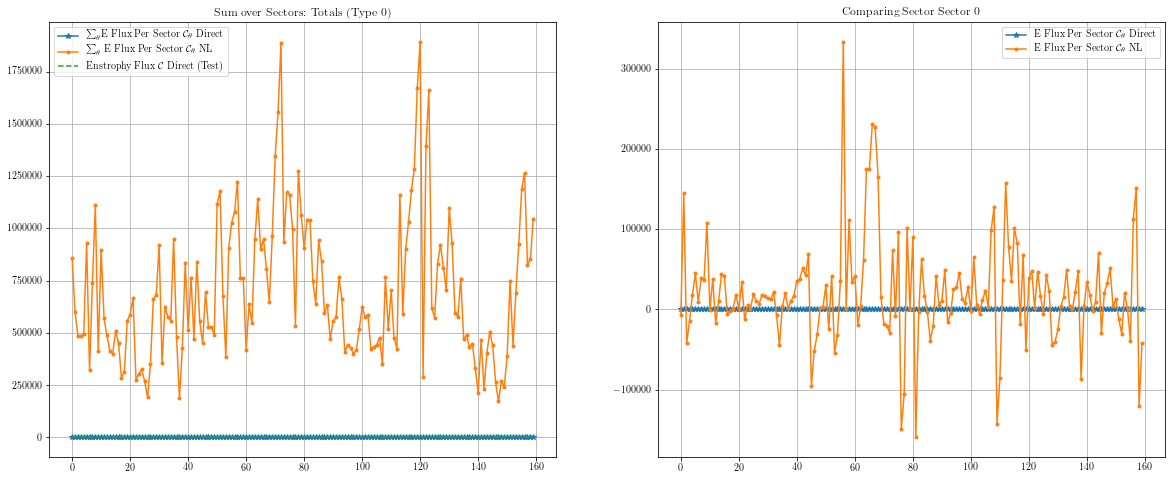

In [96]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2

theta = 0 #int(post_data.num_sect // 2)
print(theta)

print(-np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / norm_fac / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) / (np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * (-0.5 *(sys_vars.Nx * sys_vars.Ny)**2)))
print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / post_data.enst_flux_test[:, 0])

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * (-np.pi**2), '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) , '.-')
ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])

theta = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta] * 2, '.-')
ax1.set_title(r"Comparing Sector Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


plt.show()

##### with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(1), int(1), k_frac)) as f:
    num_wv_1 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_1 = np.zeros((1, 1, 16, np.amax(num_wv_1)))
    for a in range(1):
        for l in range(1):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_1[a, l]):
                    wv_1[a, l, k, n] = tmp_arr[k, n]
                    
                    
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(num_k3_sec), int(1), k_frac)) as f:
    num_wv_4 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_4 = np.zeros((num_k3_sec, 1, 16, np.amax(num_wv_4)))
    for a in range(num_k3_sec):
        for l in range(1):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_4[a, l]):
                    wv_4[a, l, k, n] = tmp_arr[k, n]
                    
                    
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[{},{}]_SECTORS[{},{}]_KFRAC[{:0.2f}].h5'.format(int(N_loc), int(N_loc), int(num_k3_sec), int(num_k1_sec), k_frac)) as f:
    num_wv_2 = f["NumWavevectors"][:, :]
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_2 = np.zeros((num_k3_sec, num_k1_sec, 16, np.amax(num_wv_2)))
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wv_2[a, l]):
                    wv_2[a, l, k, n] = tmp_arr[k, n]

K1_X         = 0
K1_Y         = 1
K2_X         = 2
K2_Y         = 3
K3_X         = 4
K3_Y         = 5
K1_SQR       = 6
K2_SQR       = 7
K3_SQR       = 8
K1_ANGLE     = 9
K2_ANGLE     = 10
K3_ANGLE     = 11
K1_ANGLE_NEG = 12
K2_ANGLE_NEG = 13
K3_ANGLE_NEG = 14
FLUX_TERM    = 15

              
print(num_wv_1)
print(num_wv_1.shape)
print(wv_1.shape)
print(num_wv_2)
print(num_wv_2.shape)
print(wv_2.shape)
print("Num 1,1: {}\tNum k3,1: {}\tNum k3,k1: {}".format(num_wv_1[0,0], np.sum(num_wv_4), np.sum(num_wv_2)))

print()
print(num_wv_1)
print(num_wv_4)
print(wv_4.shape)


## Check 1d + 2d = Flux

Sec: 0	 - 	1D + 2D: -366645801.2202349	 Total: -366645801.22023	 Eq: False	 Diff: 1.3322676295501878e-14	 Close: True
Sec: 1	 - 	1D + 2D: -1045979116.4106505	 Total: -1045979116.4106523	 Eq: False	 Diff: -1.6653345369377348e-15	 Close: True
Sec: 2	 - 	1D + 2D: -1018540207.1954466	 Total: -1018540207.1954486	 Eq: False	 Diff: -1.9984014443252818e-15	 Close: True
Sec: 3	 - 	1D + 2D: 698481654.8589938	 Total: 698481654.8589915	 Eq: False	 Diff: 3.3306690738754696e-15	 Close: True
Sec: 4	 - 	1D + 2D: -457574726.67528313	 Total: -457574726.67528117	 Eq: False	 Diff: 4.218847493575595e-15	 Close: True
Sec: 5	 - 	1D + 2D: -341895725.7571228	 Total: -341895725.757125	 Eq: False	 Diff: -6.439293542825908e-15	 Close: True
Sec: 6	 - 	1D + 2D: 301044478.27221817	 Total: 301044478.27221864	 Eq: False	 Diff: -1.5543122344752192e-15	 Close: True
Sec: 7	 - 	1D + 2D: -67385527.99113235	 Total: -67385527.991131	 Eq: False	 Diff: 2.020605904817785e-14	 Close: True
Sec: 8	 - 	1D + 2D: -70208537.08666003	 

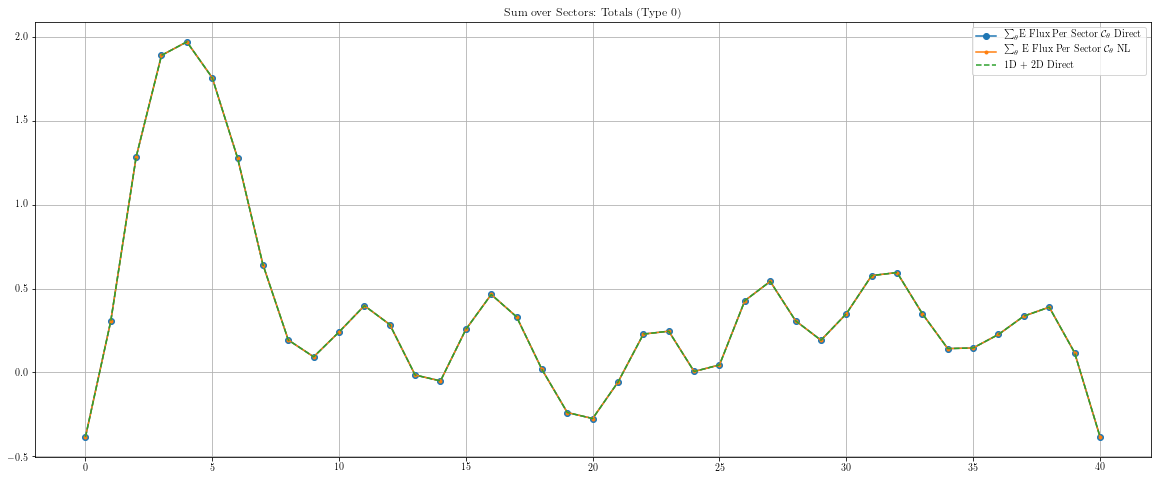

In [67]:
for i in range(post_data.num_sect):
    print("Sec: {}\t - \t1D + 2D: {}\t Total: {}\t Eq: {}\t Diff: {}\t Close: {}".format(i, 
          post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1), 
          post_data.enst_flux_per_sec[0, 0, i], 
          post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1) == post_data.enst_flux_per_sec[0, 0, i],
          (post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1)) / post_data.enst_flux_per_sec[0, 0, i] - 1,
         np.allclose(post_data.enst_flux_per_sec_1d[0, 0, i] + np.sum(post_data.enst_flux_per_sec_2d[0, 0, i, :], axis = -1), post_data.enst_flux_per_sec[0, 0, i])))
    
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, 'o-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec_1d[:, 0, :] + np.sum(post_data.enst_flux_per_sec_2d[:, 0, :, :], axis = -1), axis = -1) * const_fac * norm_fac, '--')
# ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"1D + 2D Direct", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])
plt.show()

## Check Complexification of flux

[2.00066072 1.99749698 1.99852961 1.99905408 1.99956324 2.00026159
 2.00064984 2.00031812 1.99326954 2.00679005 2.00189686 2.00191585
 2.00194455 2.00659415 1.99765052 1.99593747 1.99642987 1.98815323
 2.0005966  2.00052084 2.00485926 1.99198827 1.99930489 1.99985342
 1.99849224 1.99907882 2.00163591 2.0006504  1.99883565 1.9992185
 2.00019303 2.00064011 2.00023017 1.99913874 2.01842248 1.99196098
 1.99777395 2.00050454 2.00156691 1.99898851 2.00174085]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


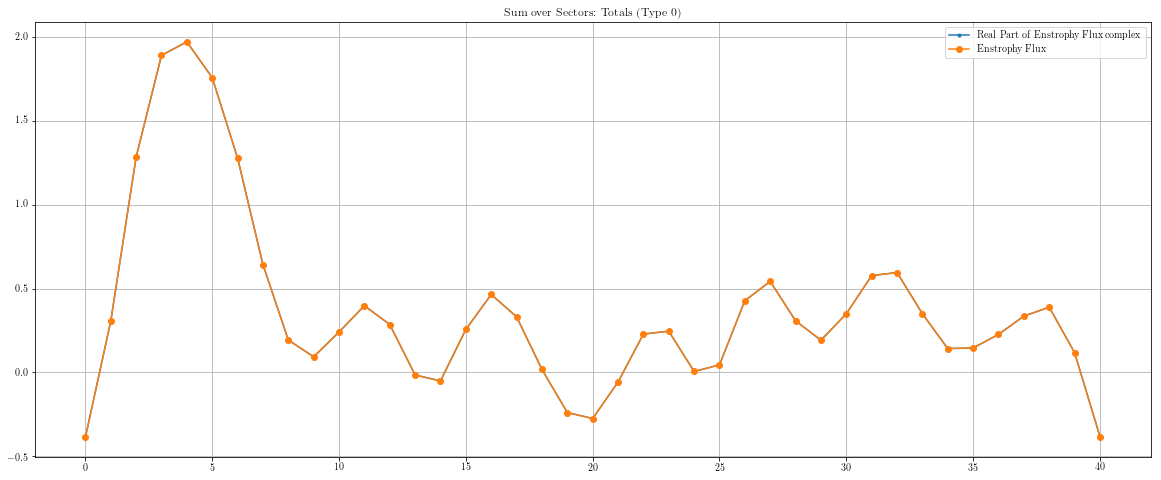

In [68]:
# print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1))
# print(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1))

# print(post_data.enst_flux_per_sec[:, 0, -1] / np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, -1]))
# print(np.imag(post_data.phase_order_C_theta_triads_unidirec[:, 0, 10]))

print(np.sum(post_data.enst_flux_per_sec[:, 0, :-1], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :-1]), axis = -1))
print(np.sum(post_data.enst_flux_per_sec[:, 0, :-1], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :-1]), axis = -1))

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1) * const_fac * norm_fac, '.-')
# ax2.plot(np.sum(np.real(post_data.phase_order_C_theta[:, 0, :]), axis = -1) * const_fac * norm_fac, '.-') # Wasn't read in corretly
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, 'o-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
# ax2.set_yscale('log')
ax2.grid()
ax2.legend([r"Real Part of Enstrophy Flux complex", r"Enstrophy Flux"])
plt.show()

## Check Unidrectional Phase Order Parameter

[ 2.18843698  1.73142351  1.97375508  2.05504346  2.02053834  1.98891398
  1.8599669   1.52591281  1.48129422  1.18138445  1.2490649   2.11049557
  3.06049448 -1.33470845 -1.53558929  1.74384757  2.2652689   1.99775782
  0.3292044   3.35247705  3.35970784  7.73526547  7.02866316  7.30743843
  0.57264301  1.22050944  2.07718571  1.73625739  1.84415734  2.65272939
  1.62816461  1.93836583  2.64673868  2.08189792  0.96225052  1.07255203
  1.30942096  1.40225581  1.69964108  2.2485516   1.75003549]
[2.00066072 1.99749698 1.99852961 1.99905408 1.99956324 2.00026159
 2.00064984 2.00031812 1.99326954 2.00679005 2.00189686 2.00191585
 2.00194455 2.00659415 1.99765052 1.99593747 1.99642987 1.98815323
 2.0005966  2.00052084 2.00485926 1.99198827 1.99930489 1.99985342
 1.99849224 1.99907882 2.00163591 2.0006504  1.99883565 1.9992185
 2.00019303 2.00064011 2.00023017 1.99913874 2.01842248 1.99196098
 1.99777395 2.00050454 2.00156691 1.99898851 2.00174085]


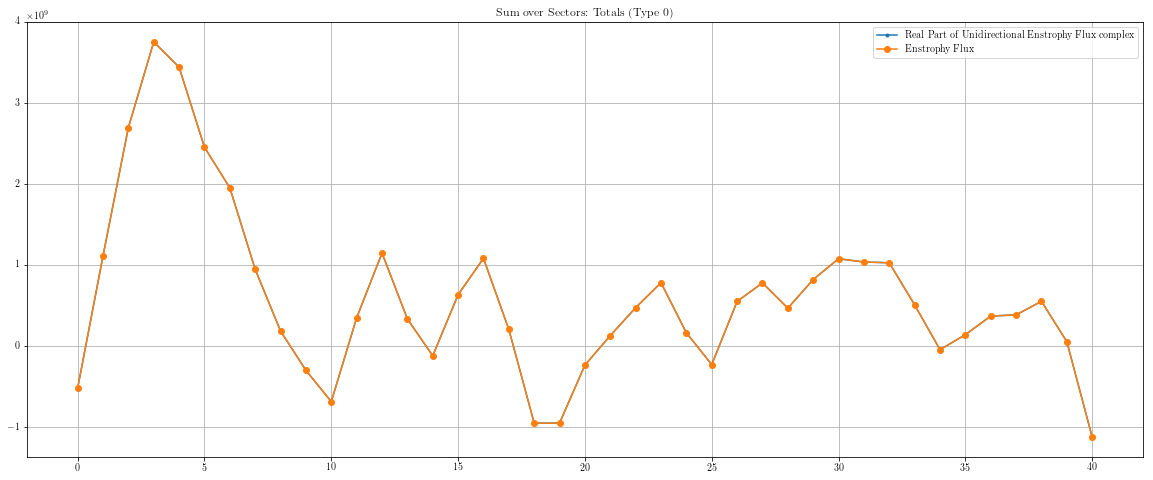

In [57]:
print(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :]), axis = -1))
print(np.sum(post_data.enst_flux_per_sec[:, 0, :-1], axis = -1) / np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :-1]), axis = -1))

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :-1]), axis = -1), '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :-1], axis = -1) / 2, 'o-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
# ax2.set_yscale('log')
ax2.grid()
ax2.legend([r"Real Part of Unidirectional Enstrophy Flux complex", r"Enstrophy Flux"])
plt.show()

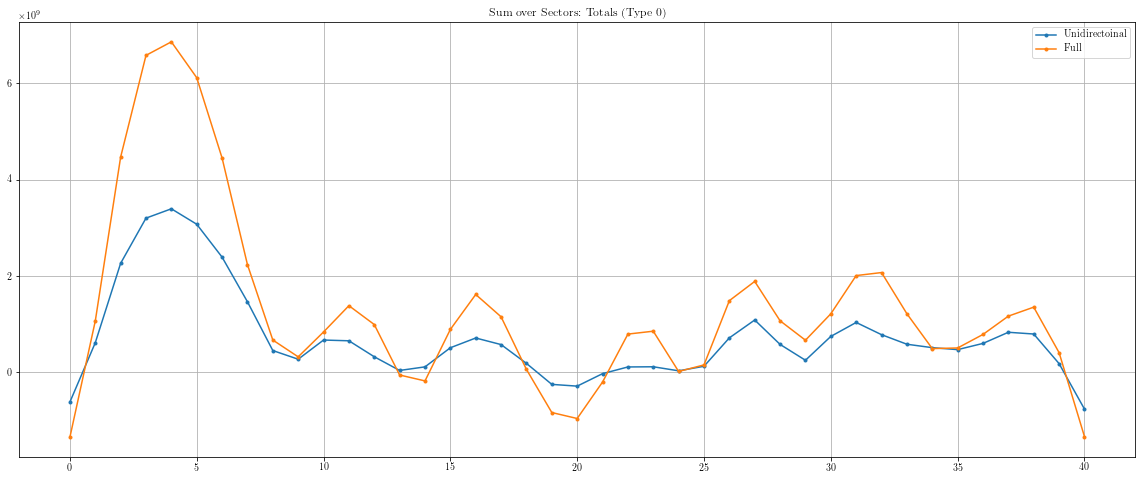

In [18]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads_unidirec[:, 0, :]), axis = -1), '.-')
ax2.plot(np.sum(np.real(post_data.phase_order_C_theta_triads[:, 0, :]), axis = -1), '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"Unidirectoinal", r"Full"])
plt.show()

IndexError: index 90 is out of bounds for axis 0 with size 41

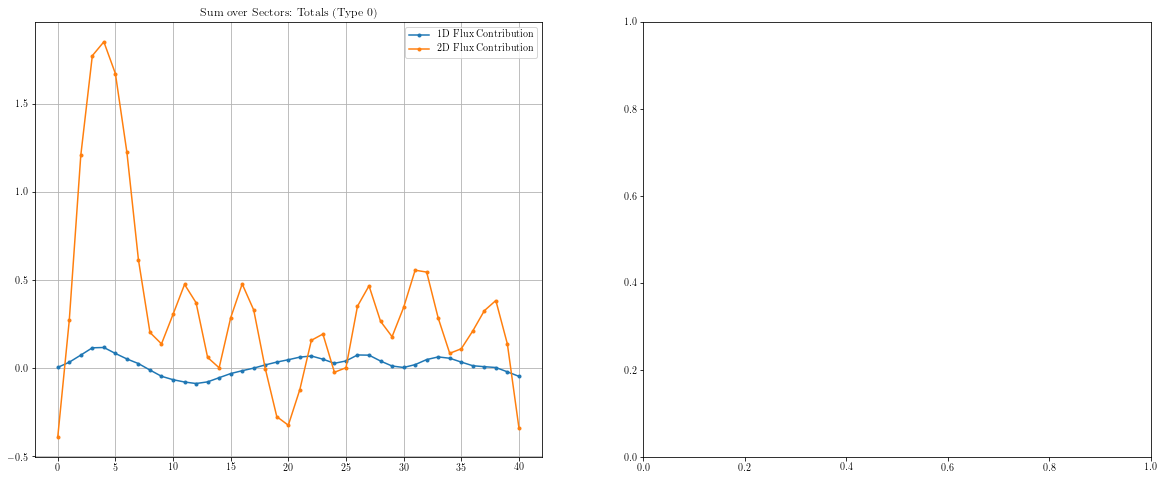

In [19]:
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec_1d[:, 0, :], axis = -1) * const_fac * norm_fac, '.-')
ax2.plot(np.sum(np.sum(post_data.enst_flux_per_sec_2d[:, 0, :, :], axis = -1), axis = -1) * const_fac * norm_fac, '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"1D Flux Contribution", r"2D Flux Contribution"])

t = 90
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(post_data.enst_flux_per_sec_2d[t, 0, :, :])
ax1.set_title(r"Sum over Sectors: Totals (Type 0)")

plt.show()

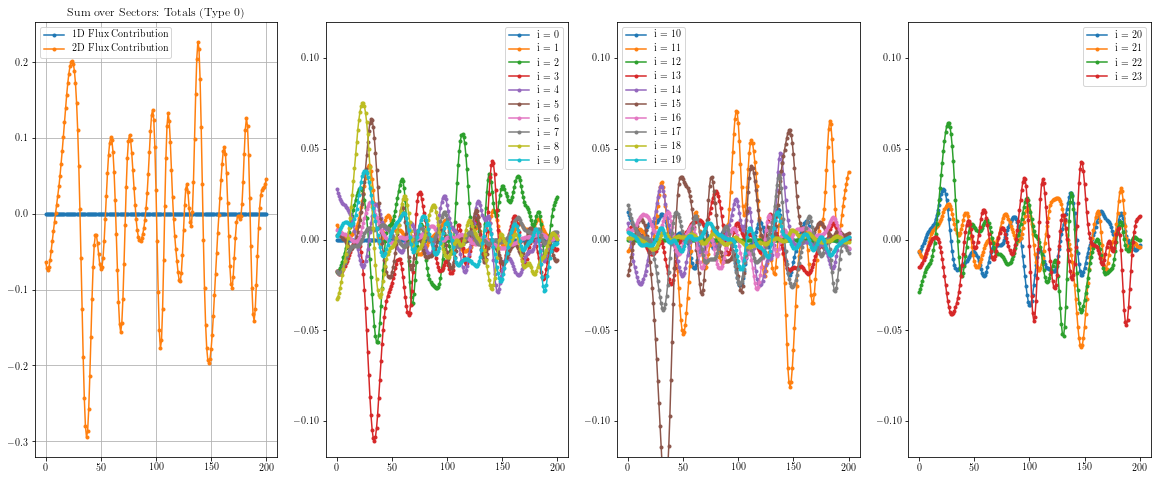

0.06544984694978828
-1.5053464798451093
-1.1126473981463847


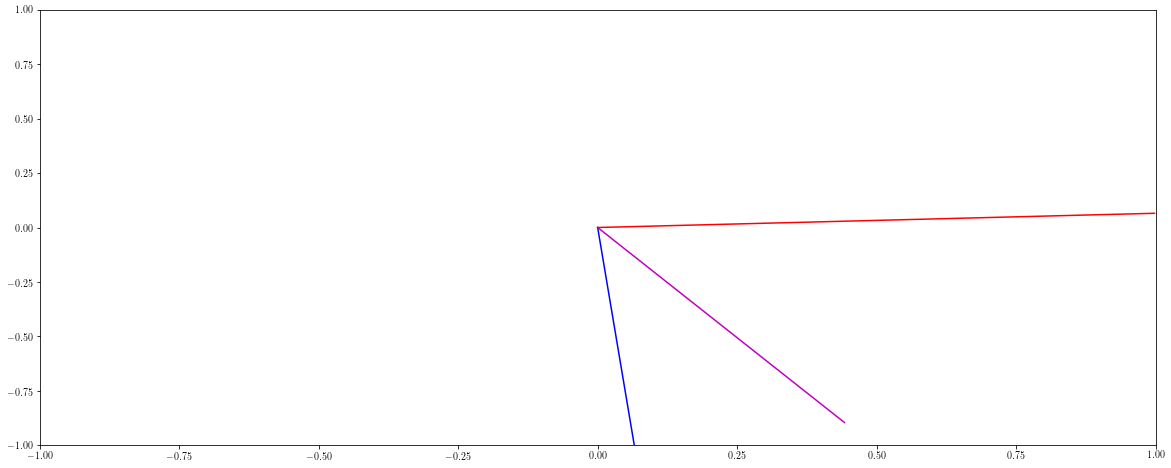

-1.5707963267948974
-1.1780972450961729
-0.1308996938995748


In [85]:
k3 = 12
fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 4)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(post_data.enst_flux_per_sec_1d[:, 0, k3] * const_fac * norm_fac, '.-')
ax2.plot(np.sum(post_data.enst_flux_per_sec_2d[:, 0, k3, :], axis = -1) * const_fac * norm_fac, '.-')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.legend([r"1D Flux Contribution", r"2D Flux Contribution"])
ax2.grid()
ax1 = fig.add_subplot(gs[0, 1])
for i in range(10):
    ax1.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i] * const_fac * norm_fac, '.-')
ax1.legend([r"i = {}".format(i) for i in range(10)])
ax1.set_ylim(-0.12, 0.12)
ax3 = fig.add_subplot(gs[0, 2])
for i in range(10):
    ax3.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i + 10] * const_fac * norm_fac, '.-')
ax3.legend([r"i = {}".format(i + 10) for i in range(10)])
ax3.set_ylim(-0.12, 0.12)

ax4 = fig.add_subplot(gs[0, 3])
for i in range(4):
    ax4.plot(post_data.enst_flux_per_sec_2d[:, 0, k3, i + 10 + 10] * const_fac * norm_fac, '.-')
ax4.legend([r"i = {}".format(i + 10 + 10) for i in range(4)])
ax4.set_ylim(-0.12, 0.12)

plt.show()

n_theta   = post_data.num_sect
dtheta    =  np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
print(theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 12, 24)])
print(theta[np.mod(k3 + 15, 24)])

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot([0.0, np.cos(theta[np.mod(k3, 24)])], [0.0, np.sin(theta[np.mod(k3, 24)])], 'r')
ax2.plot([0.0, np.cos(theta[np.mod(k3 + 12, 24)])], [0.0, np.sin(theta[np.mod(k3 + 12, 24)])], 'b')
ax2.plot([0.0, np.cos(theta[np.mod(k3 + 15, 24)])], [0.0, np.sin(theta[np.mod(k3 + 15, 24)])], 'm')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1, 1)

plt.show()

print(theta[np.mod(k3 + 12, 24)] - theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 15, 24)] - theta[np.mod(k3, 24)])
print(theta[np.mod(k3 + 23, 24)] - theta[np.mod(k3, 24)])

In [94]:
def compute_pdf(bin_ranges, bin_counts, normalized = False):

    ## Get nonzero bin indexs
    non_zero_args = np.where(bin_counts != 0)

    ## Get the bin centres
    bin_centres = (bin_ranges[1:] + bin_ranges[:-1]) * 0.5
    bin_centres = bin_centres[non_zero_args]

    ## Compute the bin width
    bin_width = bin_ranges[1] - bin_ranges[0]

    ## Compute the pdf
    pdf = bin_counts[:] / (np.sum(bin_counts[:]) * bin_width)
    pdf = pdf[non_zero_args]

    if normalized:
        var         = np.sqrt(np.sum(pdf * bin_centres**2 * bin_width))
        pdf         *= var
        bin_centres /= var 
        bin_width   /= var


    return bin_centres, pdf

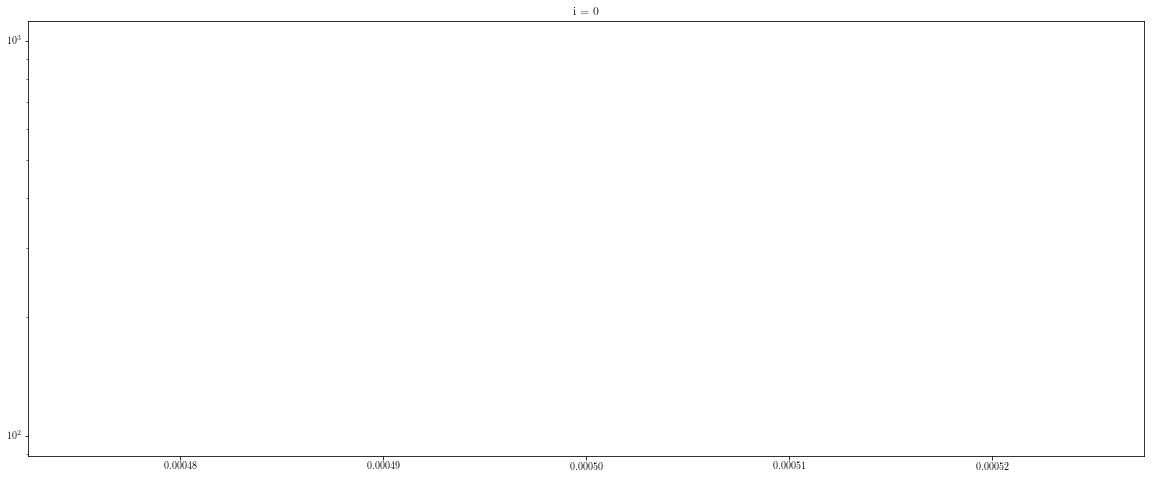

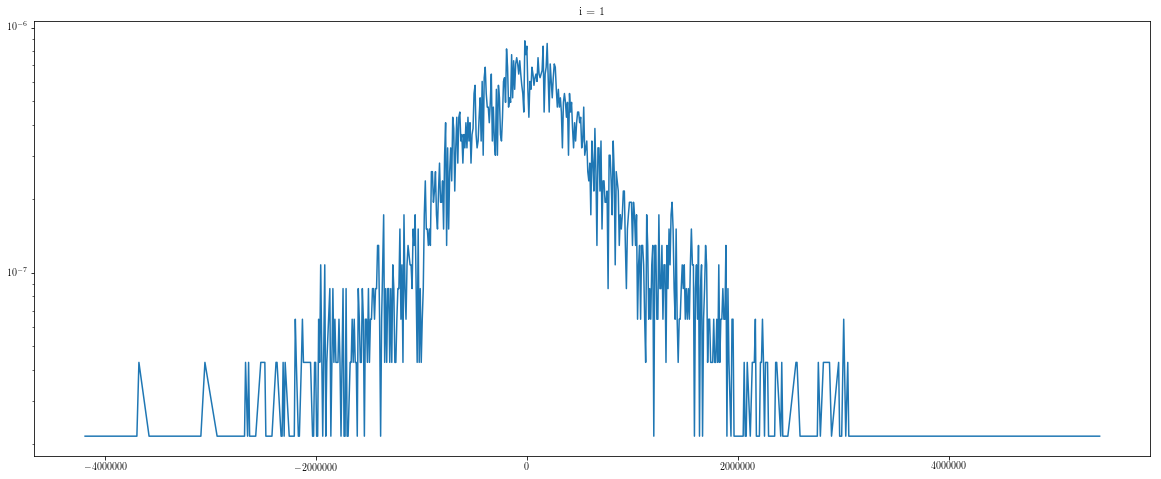

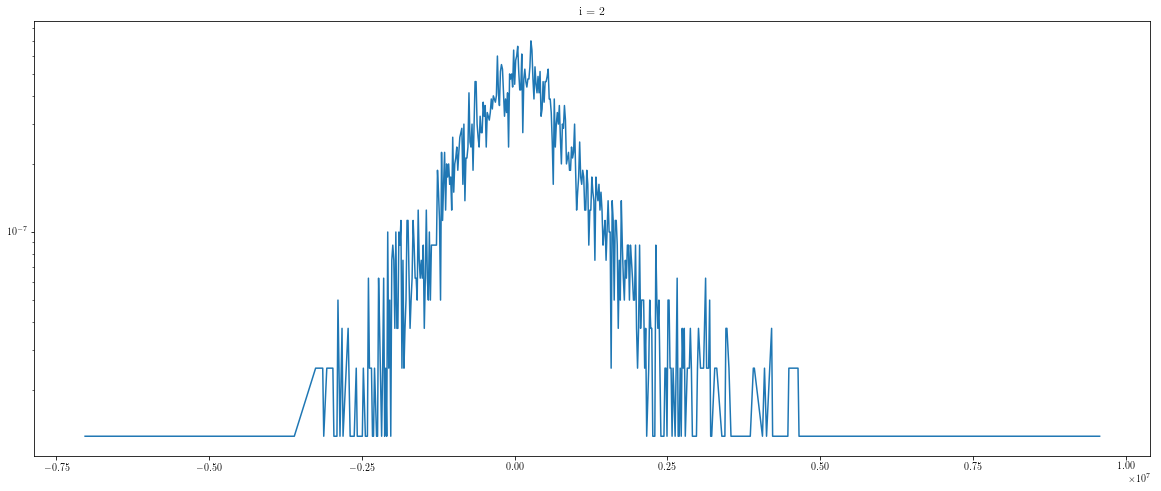

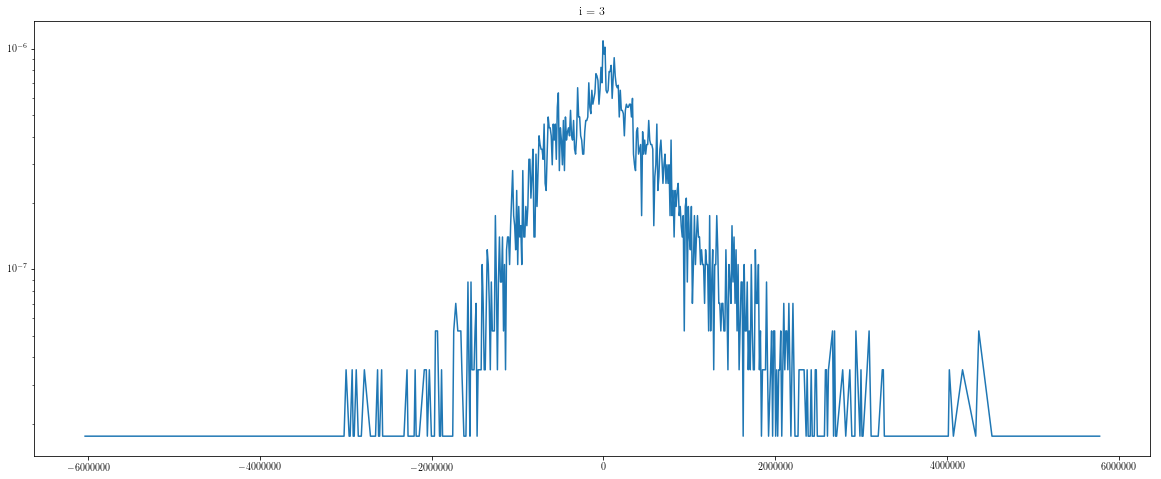

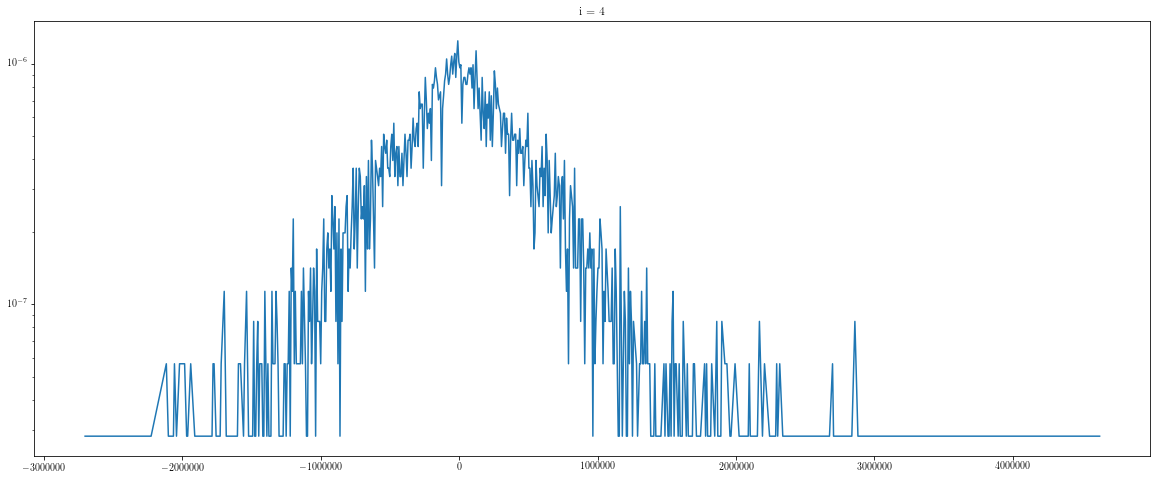

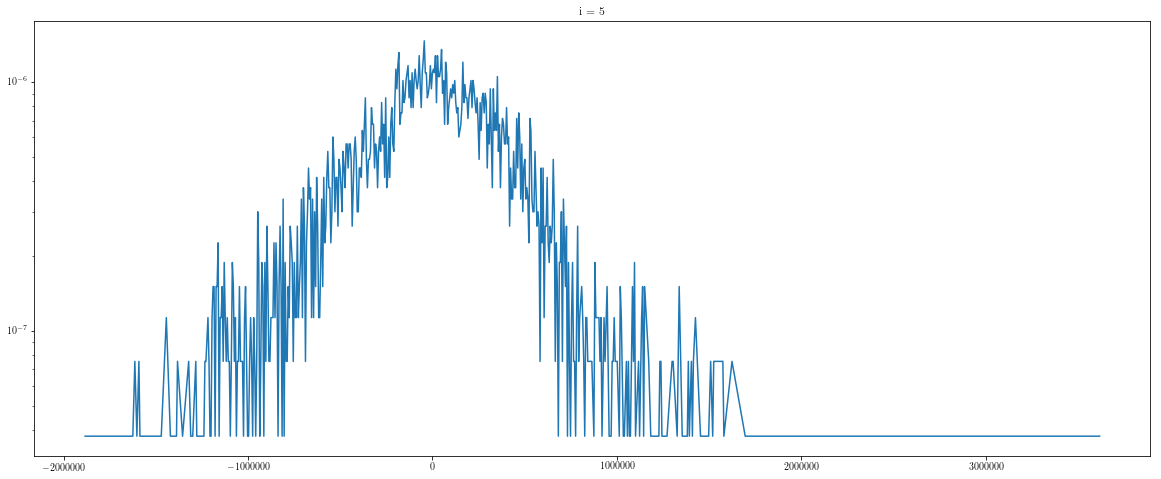

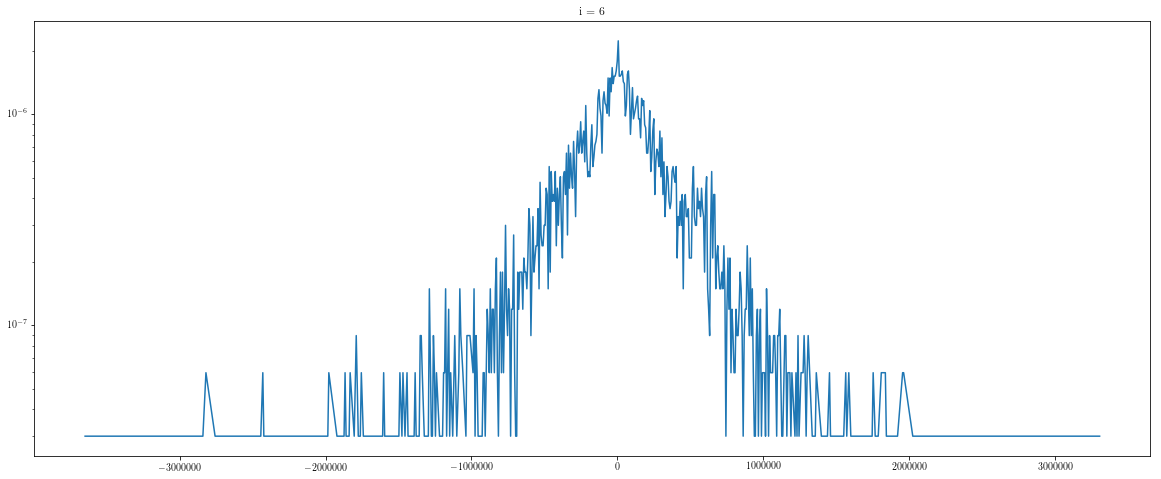

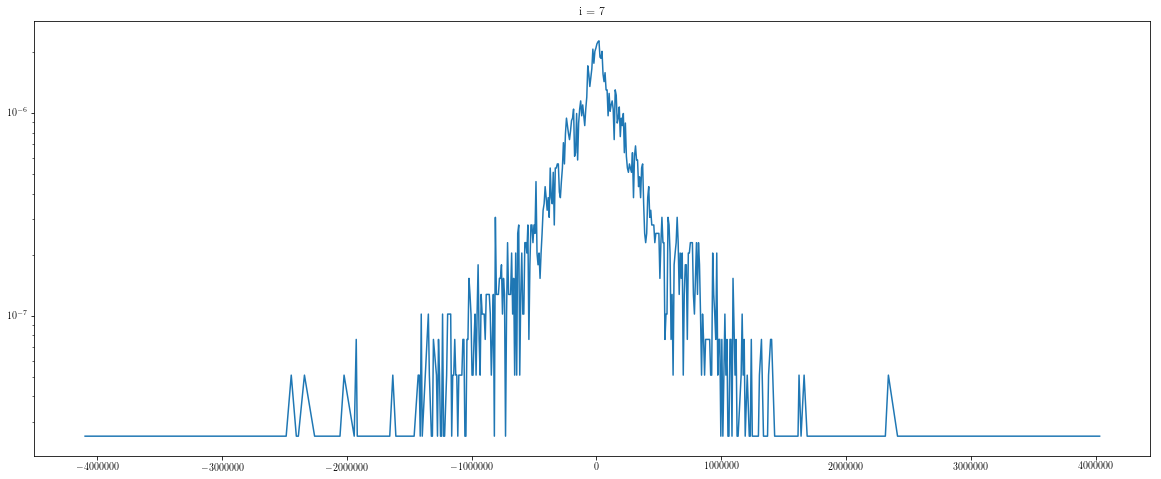

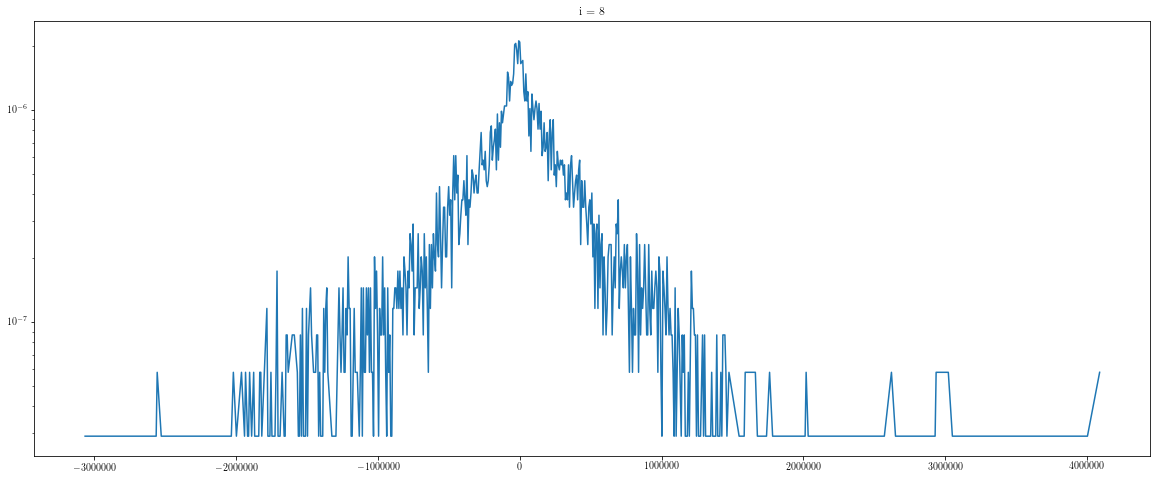

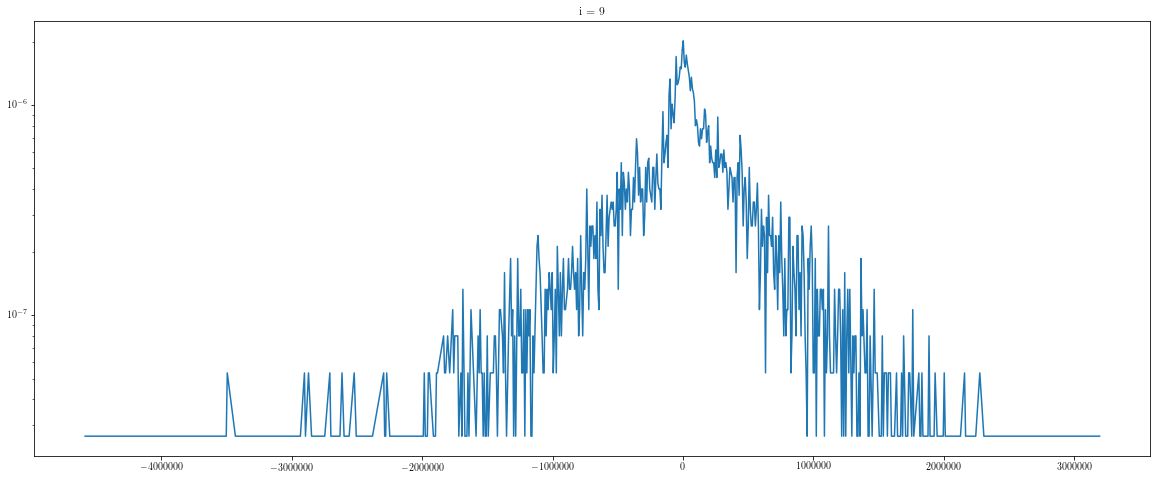

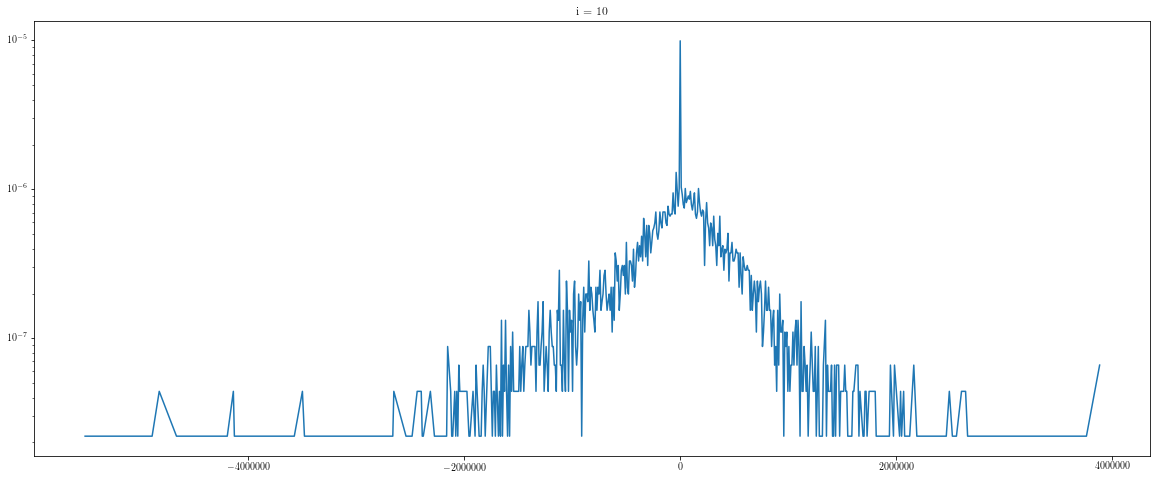

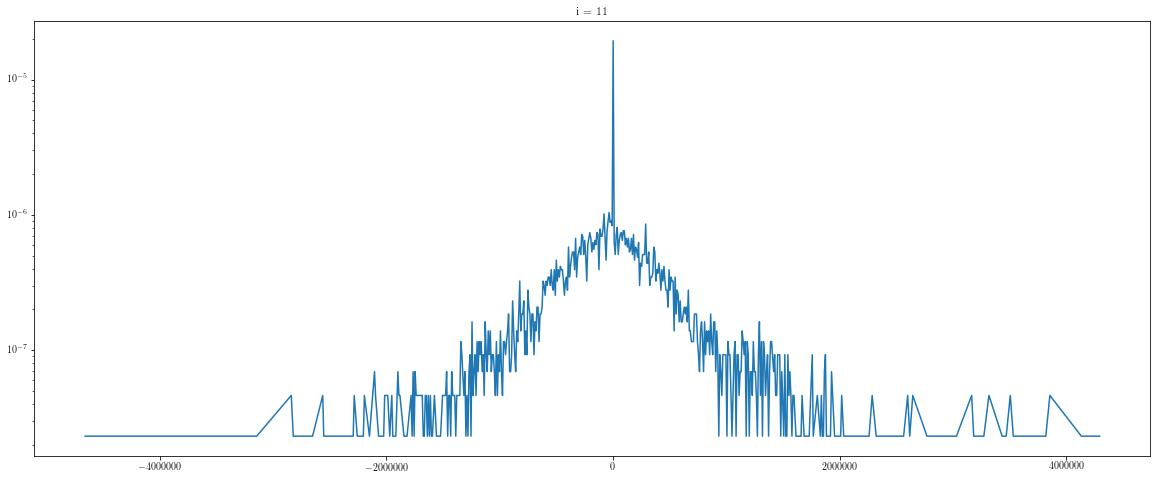

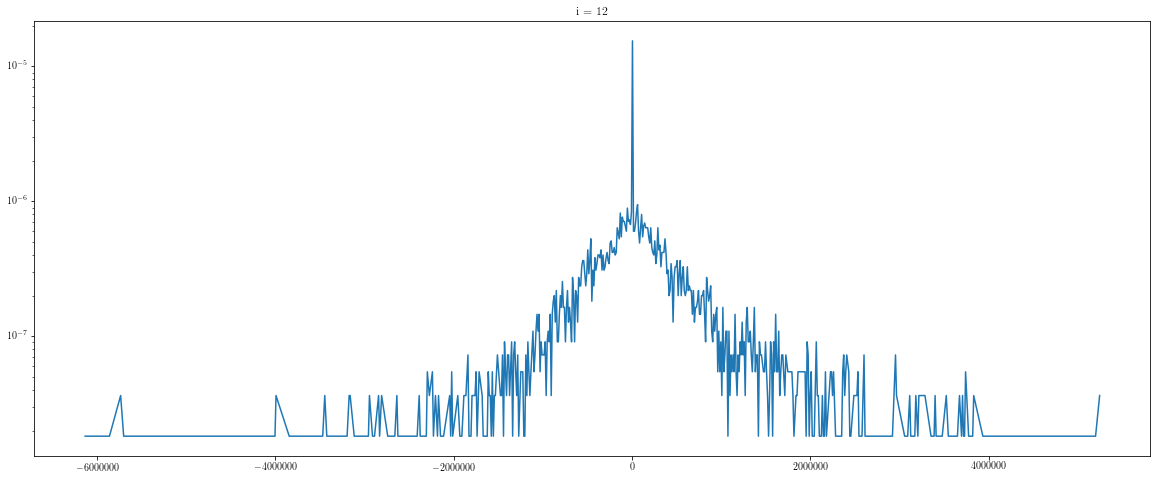

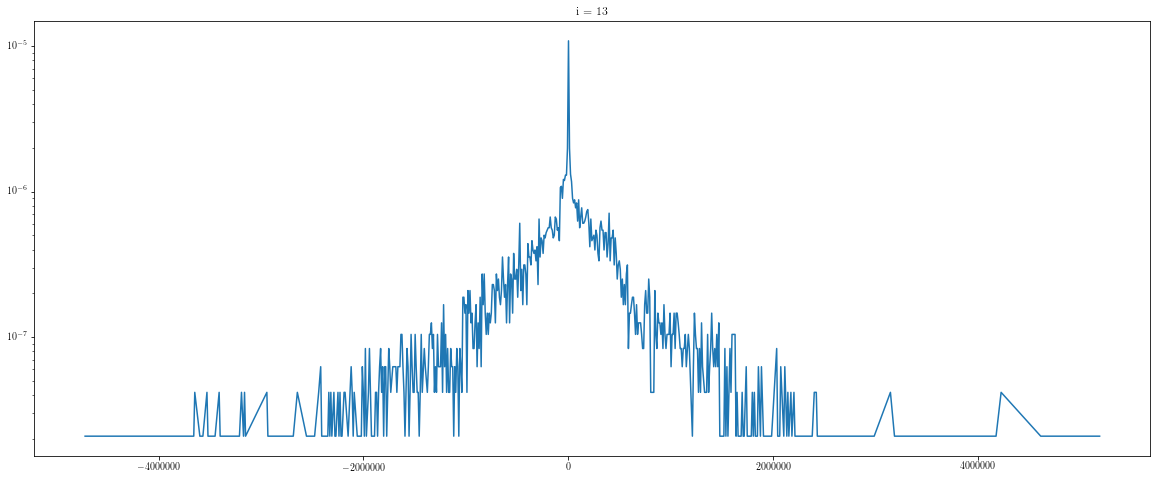

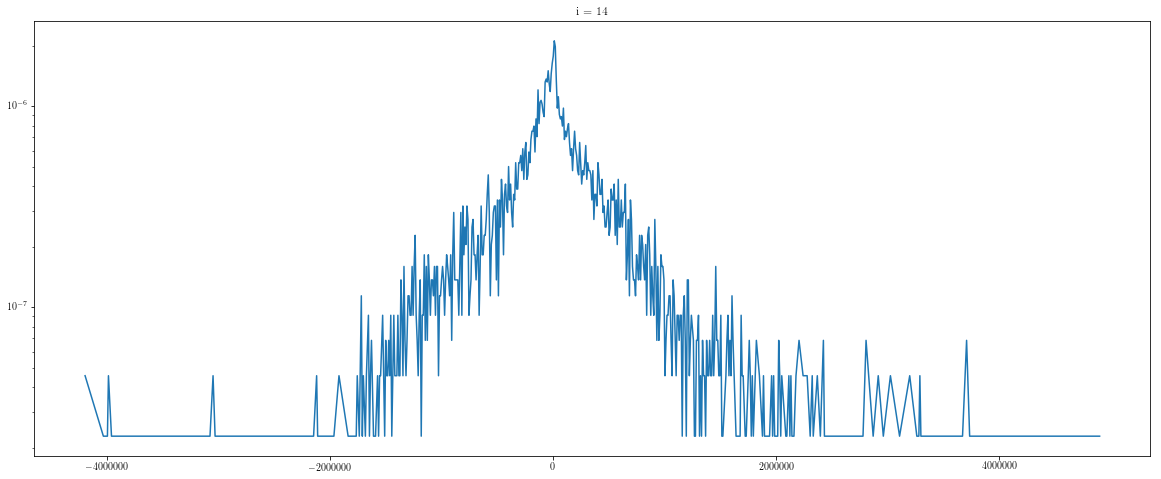

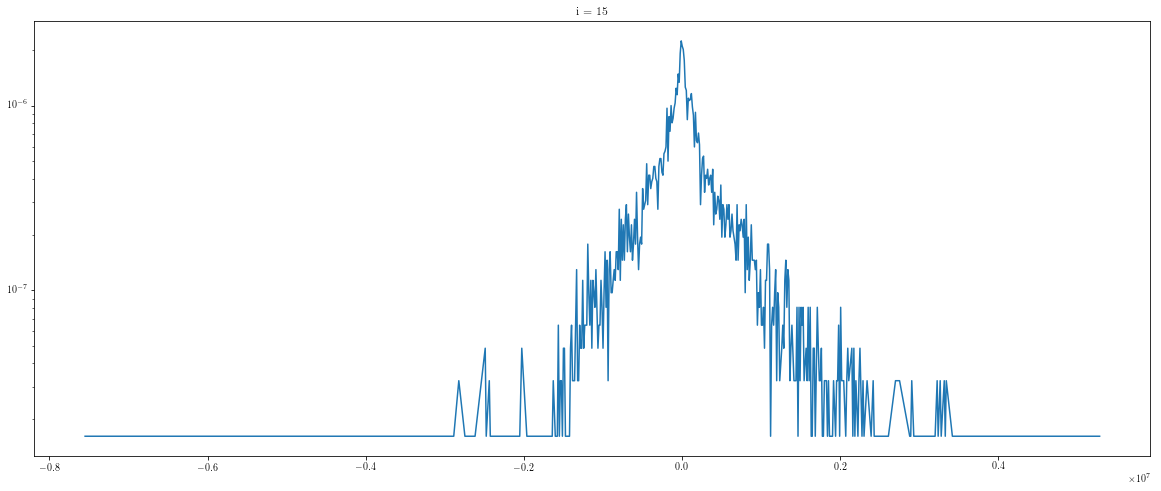

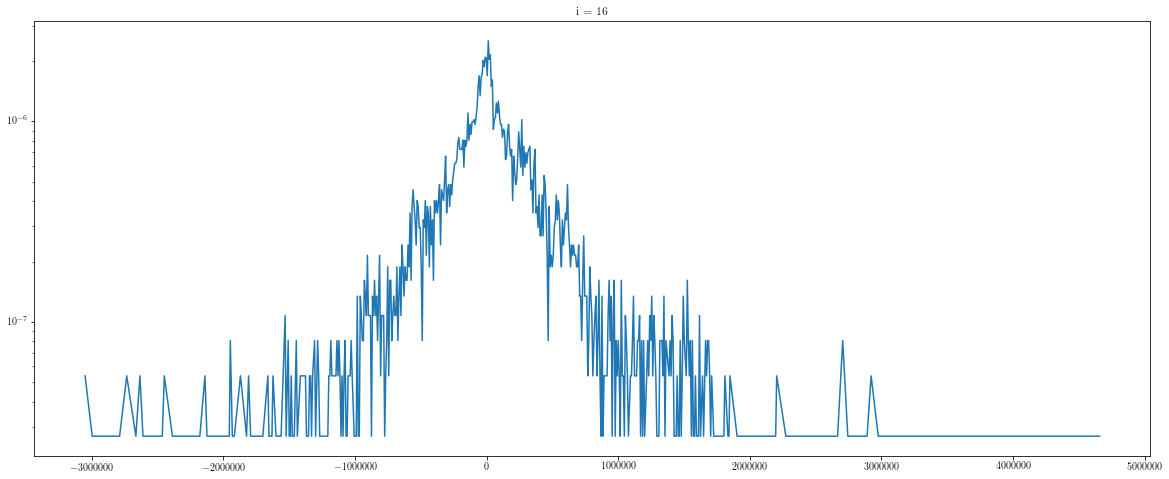

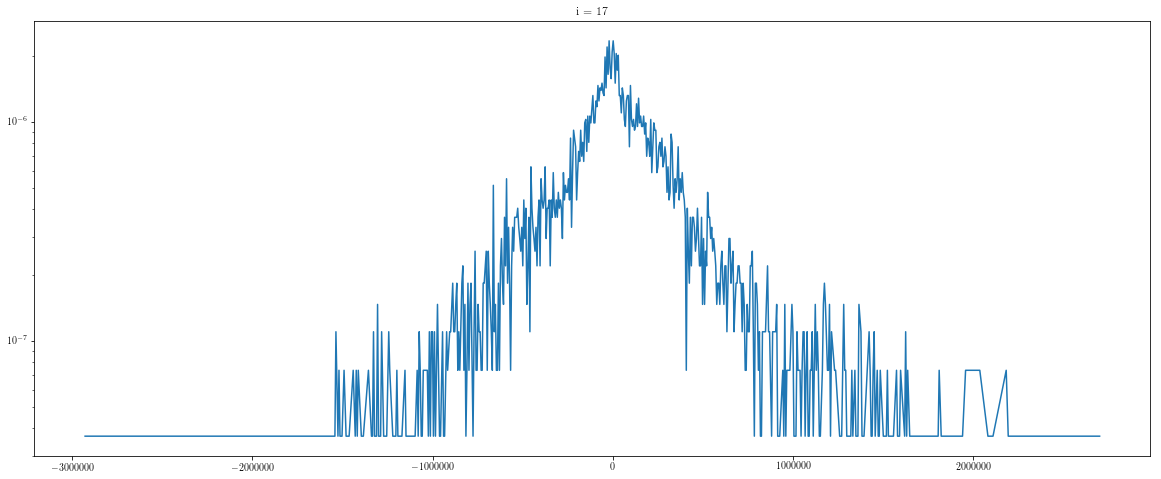

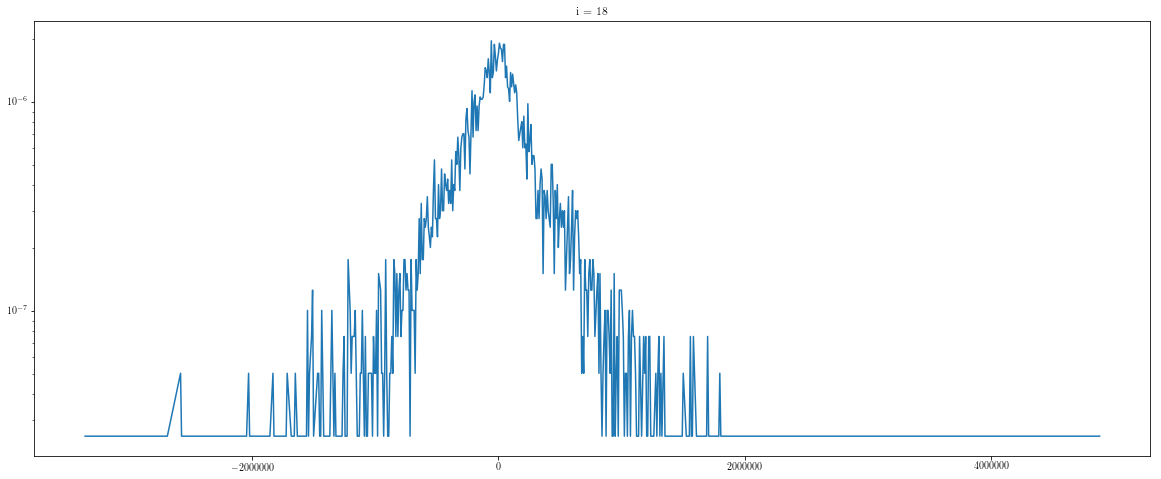

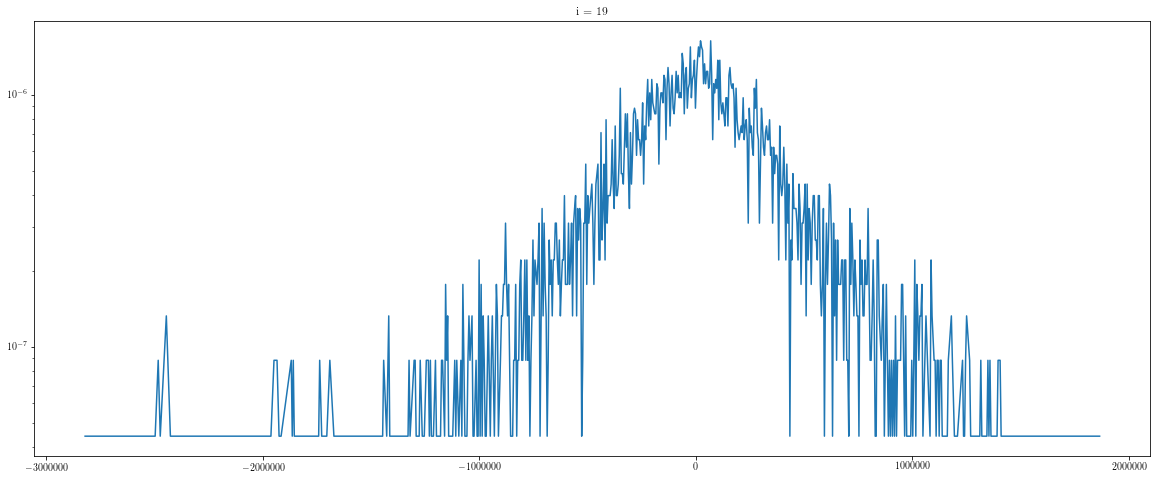

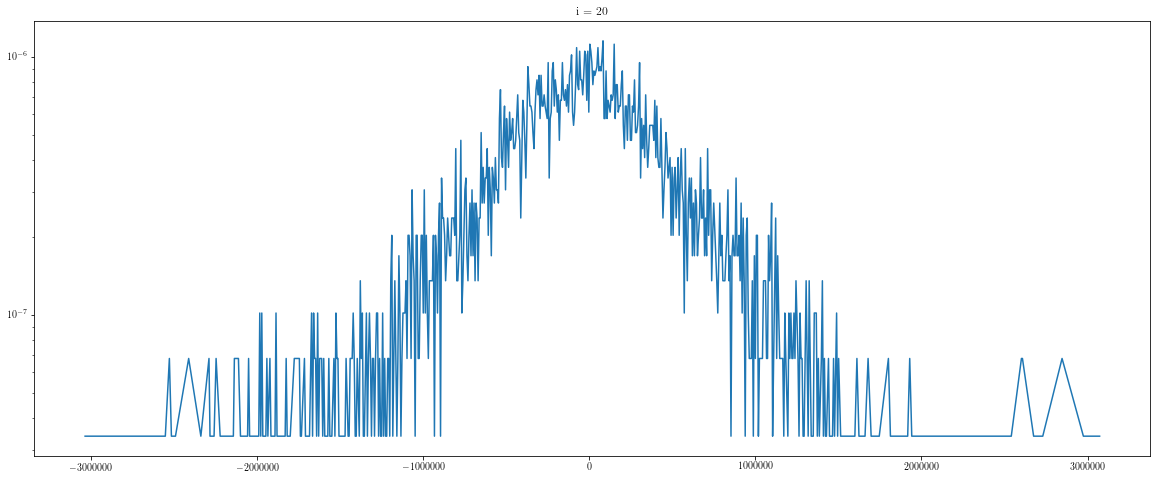

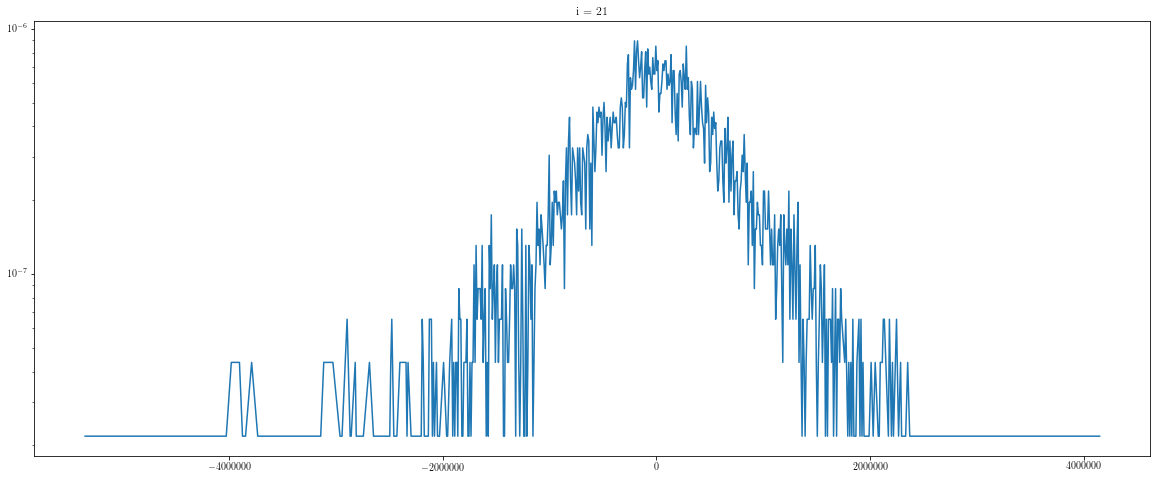

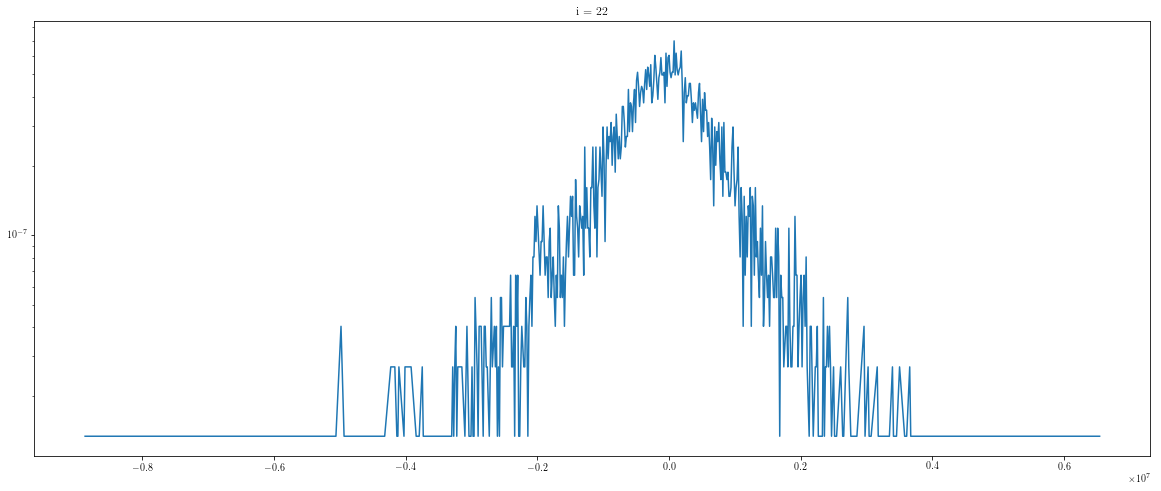

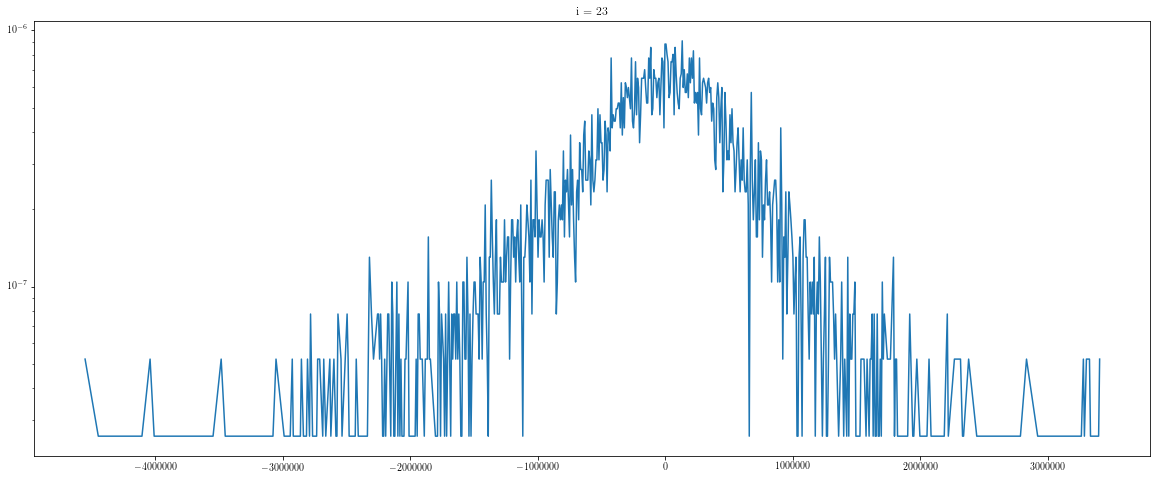

[0.0, 39812.962081156686, 116212.74552643091, 62926.351823385994, 38400.515863351684, -59.02922525206213, 4679.232702176355, -599.2881078694146, -23059.61793910613, -20819.988705204105, -77411.51101054074, -4578.090880247231, 81498.64273870851, -29703.01832770697, 11294.975622883021, 51502.50184926817, 59214.75032005413, 22924.13303829013, -16461.42940304456, -27721.672909999626, -52981.25892326172, -44554.70095798308, -136902.83098965473, -98039.93407713309]


In [102]:
# print(post_data.enst_flux_per_sec_2d[0, 0, 0, :])
# print(post_data.num_triads_2d[0, :, 12])
import scipy

mean = []
for i in range(post_data.num_k1_sects):
    counts, edges = np.histogram(post_data.enst_flux_per_sec_2d[:, 0, :, i], bins = 1000)
    bin_centres, pdf = compute_pdf(edges, counts)
    
    mean.append(np.mean(post_data.enst_flux_per_sec_2d[:, 0, :, i]))
    fig = plt.figure(figsize = (20, 8))
    gs  = GridSpec(1, 1)
    ax2 = fig.add_subplot(gs[0, 0])
    ax2.plot(bin_centres, pdf)
    ax2.set_yscale('log')
    ax2.set_title("i = {}".format(i))
    plt.show()
print(mean)

In [84]:
print(post_data.enst_flux_C_theta[:, :])

[[ 0.01093992 -0.04352839 -0.05221807 ...  0.01883611 -0.03544097
   0.01075189]
 [ 0.00362363 -0.06874446 -0.04419212 ...  0.01586799 -0.04789295
   0.00088531]
 [-0.0043458  -0.08882347 -0.03292861 ...  0.01419516 -0.05982331
  -0.00706148]
 ...
 [ 0.03471465  0.00325095 -0.02152442 ... -0.01072018  0.04319488
  -0.04004245]
 [ 0.02270895  0.01414995 -0.02323791 ... -0.01388749  0.04539528
  -0.04600686]
 [ 0.00690568  0.02853438 -0.02403321 ... -0.01598299  0.04429657
  -0.04513556]]


In [480]:
# test_c_theta_flux = np.sum(post_data.enst_flux_C_theta[:, :], axis = -1)
# test_test_flux = post_data.enst_flux_test[:, 0] * const_fac * norm_fac
# test_flux_c_theta_full = post_data.enst_flux_C_theta[:, :]
# test_test_full = post_data.enst_flux_test[:, 0]
# print(test_flux_c_theta_full.shape)
# print(test_flux_c_theta_full)
# print(test_test_full.shape)
# print(test_test_full)

In [107]:
print(post_data.enst_flux_per_sec[0, 0, :])
print(post_data.enst_flux_per_sec[0, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))
print()
print(post_data.num_wv)
print(post_data.num_wv.shape)
print(post_data.wv.shape)

[ -7005.81349153  -2109.86501106 -16936.9664138   29853.5173995 ]
[ -2274.59742631  -5284.99521296 -11699.82281345  13974.34852586]
[166 232 166 232]


Sect ID 	 Enst  			 Enst 			 Diff 		 Matching		AllClose	Num Triads
0/2:	-7005.813491531523	-16936.96641380368	9931.152922272155		False		False		166
1/3:	-2109.8650110614085	29853.517399503515	-31963.382410564922		False		False		232

[[ 72  94]
 [120 112]
 [ 94  72]
 [112 120]]
(4, 2)
(4, 2, 16, 120)


In [95]:
num_k3_sec = 10
num_k1_sec = 1

with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1[a, l]):
                    wv[a, l, k, n] = tmp_arr[k, n]
                    
num_k3_sec = 10
num_k1_sec = 2     
# print(post_data.num_k1_sects)
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1_2 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_2 = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1_2))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1_2[a, l]):
                    wv_2[a, l, k, n] = tmp_arr[k, n]
                    
                    
num_k3_sec = 10
num_k1_sec = 4

with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[{},{}]_KFRAC[0.75].h5'.format(int(num_k3_sec), int(num_k1_sec))) as f:
    num_wave_vec_sec1_4 = f["NumWavevectors"][:, :]
#     print(num_wave_vec_sec1)
    num_triad_est_4 = int(np.ceil(np.pi * sys_vars.Nx**2 + 2.0 * np.sqrt(2.0) * np.pi * sys_vars.Ny) * 100);
    wv_4 = np.ones((num_k3_sec, num_k1_sec, 16, np.amax(num_wave_vec_sec1_4))) * 100
    for a in range(num_k3_sec):
        for l in range(num_k1_sec):
            tmp_arr = f["WVData_Sector_{}_{}".format(a, l)][:, :]
            for k in range(16):
                for n in range(num_wave_vec_sec1_4[a, l]):
                    wv_4[a, l, k, n] = tmp_arr[k, n]
print("First Sum -------- Second Sum")
print("1 - 2 - 4 -------- 1 - 2 - 4")
for a in range(num_k3_sec):
#     print(wv_10[a, :, -1, :])
    print("{} - {} - {} -------- {} - {} - {}".format(np.sum(wv[a, :, -1, :] == 0), np.sum(wv_2[a, :, -1, :] == 0), np.sum(wv_4[a, :, -1, :] == 0), np.sum(wv[a, :, -1, :] == 1), np.sum(wv_2[a, :, -1, :] == 1), np.sum(wv_4[a, :, -1, :] == 1)))  
print(post_data.num_triads)
print(num_wave_vec_sec1_2)

OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[10,2]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
## Pick sector to examine
sec_i = 0

## Ignore the extra data
ignore   = wv[sec_i, :, -1, :] != 100
ignore_2 = wv_2[sec_i, :, -1, :] != 100
wv_i     = wv[sec_i, :, :, ignore[0]]
wv_2_i   = wv_2[sec_i, :, :, ignore_2[0]]

## Extract first or second sum cases
term = 1
flux_term_type = wv_i[:, :, -1] == term
wv_i_terms = wv_i[flux_term_type[:, 0], :, :6][:, 0, :]
for i in range(wv_i_terms.shape[0]):
    print(wv_i_terms[i, :])
flux_term_type = wv_2_i[:, :, -1] == term
wv_2_i_terms = wv_2_i[flux_term_type[:, 0], :, :6][:, :, :]
for i in range(wv_2_i_terms.shape[0]):
    print(wv_2_i_terms[i, :, :])

[-2. -4.  1.  4. -1.  0.]


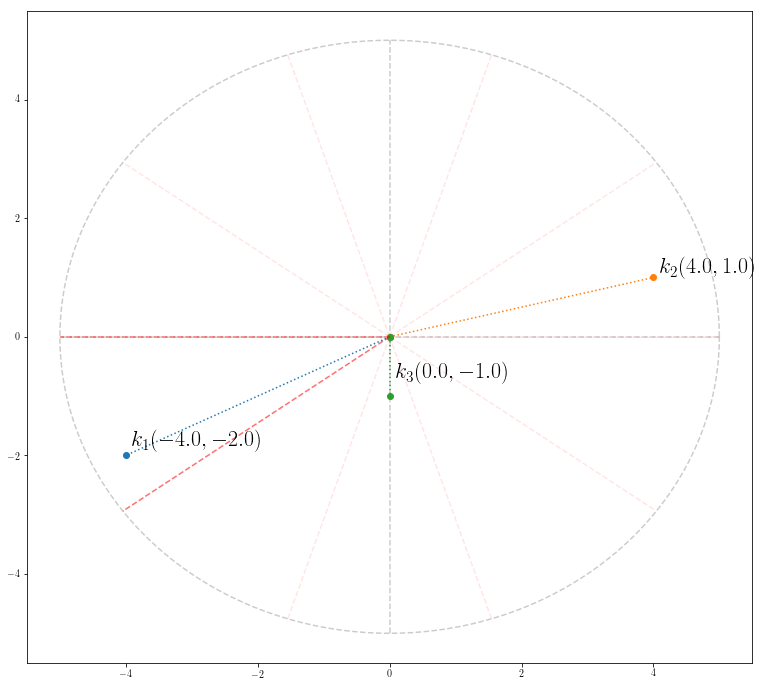

[ 1.  4. -2. -4. -1.  0.]


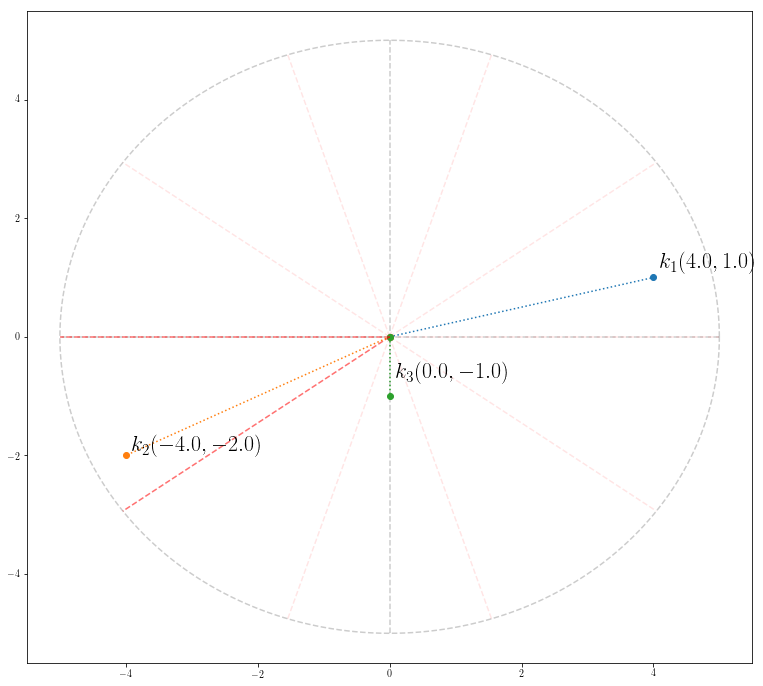

[-1. -4.  2.  4.  1.  0.]


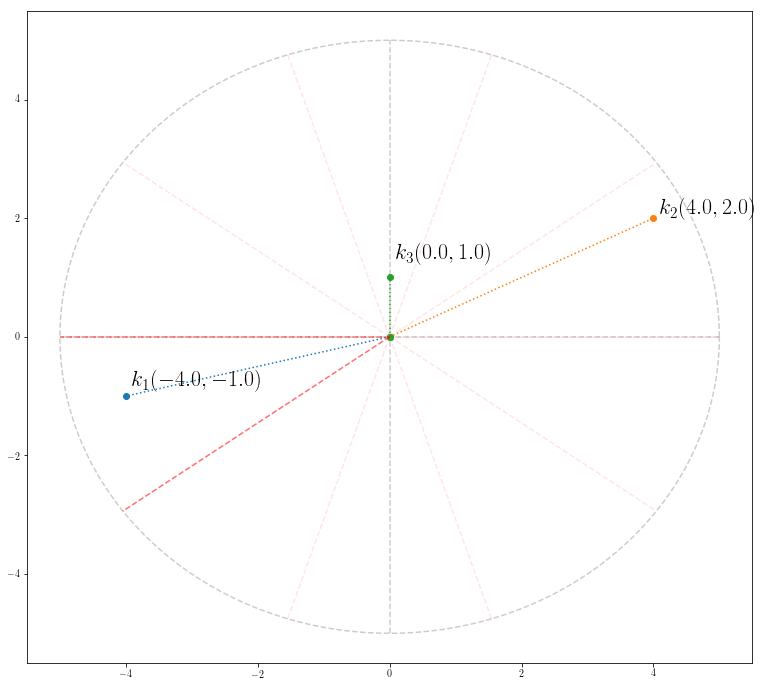

[ 2.  4. -1. -4.  1.  0.]


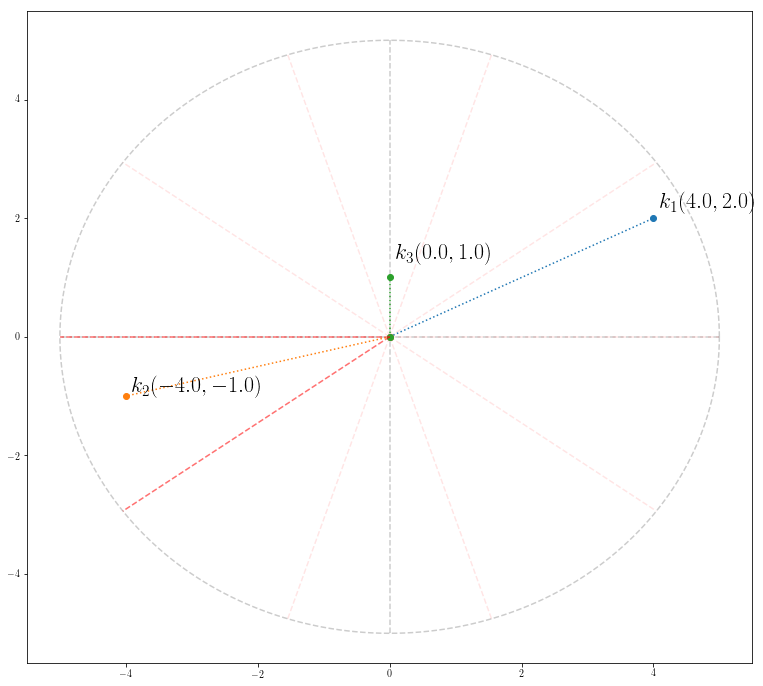

In [50]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

K1_X         = 0
K1_Y         = 1
K2_X         = 2
K2_Y         = 3
K3_X         = 4
K3_Y         = 5
K1_SQR       = 6
K2_SQR       = 7
K3_SQR       = 8
K1_ANGLE     = 9
K2_ANGLE     = 10
K3_ANGLE     = 11
K1_ANGLE_NEG = 12
K2_ANGLE_NEG = 13
K3_ANGLE_NEG = 14
FLUX_TERM    = 15

dsec = sec_i

for k_vec in wv_i_terms[:, :]:
    
    print(k_vec)

    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
#     p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#     p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#     p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
    p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
    p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
    p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
    plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
    plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
    plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

    plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
    plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
    
    plt.show()

In [ ]:
print(post_data.enst_flux_per_sec[-100, 0, :])
print(post_data.enst_flux_per_sec[-100, 1, :])
print(post_data.num_triads[0, :])
# NOTE: 8 Sectors is weird, none of the sectors match up
print("\n\nSect ID \t Enst  \t\t\t Enst \t\t\t Diff \t\t Matching\t\tAllClose\tNum Triads")
for i in range(post_data.num_sect // 2):
    print("{}/{}:\t{}\t{}\t{}\t\t{}\t\t{}\t\t{}".format(i, post_data.num_sect // 2 + i, post_data.enst_flux_per_sec[0, 0, i], post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                          post_data.enst_flux_per_sec[0, 0, i] - post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i], 
                                              post_data.enst_flux_per_sec[0, 0, i] == post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i],
                                              np.allclose(post_data.enst_flux_per_sec[0, 0, i],post_data.enst_flux_per_sec[0, 0, post_data.num_sect // 2 + i]),
                                              post_data.num_triads[0, i]))

## Search All sector for missing

In [19]:
sector = 0

combined = []
for l in range(post_data.num_k1_sects):
    for i in range(post_data.num_wv[sector, l]):
        combined.append(post_data.wv[sector, l, :6, i])

## Check first k1 sector is in all list
for l in range(post_data.num_k1_sects):
    for i in range(post_data.num_wv[sector, l]):
        k_vec = post_data.wv[sector, l, :6, i]

        res = k_search(k_vec, wv_4[sector, 0, :6, :])
        if res[0] == False:
            print(res)

## Get the missing triads        
missing = []
missing_type = []
missing_indx = []
for i in range(num_wv_4[sector, 0]):
    k_vec = wv_4[sector, 0, :6, i]
    flux_term = wv_4[sector, 0, -1, i]
    indx = i
    
    res_0 = k_search(k_vec, post_data.wv[sector, 0, :6, :])
    res_1 = k_search(k_vec, post_data.wv[sector, 1, :6, :])
    if res_0[0] == False and res_1[0] == False:
        missing.append(k_vec)
        missing_type.append(flux_term)
        missing_indx.append(indx)
        
print(len(missing))
for i in range(len(missing)):
    print(missing[i], missing_type[i], missing_indx[i])

0


## Search split sectors for extra

In [23]:
sector = 0

# print(wv_4[sector, 0, :6, :])

## Check if triads are in other sectors
match = []
for l in range(post_data.num_k1_sects):
    if l != sector:
        print("l = {}".format(l))
        for i in range(post_data.num_wv[sector, 0]):
            k_vec = post_data.wv[sector, 0, :6, i]

            res = k_search(k_vec,post_data.wv[sector, l, :6, :])
            if res[0] == True:
                match.append(k_vec)
                print(i, res, post_data.wv[sector, 0, -1, i], post_data.wv[sector, l, -1, res[1]])
print(len(match))

l = 1
92 (True, 120, array([-4.,  1.,  4., -3.,  0., -2.])) 1.0 1.0
93 (True, 121, array([ 4., -3., -4.,  1.,  0., -2.])) 1.0 1.0
94 (True, 122, array([-4.,  1.,  4., -2.,  0., -1.])) 1.0 1.0
95 (True, 123, array([-4.,  2.,  4., -3.,  0., -1.])) 1.0 1.0
96 (True, 124, array([-3.,  3.,  3., -4.,  0., -1.])) 1.0 1.0
97 (True, 125, array([ 3., -4., -3.,  3.,  0., -1.])) 1.0 1.0
98 (True, 126, array([ 4., -3., -4.,  2.,  0., -1.])) 1.0 1.0
99 (True, 127, array([ 4., -2., -4.,  1.,  0., -1.])) 1.0 1.0
100 (True, 128, array([-4.,  2.,  4., -1.,  0.,  1.])) 1.0 1.0
101 (True, 129, array([-4.,  3.,  4., -2.,  0.,  1.])) 1.0 1.0
102 (True, 130, array([-3.,  4.,  3., -3.,  0.,  1.])) 1.0 1.0
103 (True, 131, array([ 3., -3., -3.,  4.,  0.,  1.])) 1.0 1.0
104 (True, 132, array([ 4., -2., -4.,  3.,  0.,  1.])) 1.0 1.0
105 (True, 133, array([ 4., -1., -4.,  2.,  0.,  1.])) 1.0 1.0
106 (True, 134, array([-4.,  3.,  4., -1.,  0.,  2.])) 1.0 1.0
107 (True, 135, array([ 4., -1., -4.,  3.,  0.,  2.])) 1.

-0.7853981633974483
0.7853981633974483
[-4.  1.  4. -3.  0. -2.]


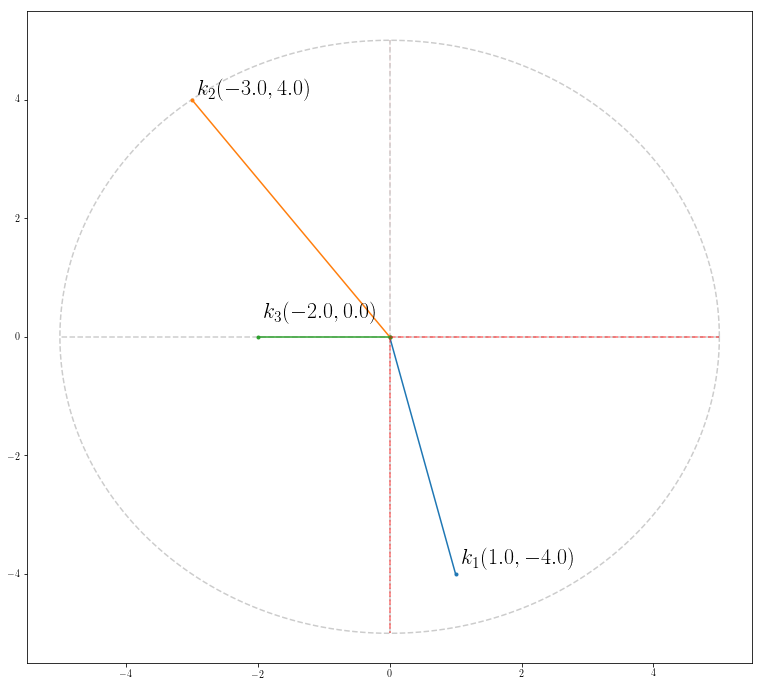

[ 4. -3. -4.  1.  0. -2.]


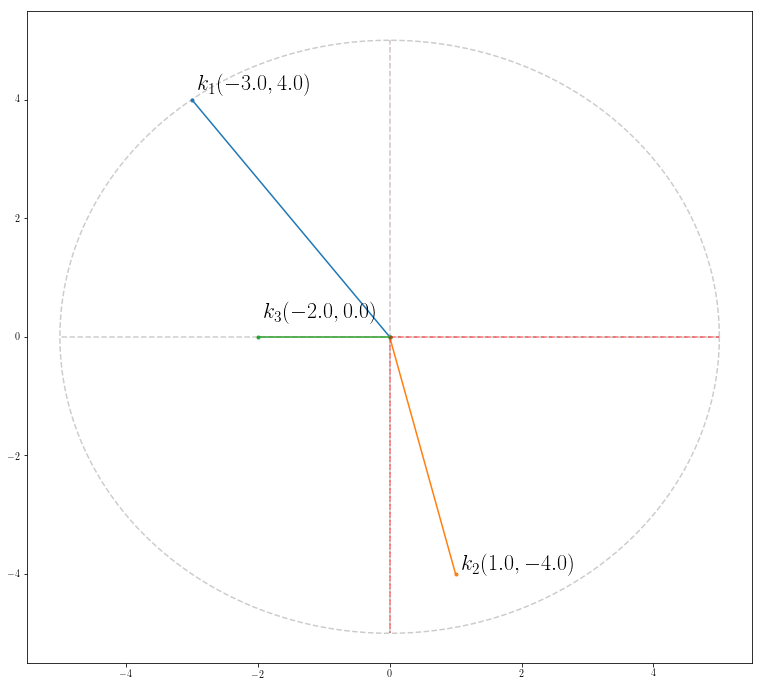

[-4.  1.  4. -2.  0. -1.]


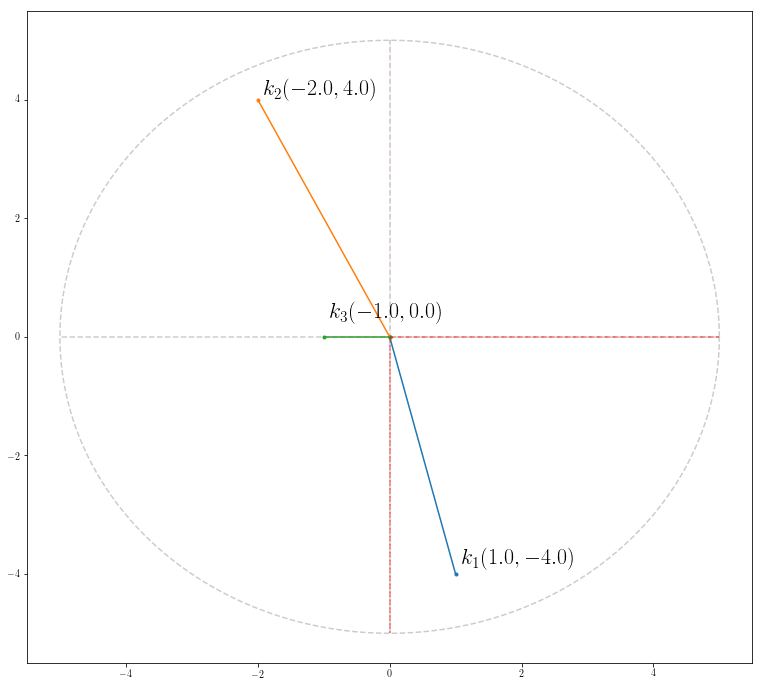

[-4.  2.  4. -3.  0. -1.]


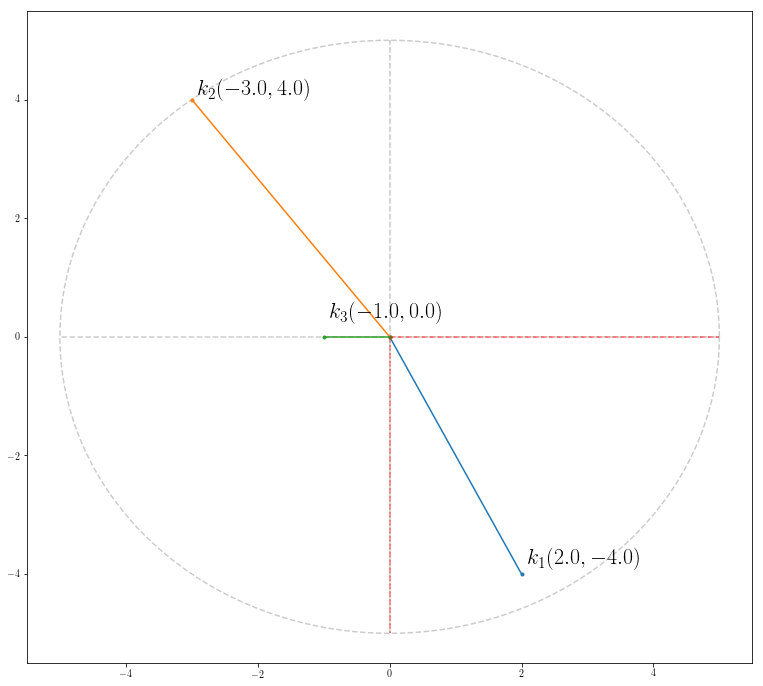

[-3.  3.  3. -4.  0. -1.]


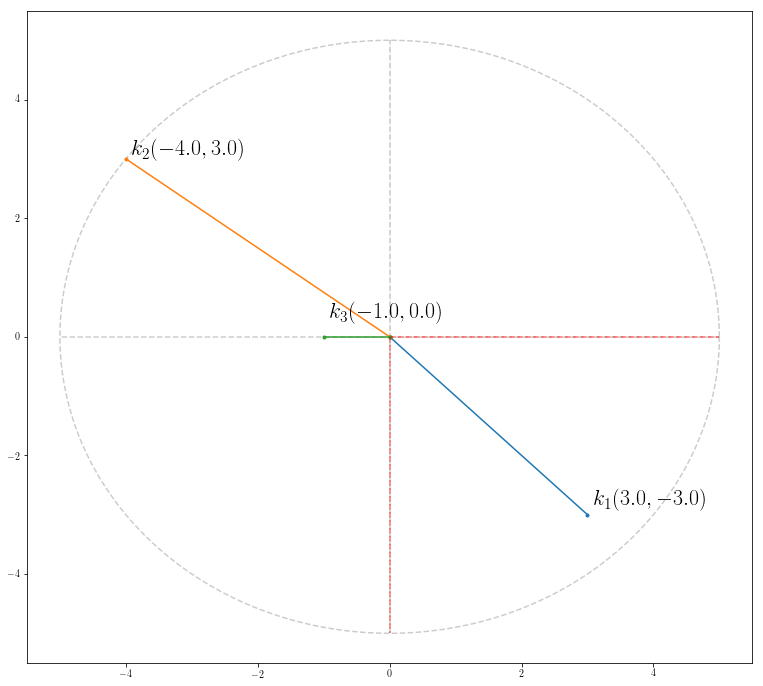

[ 3. -4. -3.  3.  0. -1.]


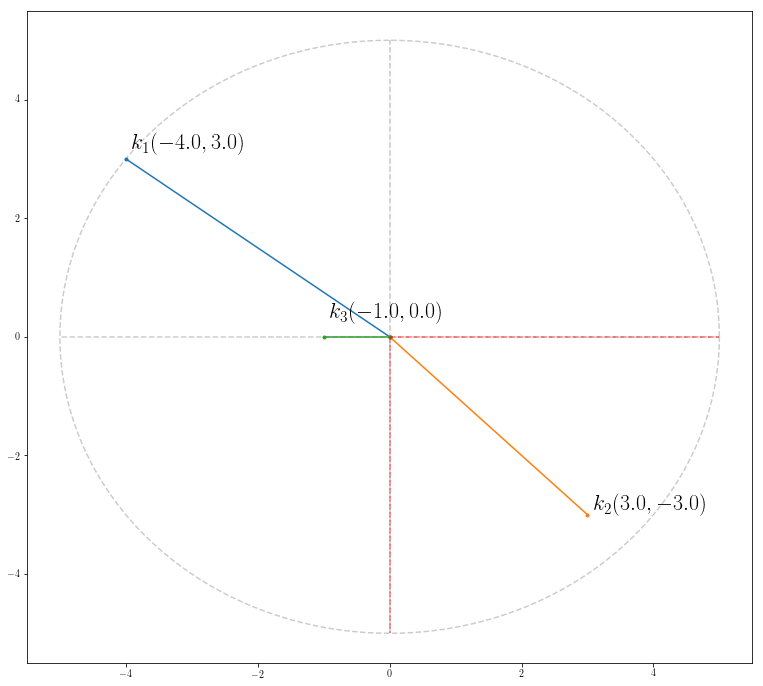

[ 4. -3. -4.  2.  0. -1.]


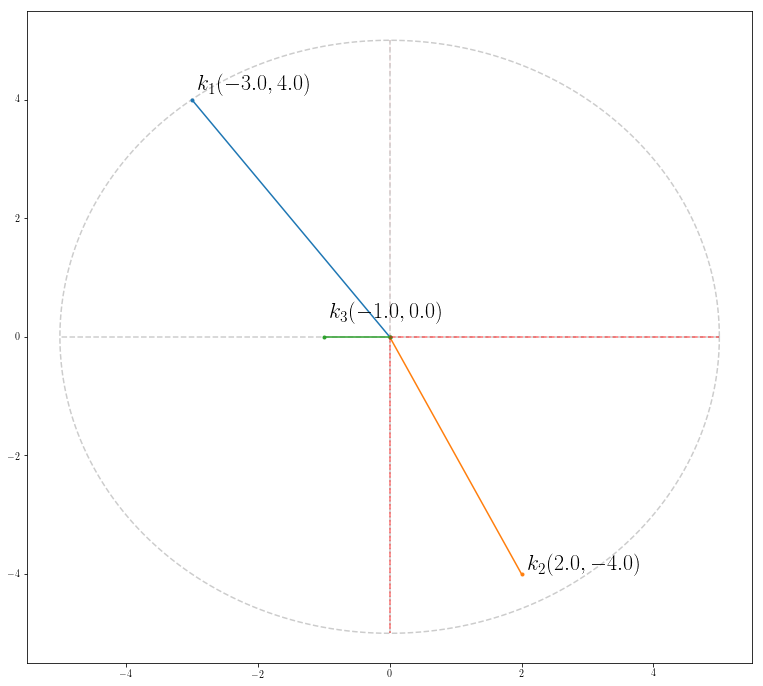

[ 4. -2. -4.  1.  0. -1.]


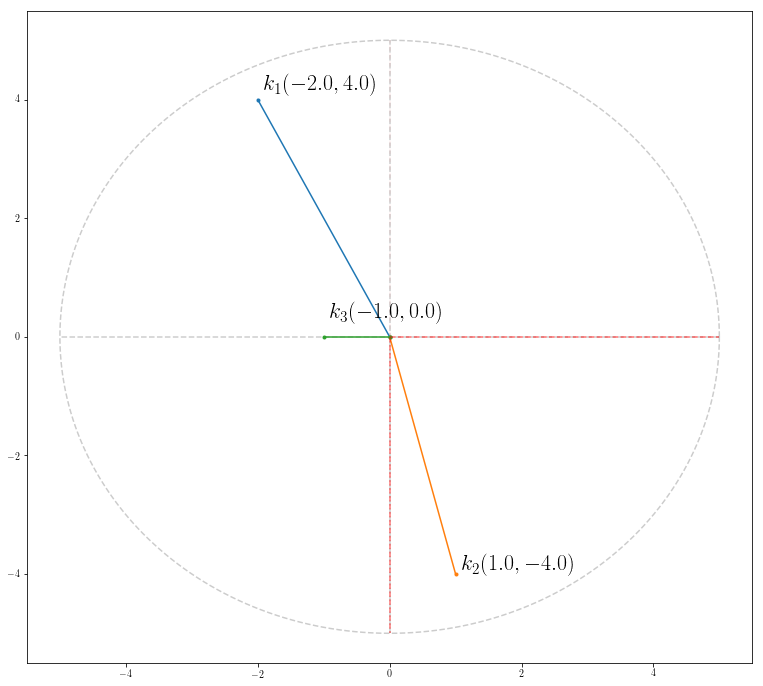

[-4.  2.  4. -1.  0.  1.]


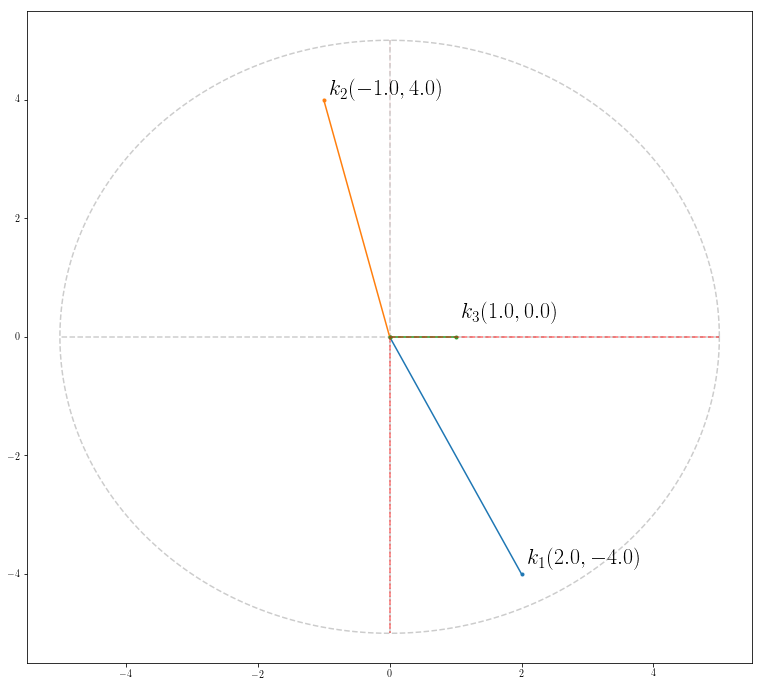

[-4.  3.  4. -2.  0.  1.]


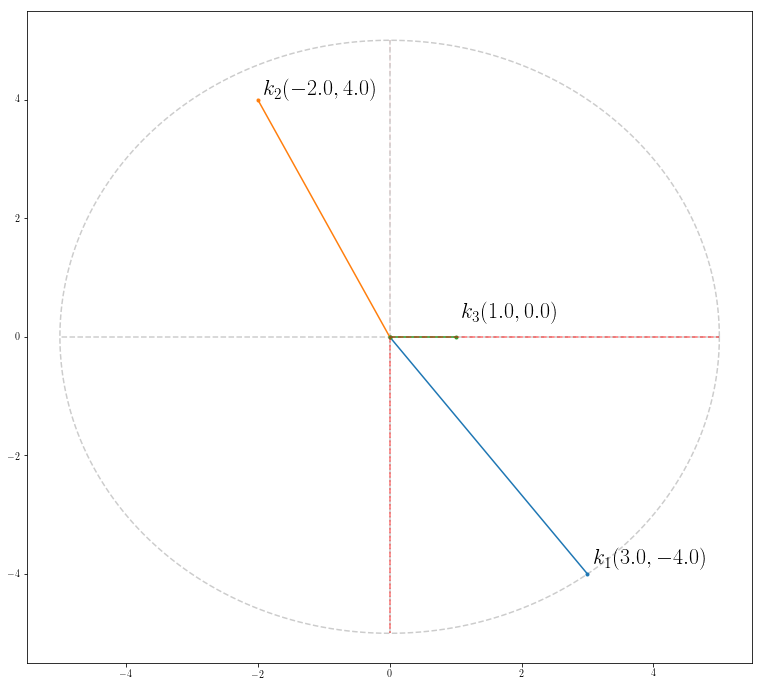

[-3.  4.  3. -3.  0.  1.]


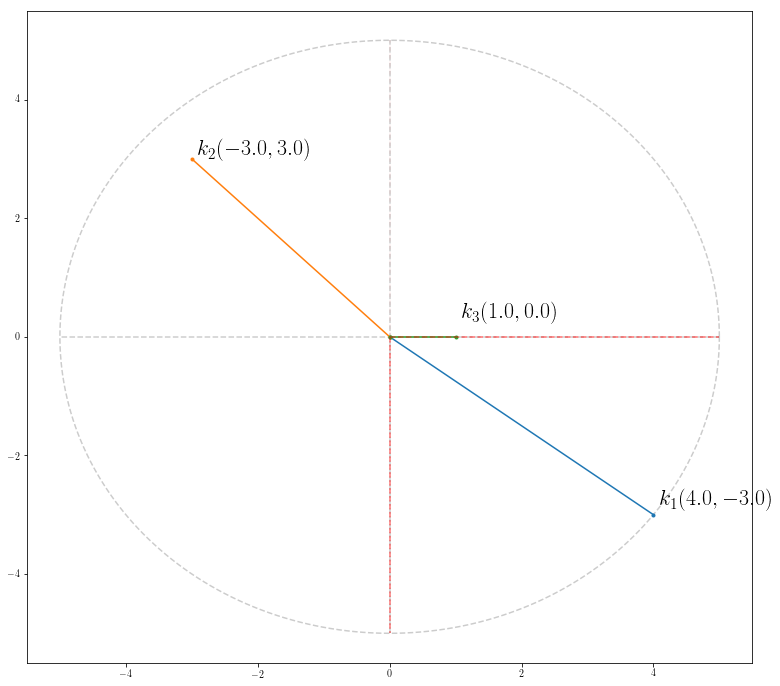

[ 3. -3. -3.  4.  0.  1.]


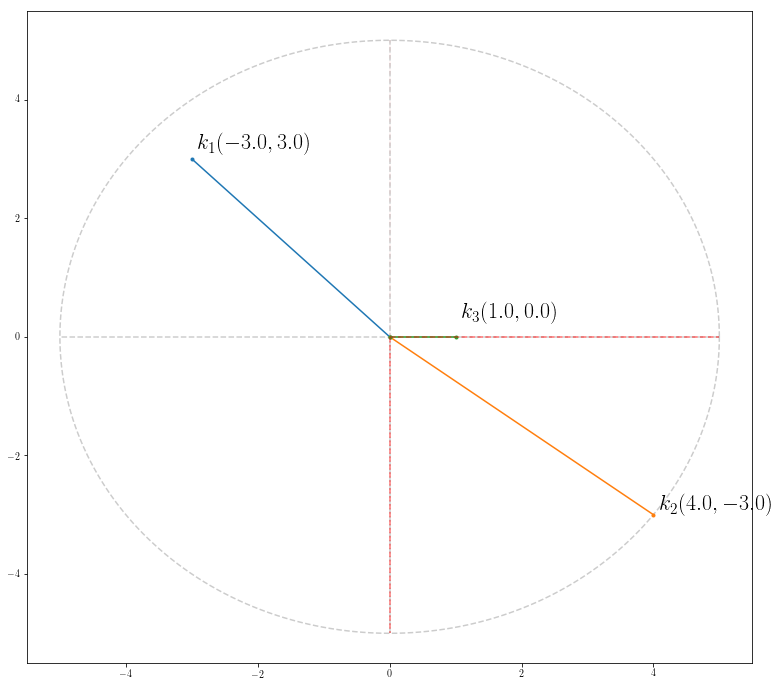

[ 4. -2. -4.  3.  0.  1.]


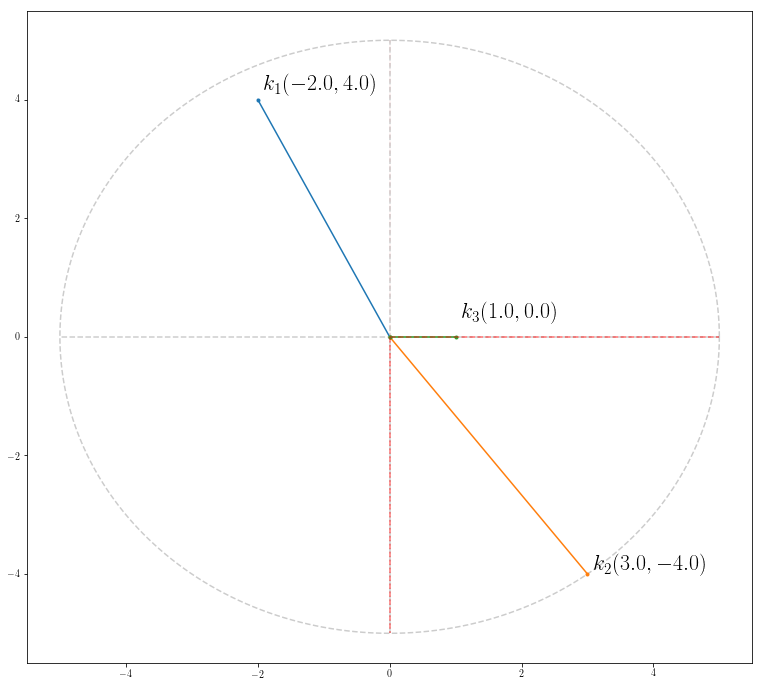

[ 4. -1. -4.  2.  0.  1.]


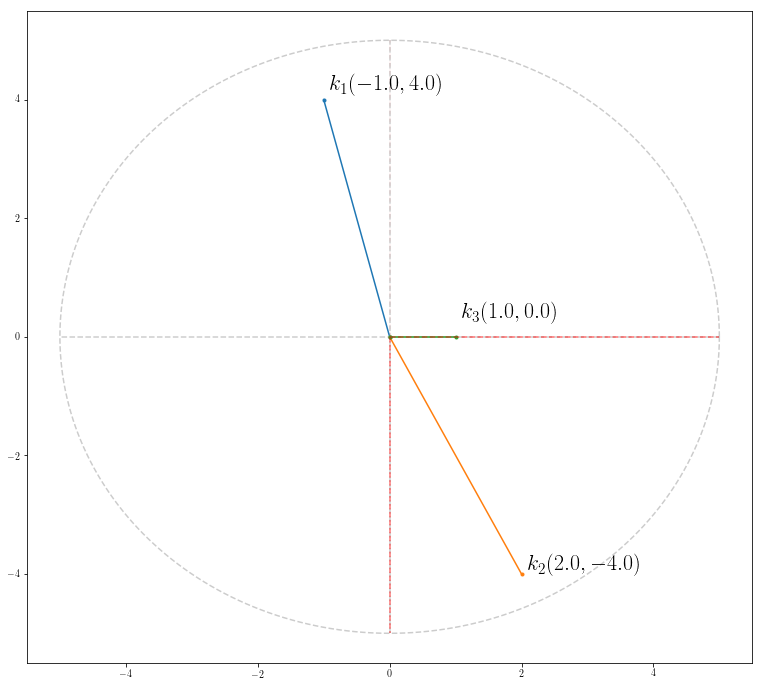

[-4.  3.  4. -1.  0.  2.]


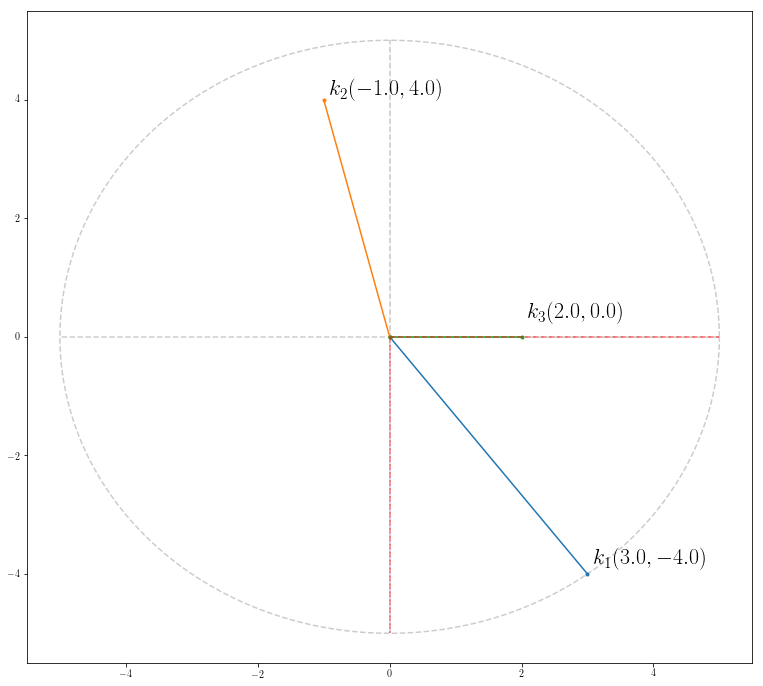

[ 4. -1. -4.  3.  0.  2.]


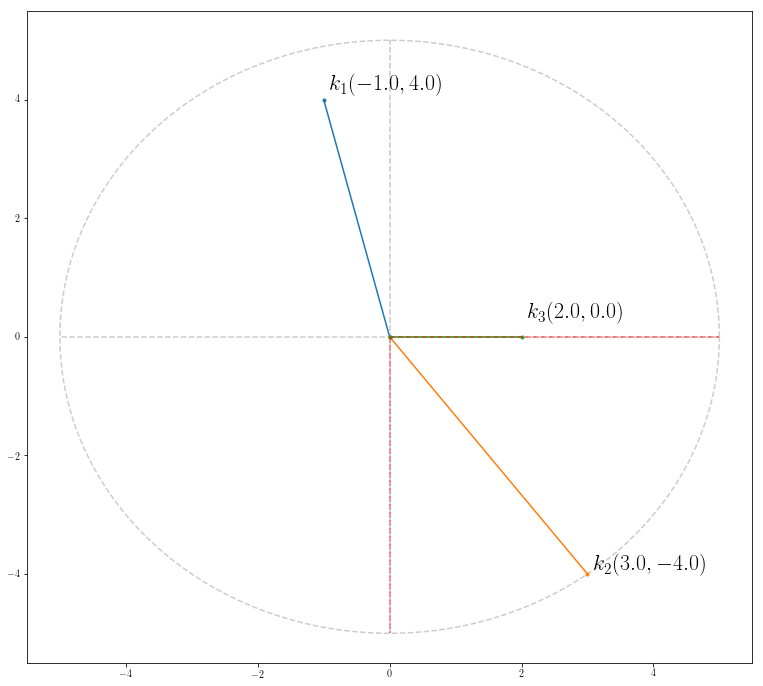

In [22]:

dsec = sector

n_theta   = post_data.num_sect
dtheta    =  np.pi / n_theta
theta     = np.arange(-np.pi/2, np.pi/2 + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

for i in mid_theta:
    print(i)
# for l in range(post_data.num_k1_sects):
#     print("\n\nl = {}".format(l))
for i, k_vec in enumerate(match[:]):
    print(k_vec)
    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
    p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], '.-', alpha = 1)
    p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], '.-', alpha = 1)
    p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
#         p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
#         p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
#         p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
    plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
    plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
    plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

    plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
    plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
#         plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
#         plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
    plt.show()

In [114]:
dsec = 0
sec_0 = dsec
sec = post_data.num_sect//2 + dsec
pos_present = []
neg_present = []
pos_missing = []
neg_missing = []
pos_missing_indices = []
neg_missing_indices = []

print("sec_0: {}\nsec_opp: {}".format(sec_0, sec))

for i in range(post_data.num_wv[sec_0, 0]):
    k3_x = post_data.wv[sec_0, 0, K3_X, i]
    k3_y = post_data.wv[sec_0, 0, K3_Y, i]
    print("i: {}\t - {} - {}\t {}".format(i, post_data.wv[sec_0, 0, :6, i], post_data.wv[sec, 0, :6, i], np.arctan2(k3_x, k3_y)))

for l in range(post_data.num_k1_sects):
    opp_sec_list = post_data.wv[sec, l, :6, :]
    sec_0_list   = post_data.wv[sec_0, l, :6, :]
    n = post_data.num_wv[sec_0, l]
    
    pos_present.append([])
    neg_present.append([])
    pos_missing.append([])
    neg_missing.append([])
    pos_missing_indices.append([])
    neg_missing_indices.append([])
    
    print("\n\nl = {}".format(l))
    print("\t\tPositive k Search\t\t\t-\t\t\tNegative k Search\t\t\t-\t\t\tNegative k Search")
    for i in range(n):
        k_sec_0   = post_data.wv[sec_0, l, :6, i]
        k_sec_opp = post_data.wv[sec, l, :6, i]
        pos_k_sear = pos_k_search(k_sec_0, opp_sec_list)
#         if pos_k_sear[0] == False:
#             pos_missing_indices[l].append(i)
#             pos_missing[l].append(pos_k_sear[-1])

        neg_k_sear = neg_k_search(k_sec_0, opp_sec_list)
        if neg_k_sear[0] == False:
            neg_missing_indices[l].append(i)
            neg_missing[l].append(neg_k_sear[-1])

        neg_k_sear_sec = neg_k_search(k_sec_opp, sec_0_list)
        if neg_k_sear_sec[0] == False:
            neg_missing[l].append(neg_k_sear_sec[-1])
        pos_present[l].append(pos_k_sear)
        neg_present[l].append(neg_k_sear)
        print("i: {}\t{}\t-\t{}\t-\t{}".format(i, pos_k_sear, neg_k_sear, neg_k_sear_sec)) 
    print()
    print("Pos match: {}".format(np.all(np.asarray(np.asarray(pos_present[l])[:, 0]))))
    print("Neg match: {}".format(np.all(np.asarray(np.asarray(neg_present[l])[:, 0]))))

sec_0: 0
sec_opp: 2
i: 0	 - [-3.  1. -1.  0. -4.  1.] - [-2. -3. -1. -1. -3. -4.]	 -1.3258176636680326
i: 1	 - [-3.  2. -1. -1. -4.  1.] - [-2. -2. -1. -2. -3. -4.]	 -1.3258176636680326
i: 2	 - [-3.  4. -1. -3. -4.  1.] - [-1. -3. -2. -1. -3. -4.]	 -1.3258176636680326
i: 3	 - [-2.  1. -2.  0. -4.  1.] - [-1. -2. -2. -2. -3. -4.]	 -1.3258176636680326
i: 4	 - [-2.  2. -2. -1. -4.  1.] - [-1. -1. -2. -3. -3. -4.]	 -1.3258176636680326
i: 5	 - [-2.  3. -2. -2. -4.  1.] - [ 1. -2. -4. -2. -3. -4.]	 -1.3258176636680326
i: 6	 - [-2.  4. -2. -3. -4.  1.] - [ 1. -1. -4. -3. -3. -4.]	 -1.3258176636680326
i: 7	 - [-1.  1. -3.  0. -4.  1.] - [ 2. -4. -5.  0. -3. -4.]	 -1.3258176636680326
i: 8	 - [-1.  2. -3. -1. -4.  1.] - [-3.  2.  0. -5. -3. -3.]	 -1.3258176636680326
i: 9	 - [-3.  1. -1.  1. -4.  2.] - [-2. -3. -1.  0. -3. -3.]	 -1.1071487177940904
i: 10	 - [-3.  2. -1.  0. -4.  2.] - [-2. -2. -1. -1. -3. -3.]	 -1.1071487177940904
i: 11	 - [-3.  4. -1. -2. -4.  2.] - [-1. -3. -2.  0. -3. -3.]	 -1

In [16]:
print(wv[sec_0][:6, :].shape)
print(wv[sec][:6, :].shape)
for i in range(n):
    k_dsec = wv[sec_0][:6, i]
    k_sec = wv[sec][:6, i]
    print(k_sec)

NameError: name 'wv' is not defined

In [38]:
print(wv_1.shape)
print(wv_1[0, 0, :6, :])

print(np.sum(post_data.num_wv))
combined = np.zeros((6, np.sum(post_data.num_wv)))
nn = 0
for i in range(post_data.num_sect):
    for j in range(post_data.num_k1_sects):
        for n in range(post_data.num_wv[i, j]):
            combined[:, nn] = post_data.wv[i, 0, :6, n]
            nn += 1

missing_first_pass = []
for i in range(num_wv_1[0,0]):
    k_vec = wv_1[0, 0, :6, i]
    res = k_search(k_vec, combined[:])
    if res[0] == False:
        missing_first_pass.append(k_vec)
    print("i: {}\t{}".format(i, res))
print(len(missing_first_pass))

(1, 1, 16, 752)
[[-4. -3. -3. ...  3.  3.  4.]
 [ 0. -2. -1. ...  1.  2.  0.]
 [-1. -2. -2. ...  2.  2.  1.]
 [ 0.  2.  1. ... -1. -2.  0.]
 [-5. -5. -5. ...  5.  5.  5.]
 [ 0.  0.  0. ...  0.  0.  0.]]
664
i: 0	(True, 0, array([-4.,  0., -1.,  0., -5.,  0.]))
i: 1	(True, 4, array([-3., -2., -2.,  2., -5.,  0.]))
i: 2	(True, 5, array([-3., -1., -2.,  1., -5.,  0.]))
i: 3	(True, 6, array([-3.,  0., -2.,  0., -5.,  0.]))
i: 4	(True, 7, array([-3.,  1., -2., -1., -5.,  0.]))
i: 5	(True, 8, array([-3.,  2., -2., -2., -5.,  0.]))
i: 6	(True, 11, array([-2., -2., -3.,  2., -5.,  0.]))
i: 7	(True, 12, array([-2., -1., -3.,  1., -5.,  0.]))
i: 8	(True, 13, array([-2.,  0., -3.,  0., -5.,  0.]))
i: 9	(True, 14, array([-2.,  1., -3., -1., -5.,  0.]))
i: 10	(True, 15, array([-2.,  2., -3., -2., -5.,  0.]))
i: 11	(True, 19, array([-1.,  0., -4.,  0., -5.,  0.]))
i: 12	(True, 20, array([-4.,  0.,  0., -3., -4., -3.]))
i: 13	(True, 23, array([-3., -2., -1., -1., -4., -3.]))
i: 14	(True, 24, array([-

In [40]:
for i in range(10):
    print(missing_first_pass[i])

[-3. -4. -1.  4. -4.  0.]
[-3.  4. -1. -4. -4.  0.]
[-2. -4. -2.  4. -4.  0.]
[-2.  4. -2. -4. -4.  0.]
[-1. -4. -3.  4. -4.  0.]
[-1.  4. -3. -4. -4.  0.]
[-4.  2.  1. -4. -3. -2.]
[-3.  3.  0. -5. -3. -2.]
[ 0. -5. -3.  3. -3. -2.]
[ 1. -4. -4.  2. -3. -2.]


In [11]:
## Get sector lists
sec_0_0 = wv_2[0, 0, :6, :]
sec_1_0 = wv_2[1, 0, :6, :]

print(num_wv_1[0][0])

miss_first_pass = []
for i in range(num_wv_1[0][0]):
               
    ## Choose k_vec to search sector lists with
    k_vec = wv_1[0, 0, :6, i]
    
    ## Search
    k_search_0 = k_search(k_vec, sec_0_0)
    k_search_1 = k_search(k_vec, sec_1_0)   
    if k_search_0[0] == False and k_search_1[0] == False:
        miss_first_pass.append(k_vec)
        
    ## Print results
#     print("i: {}\t{}\t-\t{}".format(i, k_search_0, ())) 
#     print("i: {}\t{}\t-\t{}".format(i, k_search_0, k_search_1)) 

# fully_missing = []
for i, k in enumerate(miss_first_pass):
#     k_search_1 = k_search(k, sec_1_0)
#     if k_search_1[0] == False:
#         fully_missing.append(k_search_1[-1])
    print(i, k)

# for i, k in enumerate(fully_missing):
#     print(i, k)

276
0 [-3.  1.  1. -3. -2. -2.]
1 [ 1. -3. -3.  1. -2. -2.]
2 [-3.  2.  1. -3. -2. -1.]
3 [-2.  3.  0. -4. -2. -1.]
4 [ 0. -4. -2.  3. -2. -1.]
5 [ 1. -3. -3.  2. -2. -1.]
6 [-3. -2.  1.  3. -2.  1.]
7 [ 1.  3. -3. -2. -2.  1.]
8 [-3. -1.  1.  3. -2.  2.]
9 [ 1.  3. -3. -1. -2.  2.]
10 [-4.  0.  3. -2. -1. -2.]
11 [-3.  1.  2. -3. -1. -2.]
12 [ 2. -3. -3.  1. -1. -2.]
13 [ 3. -2. -4.  0. -1. -2.]
14 [-4.  0.  3. -1. -1. -1.]
15 [-3.  2.  2. -3. -1. -1.]
16 [-1.  3.  0. -4. -1. -1.]
17 [ 0. -4. -1.  3. -1. -1.]
18 [ 2. -3. -3.  2. -1. -1.]
19 [ 3. -1. -4.  0. -1. -1.]
20 [-2. -3.  1.  3. -1.  0.]
21 [-2.  3.  1. -3. -1.  0.]
22 [ 1. -3. -2.  3. -1.  0.]
23 [ 1.  3. -2. -3. -1.  0.]
24 [-4.  0.  3.  1. -1.  1.]
25 [-3. -2.  2.  3. -1.  1.]
26 [ 2.  3. -3. -2. -1.  1.]
27 [ 3.  1. -4.  0. -1.  1.]
28 [-4.  0.  3.  2. -1.  2.]
29 [-3. -1.  2.  3. -1.  2.]
30 [ 2.  3. -3. -1. -1.  2.]
31 [ 3.  2. -4.  0. -1.  2.]
32 [-3. -2.  3. -1.  0. -3.]
33 [-3. -1.  3. -2.  0. -3.]
34 [ 3. -2. -3. -1. 

[-3.  1.  1. -3. -2. -2.]


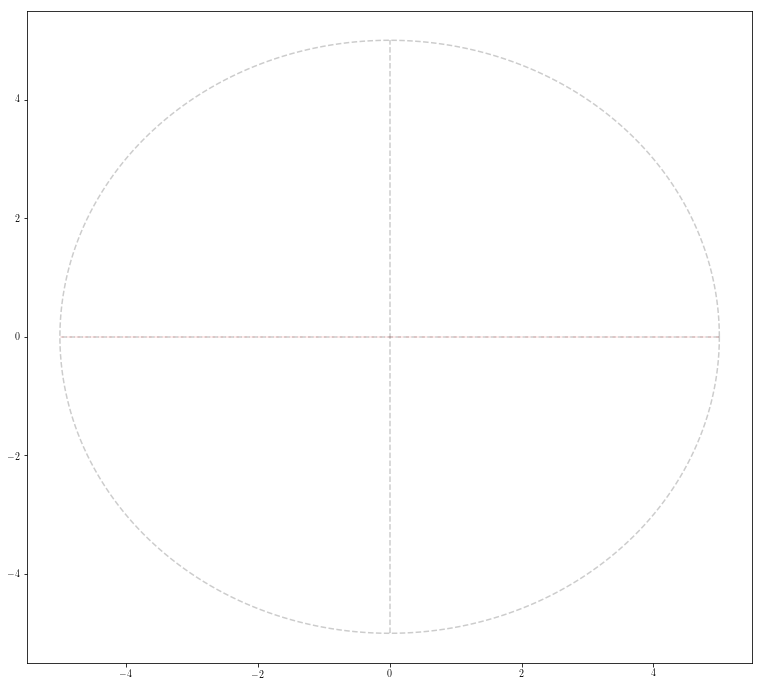

[ 1. -3. -3.  1. -2. -2.]


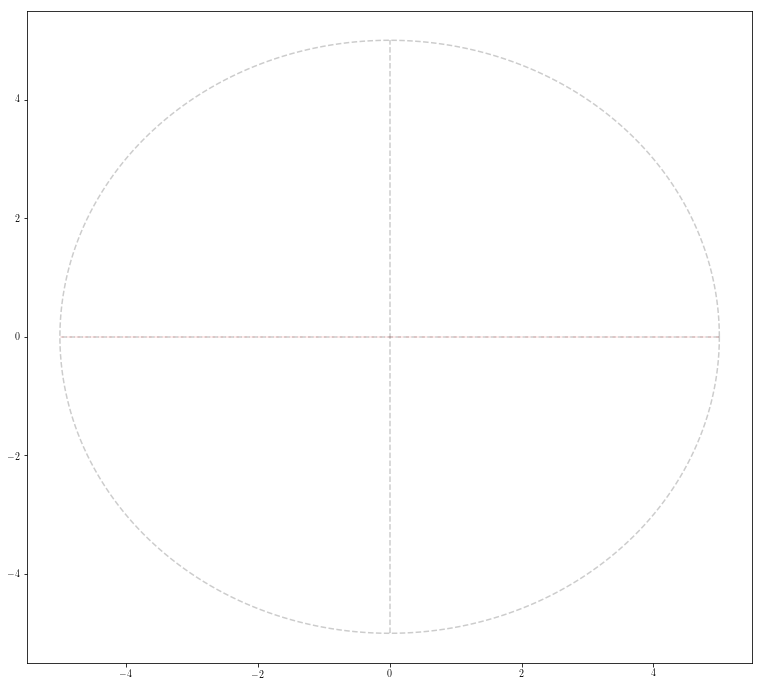

[-3.  2.  1. -3. -2. -1.]


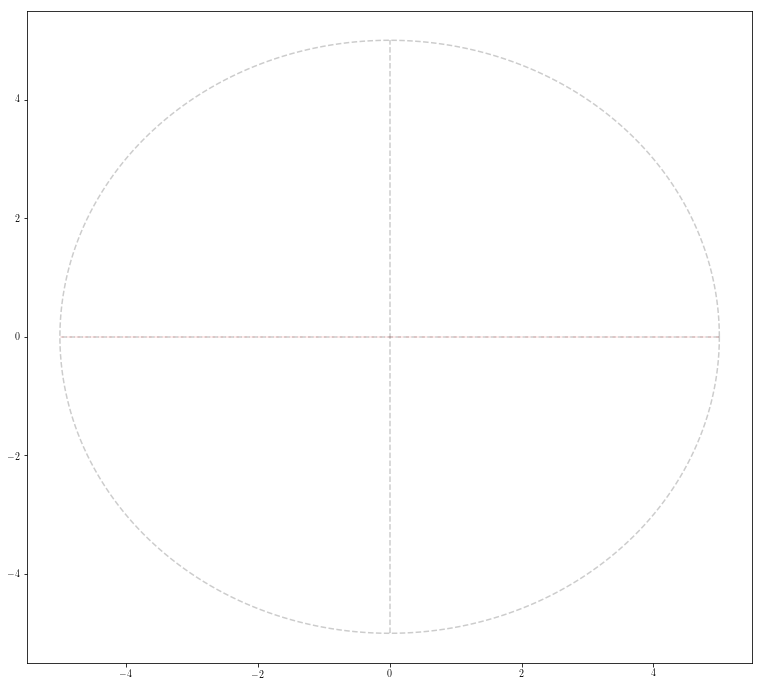

[-2.  3.  0. -4. -2. -1.]


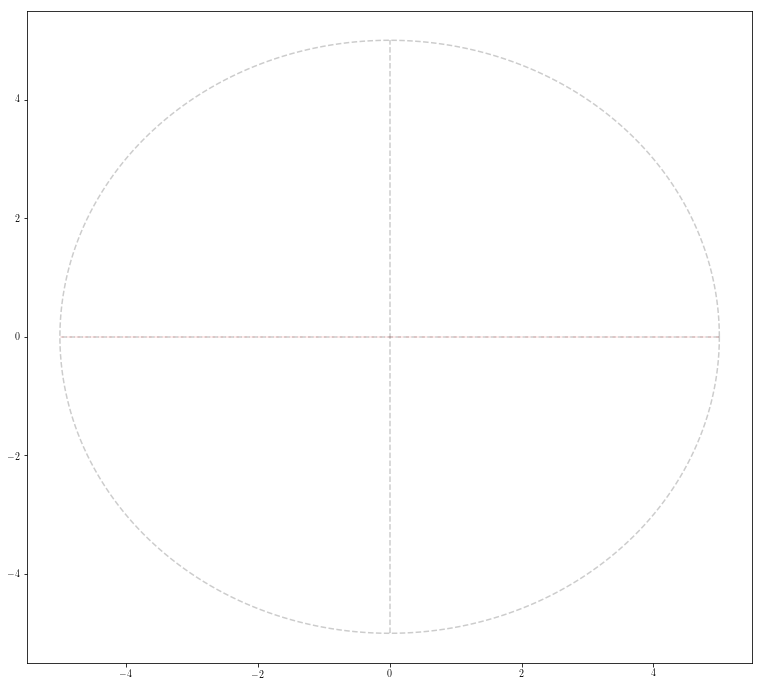

[ 0. -4. -2.  3. -2. -1.]


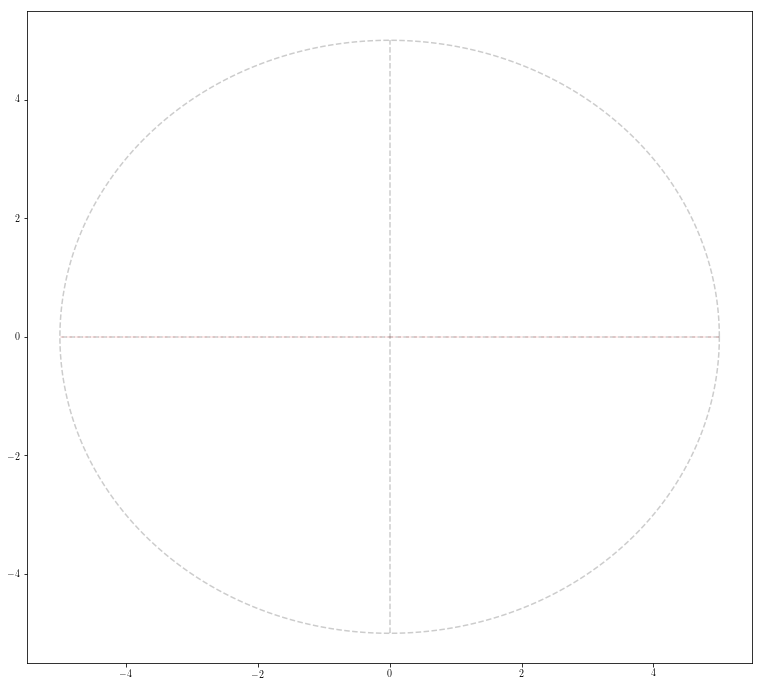

[ 1. -3. -3.  2. -2. -1.]


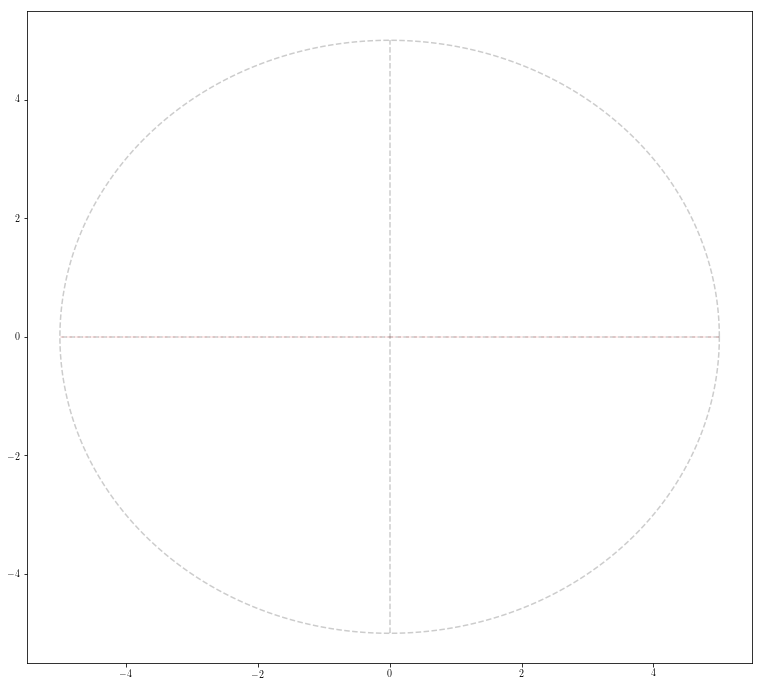

[-3. -2.  1.  3. -2.  1.]


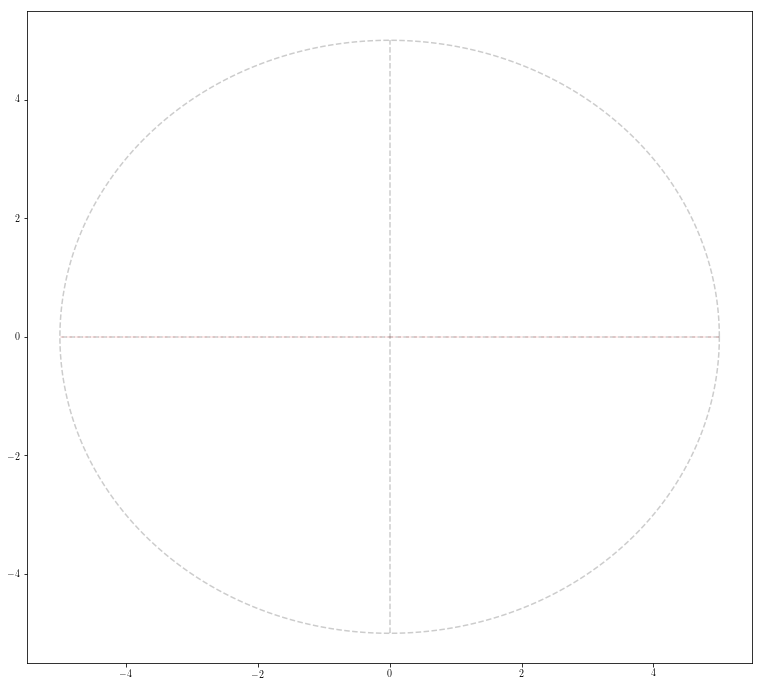

[ 1.  3. -3. -2. -2.  1.]


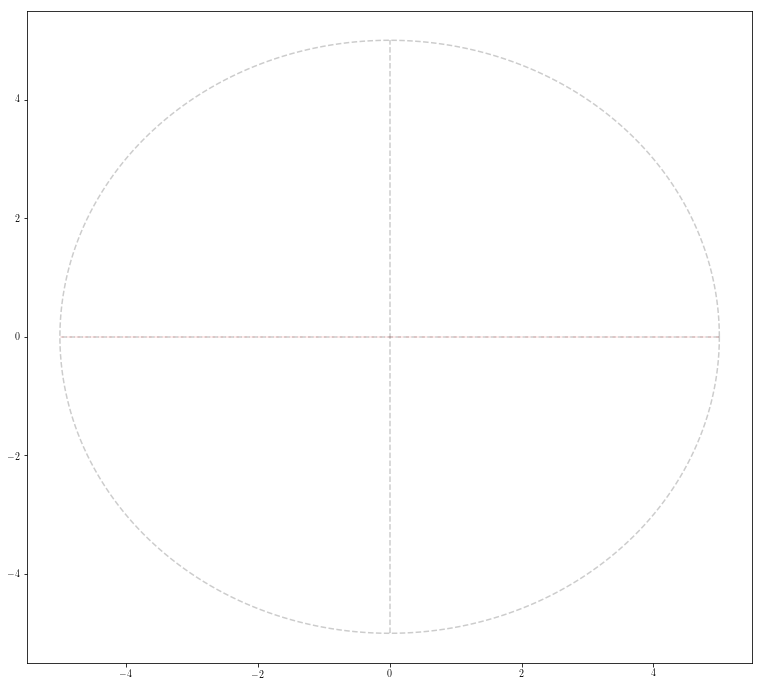

[-3. -1.  1.  3. -2.  2.]


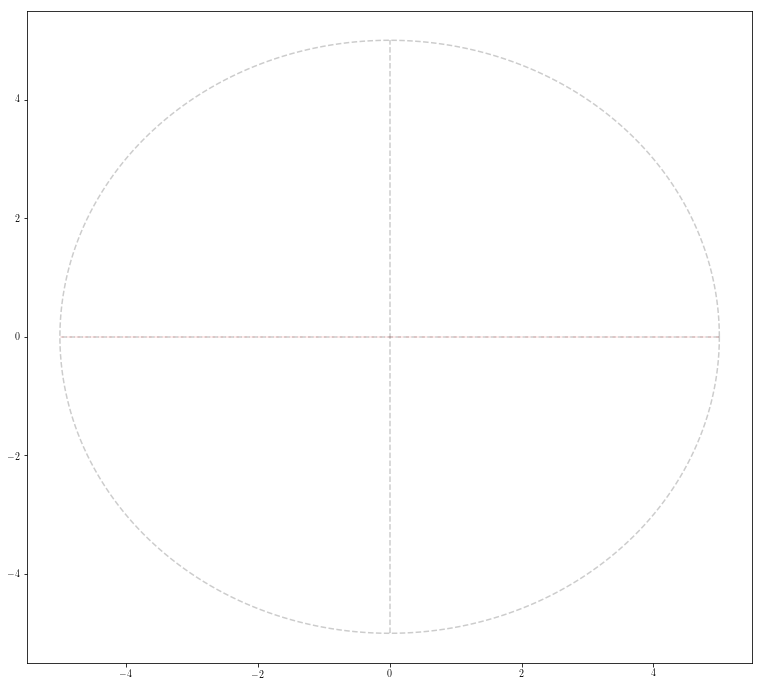

[ 1.  3. -3. -1. -2.  2.]


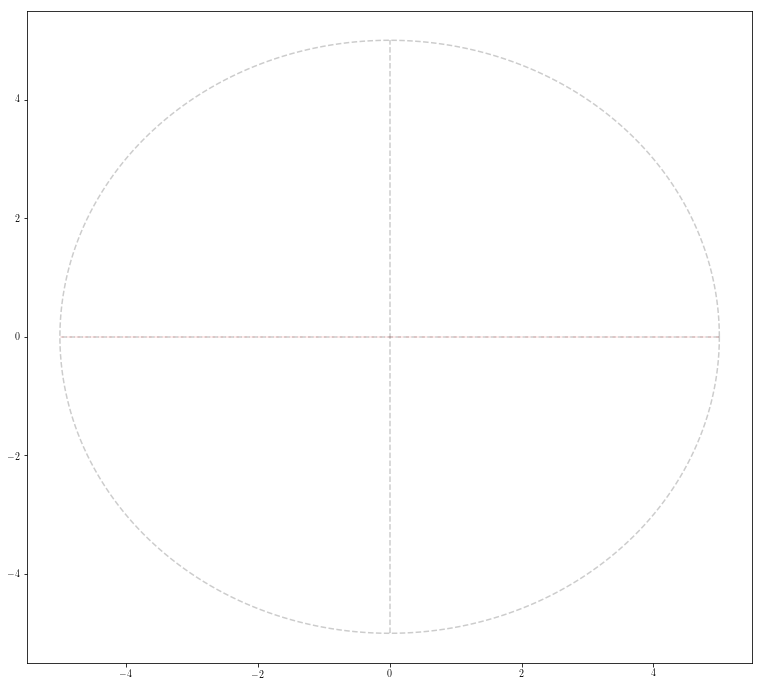

[-4.  0.  3. -2. -1. -2.]


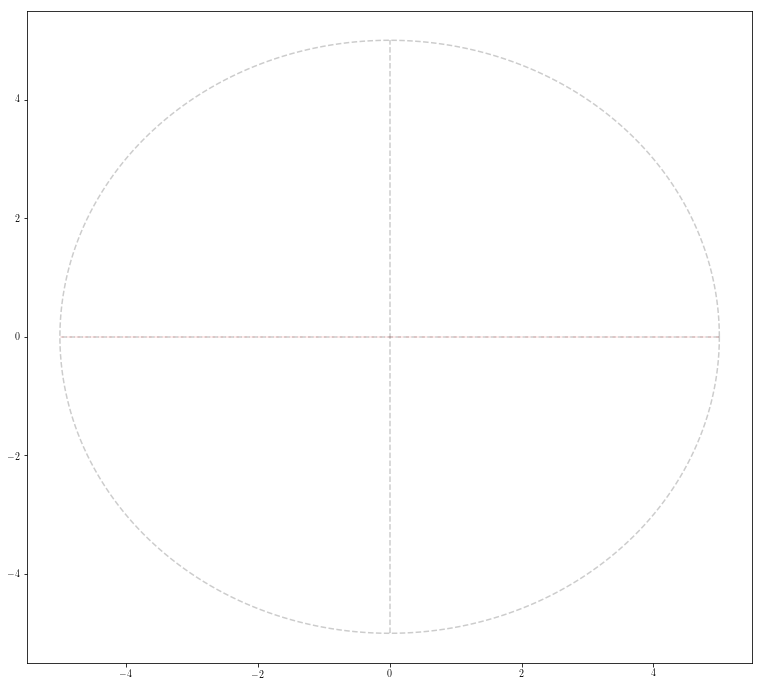

[-3.  1.  2. -3. -1. -2.]


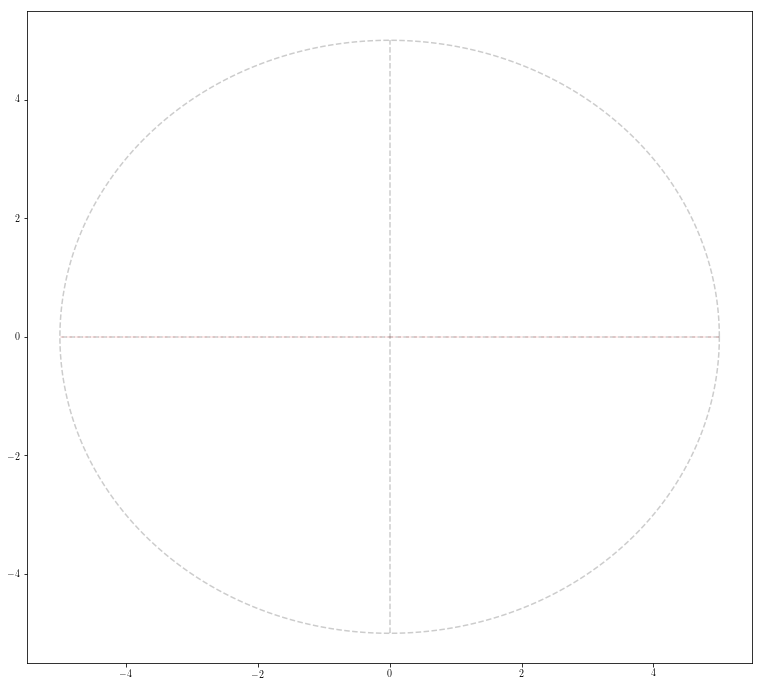

[ 2. -3. -3.  1. -1. -2.]


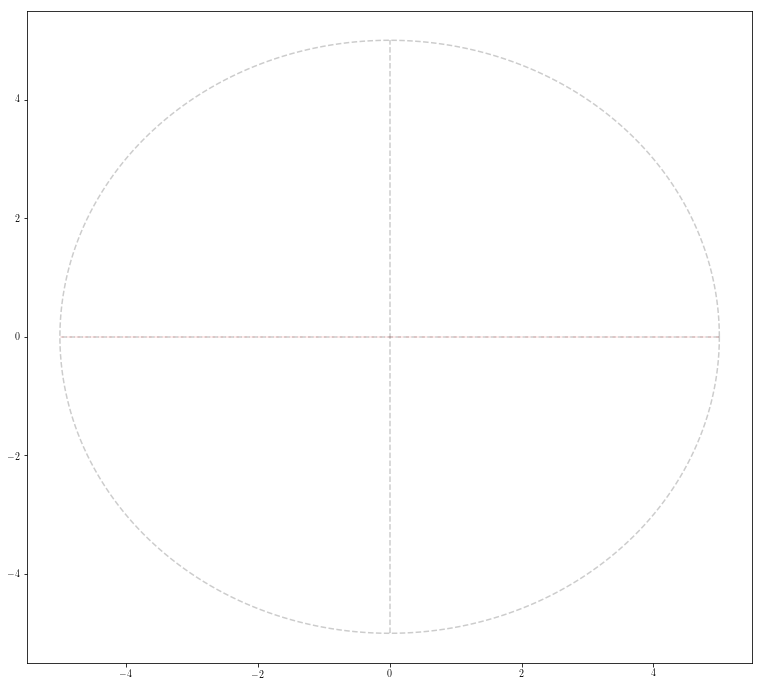

[ 3. -2. -4.  0. -1. -2.]


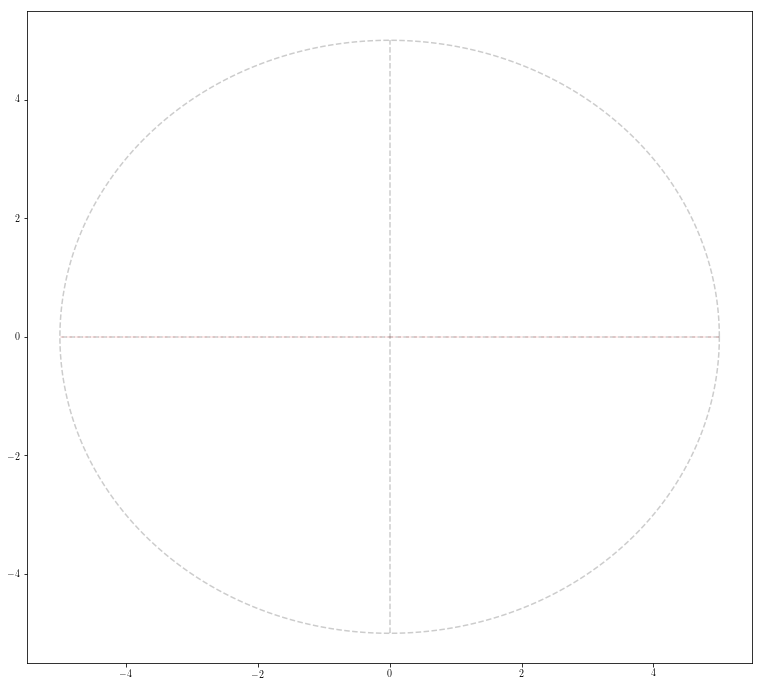

[-4.  0.  3. -1. -1. -1.]


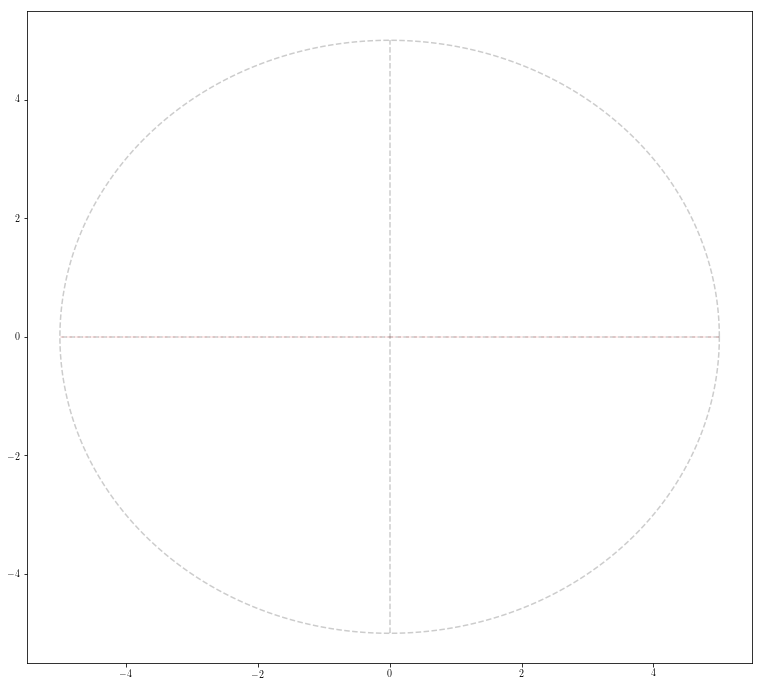

[-3.  2.  2. -3. -1. -1.]


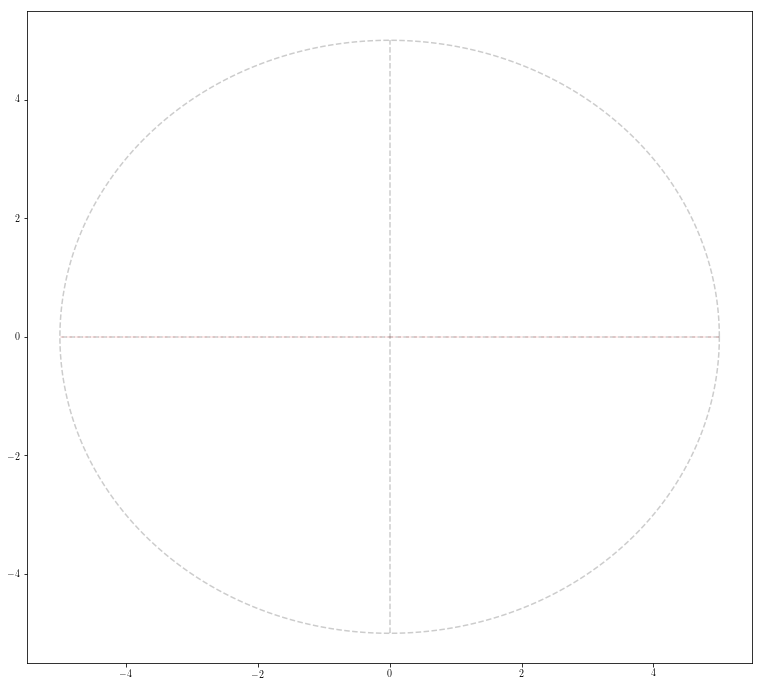

[-1.  3.  0. -4. -1. -1.]


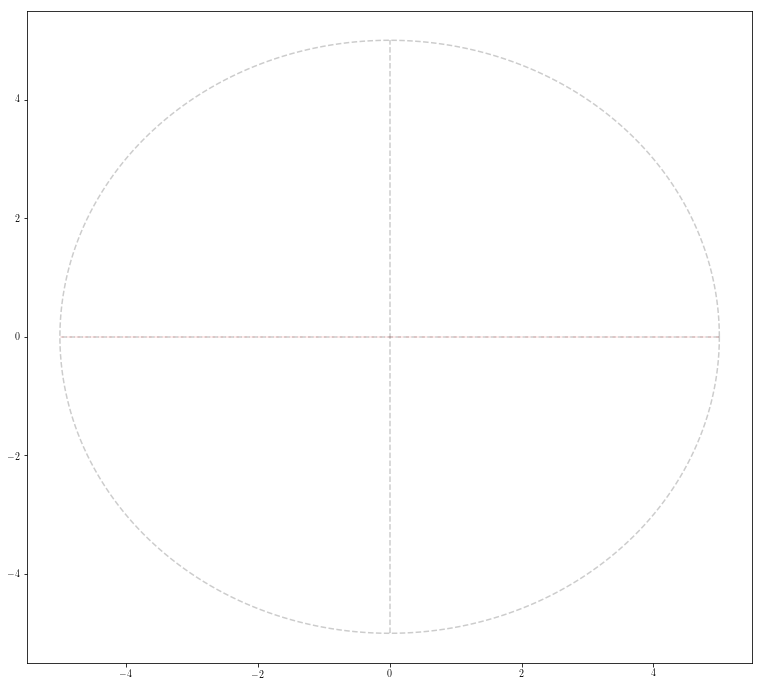

[ 0. -4. -1.  3. -1. -1.]


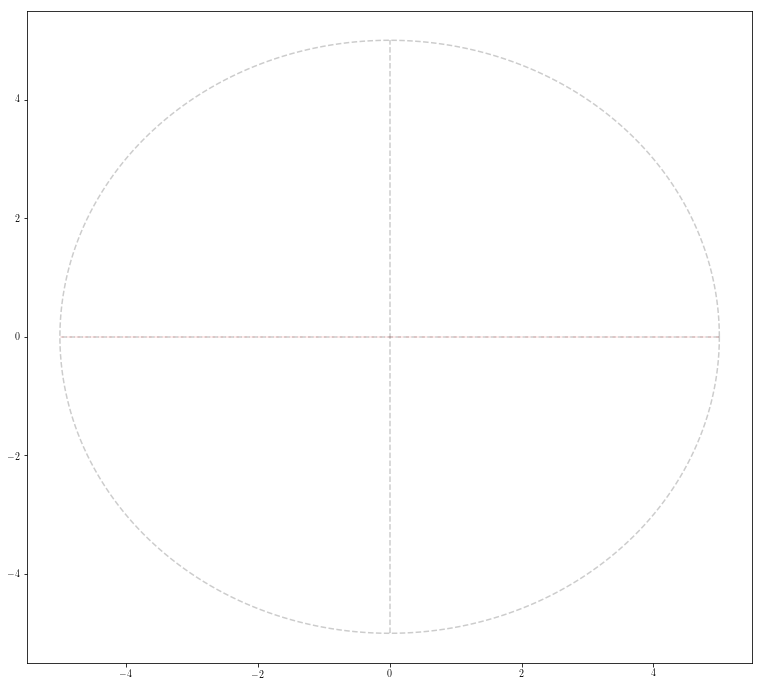

[ 2. -3. -3.  2. -1. -1.]


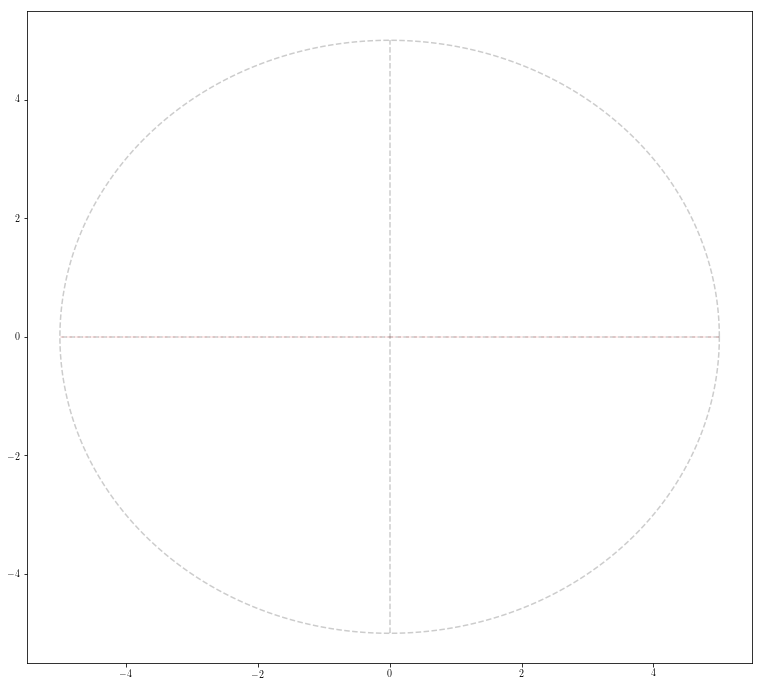

[ 3. -1. -4.  0. -1. -1.]


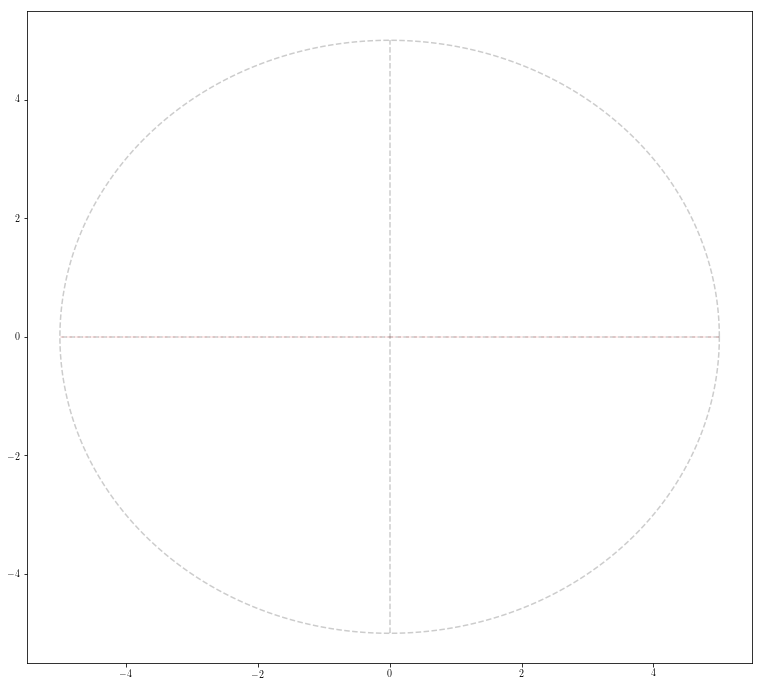

[-2. -3.  1.  3. -1.  0.]


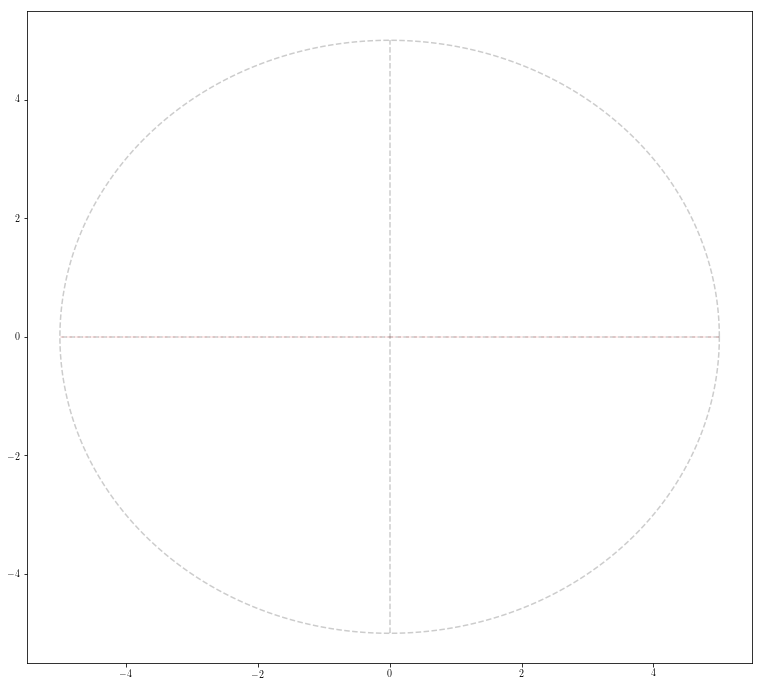

[-2.  3.  1. -3. -1.  0.]


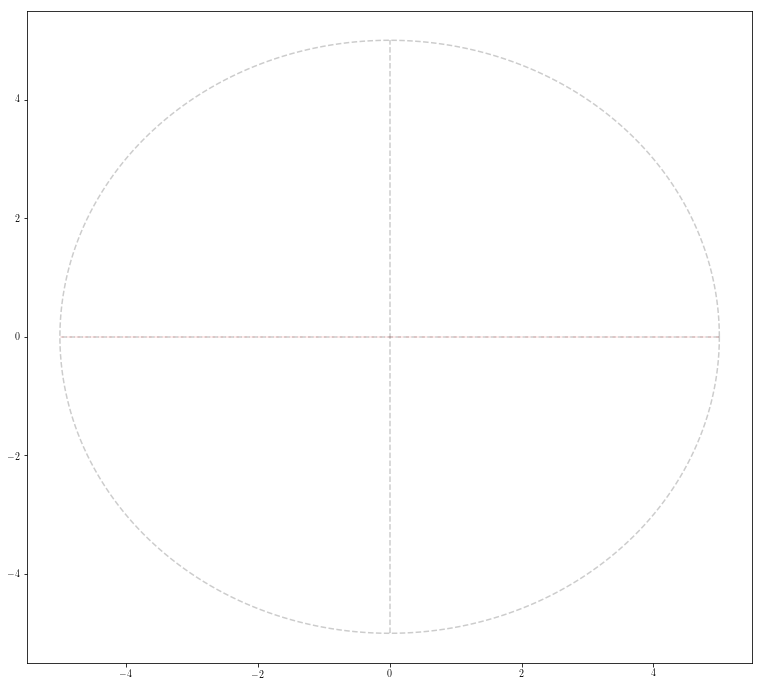

[ 1. -3. -2.  3. -1.  0.]


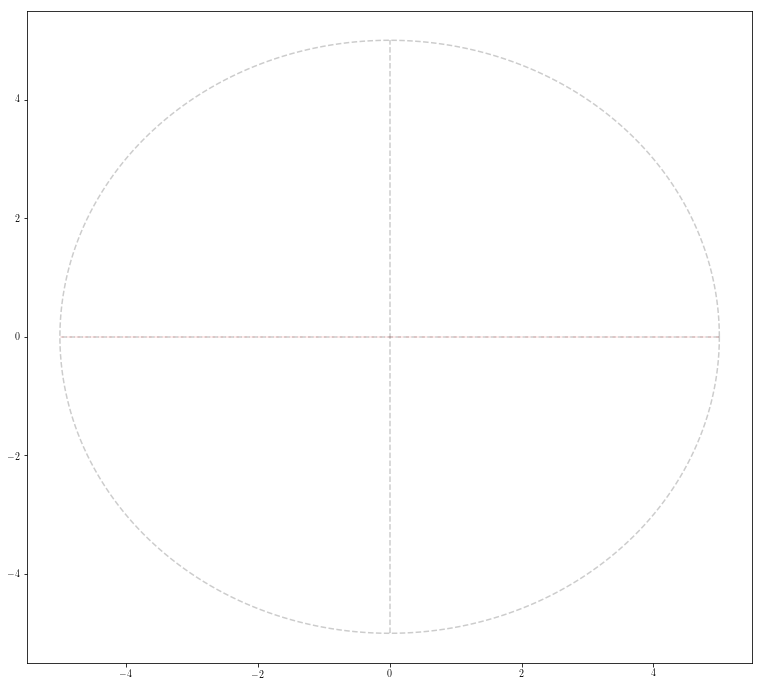

[ 1.  3. -2. -3. -1.  0.]


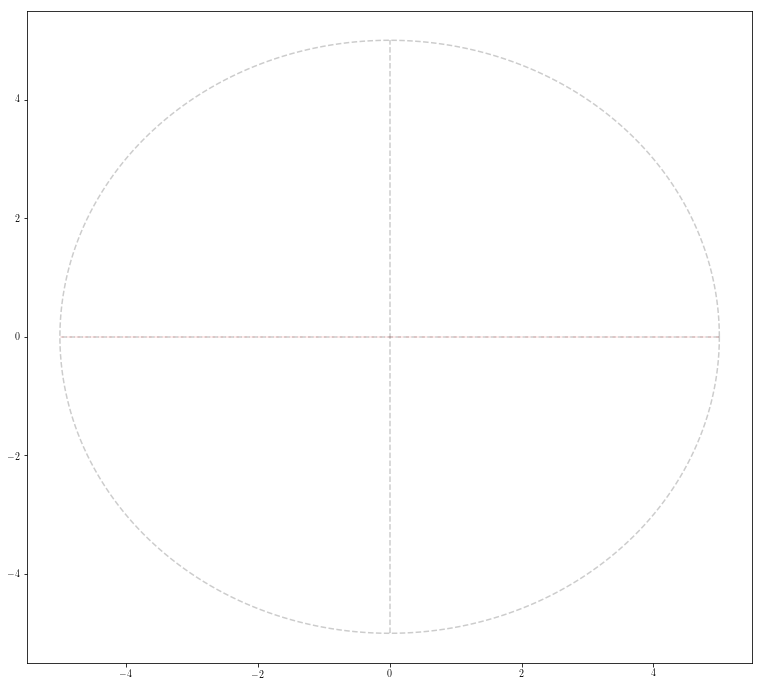

[-4.  0.  3.  1. -1.  1.]


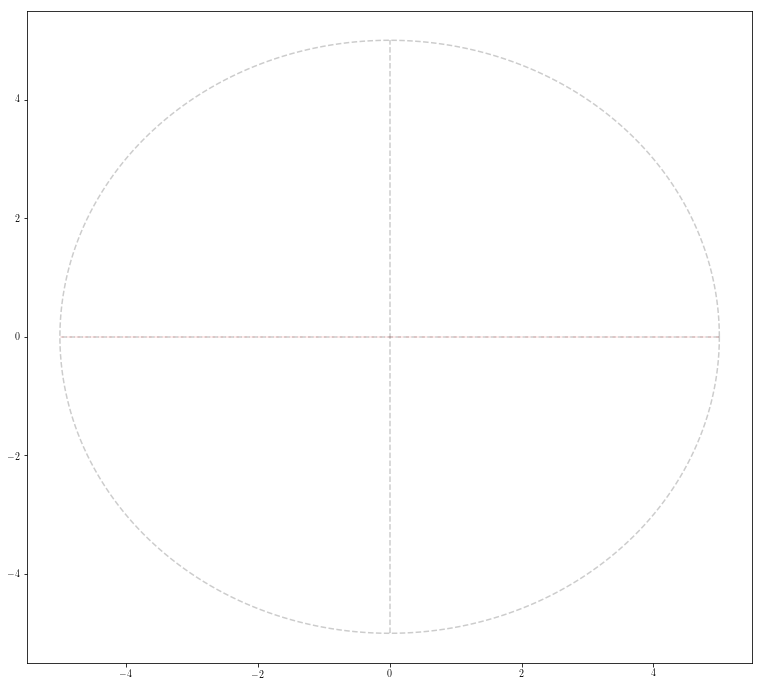

[-3. -2.  2.  3. -1.  1.]


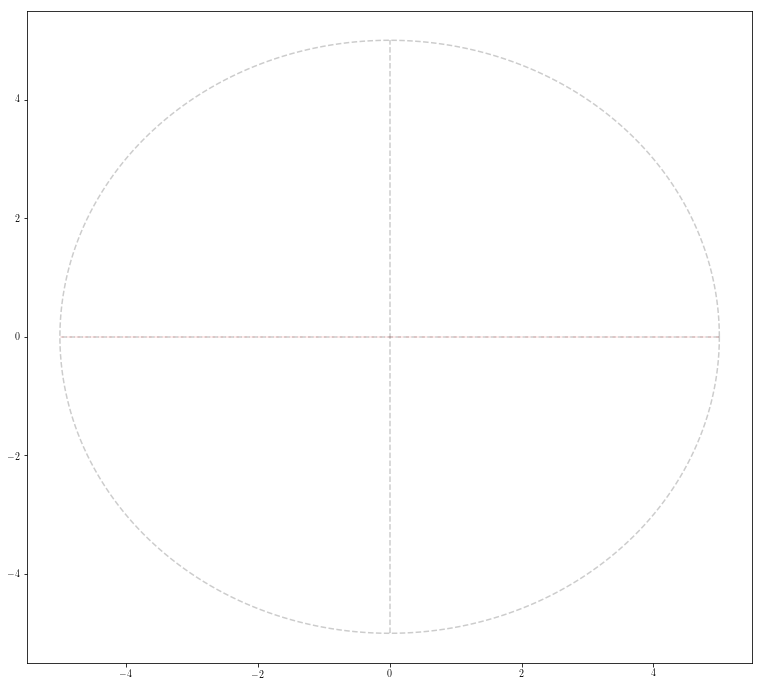

[ 2.  3. -3. -2. -1.  1.]


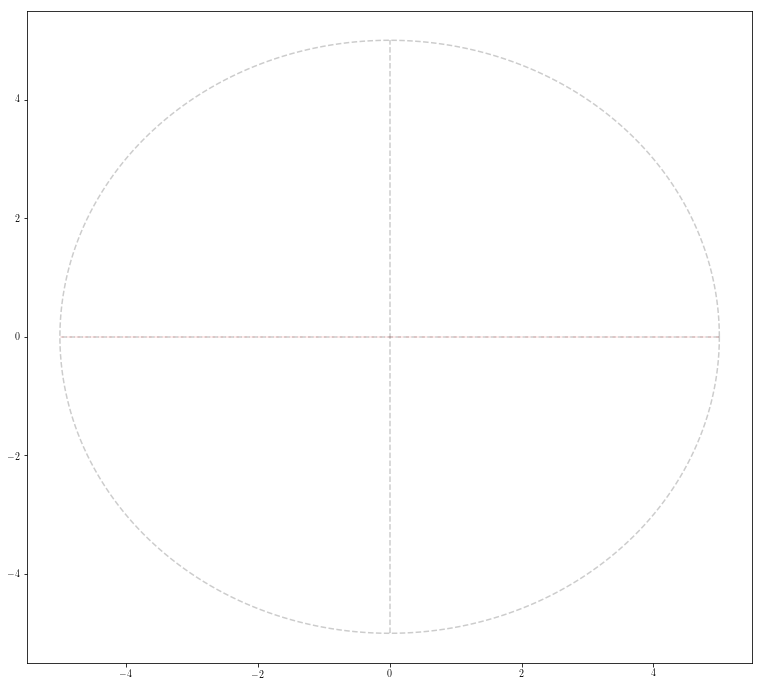

[ 3.  1. -4.  0. -1.  1.]


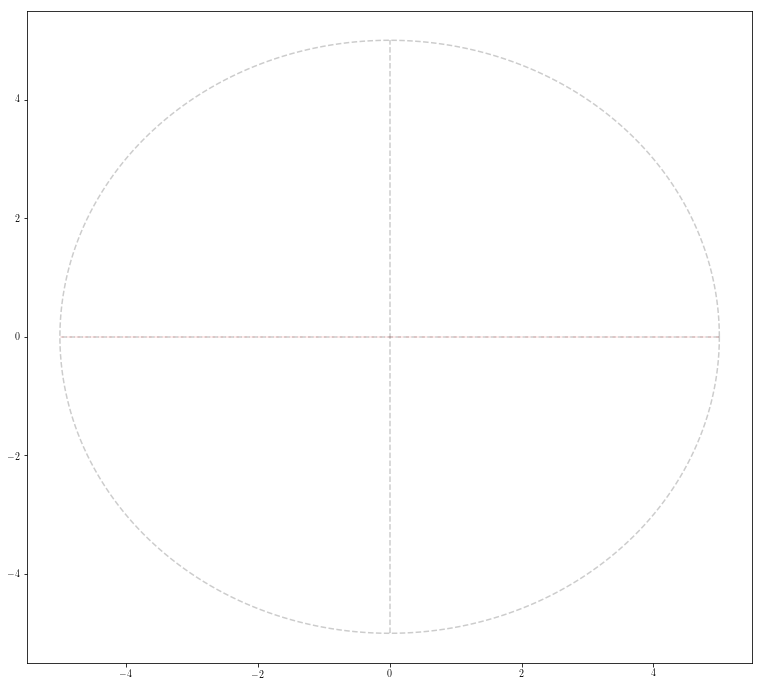

[-4.  0.  3.  2. -1.  2.]


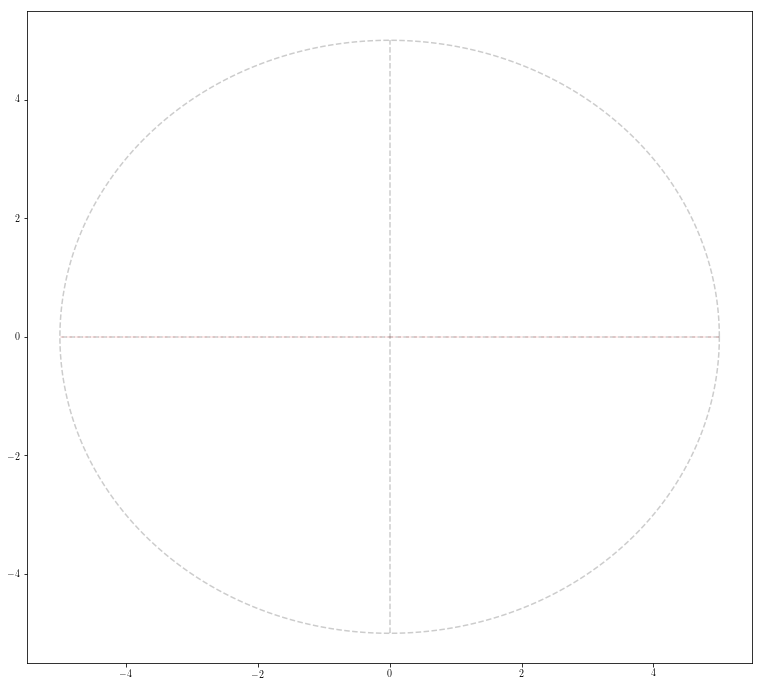

[-3. -1.  2.  3. -1.  2.]


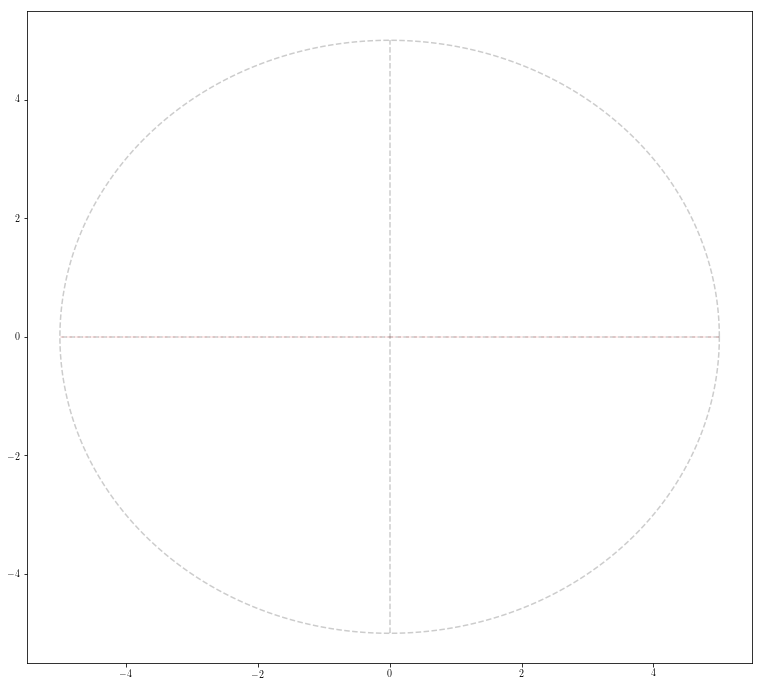

[ 2.  3. -3. -1. -1.  2.]


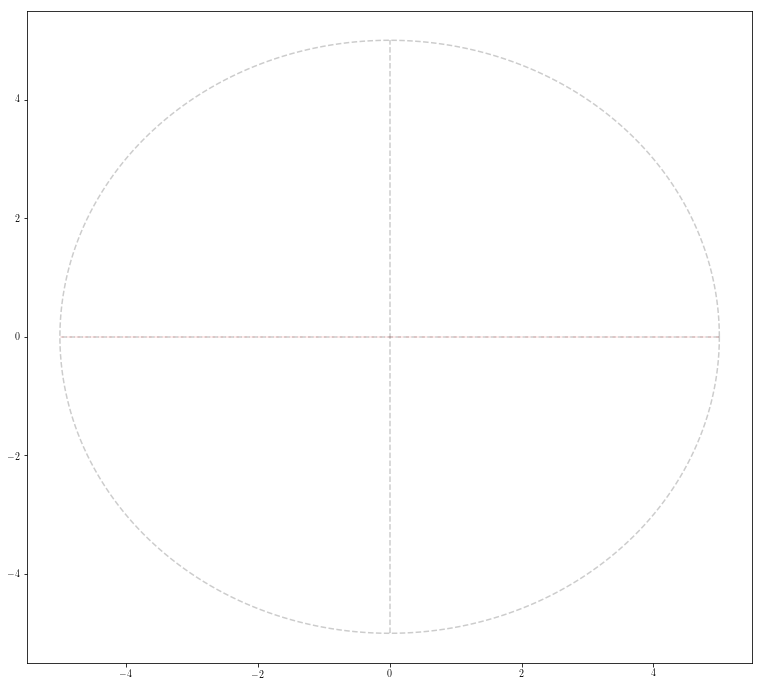

[ 3.  2. -4.  0. -1.  2.]


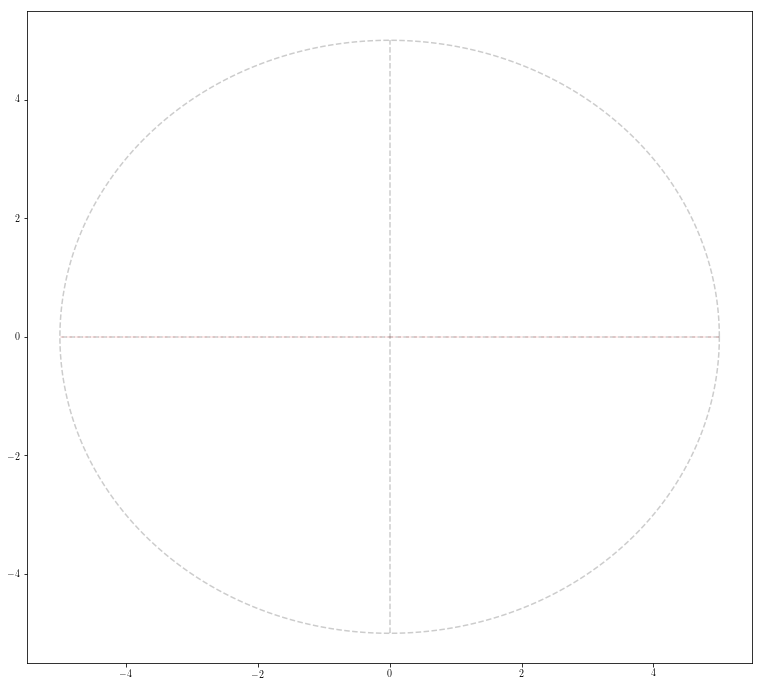

[-3. -2.  3. -1.  0. -3.]


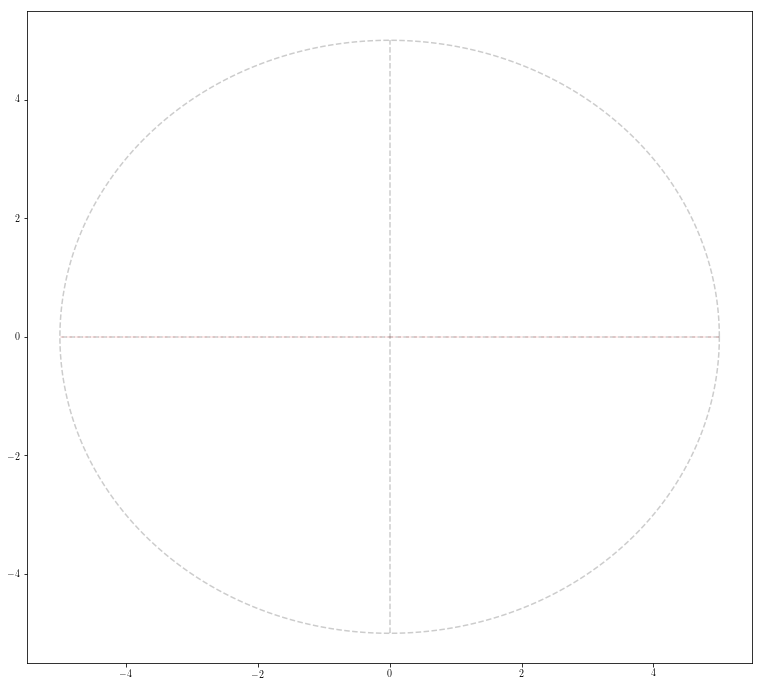

[-3. -1.  3. -2.  0. -3.]


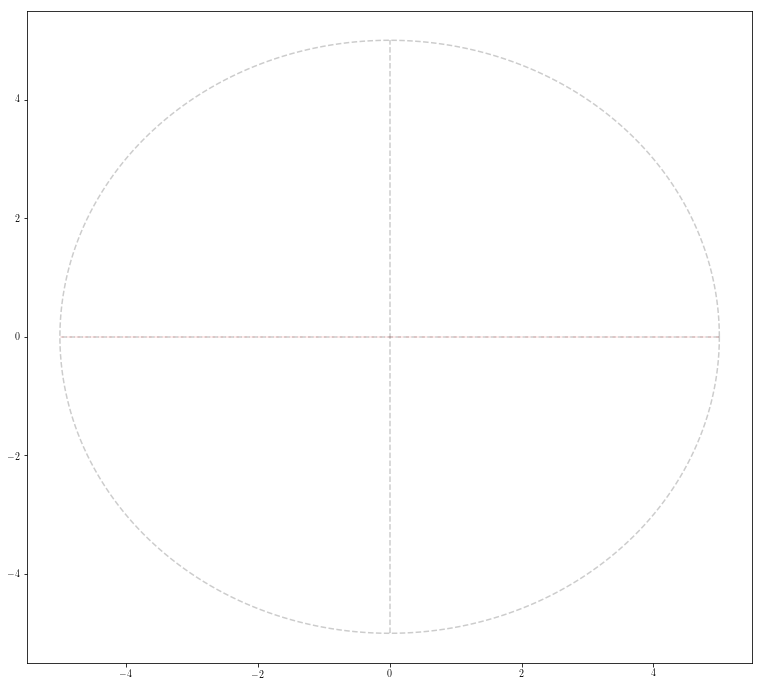

[ 3. -2. -3. -1.  0. -3.]


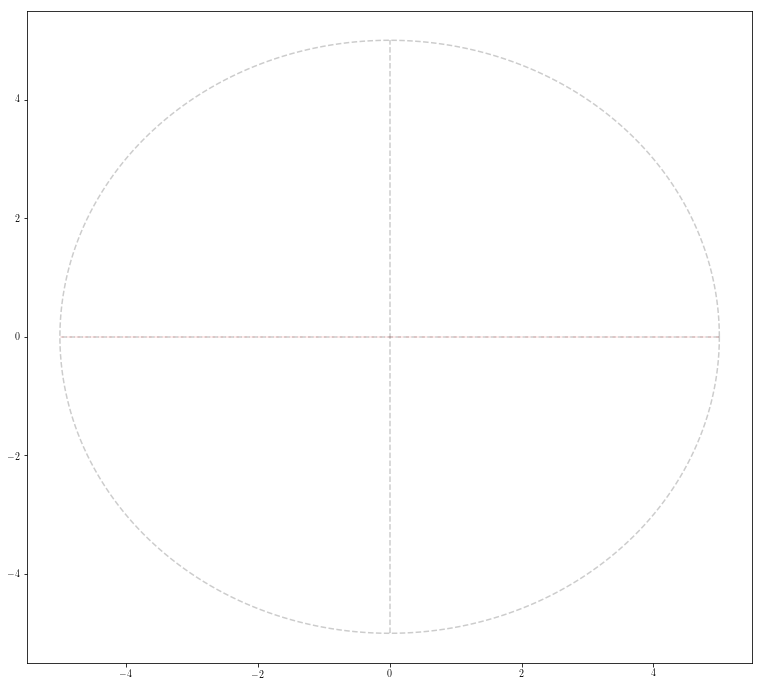

[ 3. -1. -3. -2.  0. -3.]


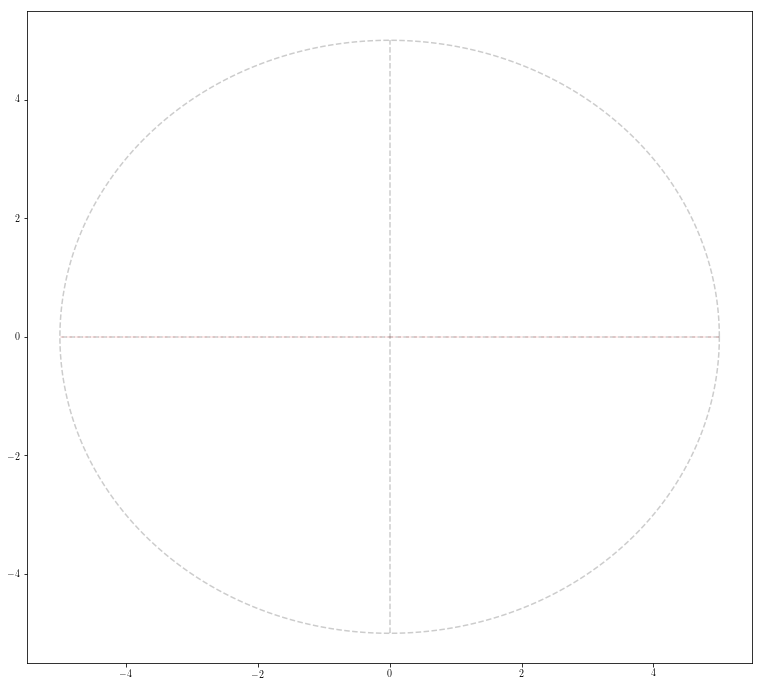

[-3. -1.  3. -1.  0. -2.]


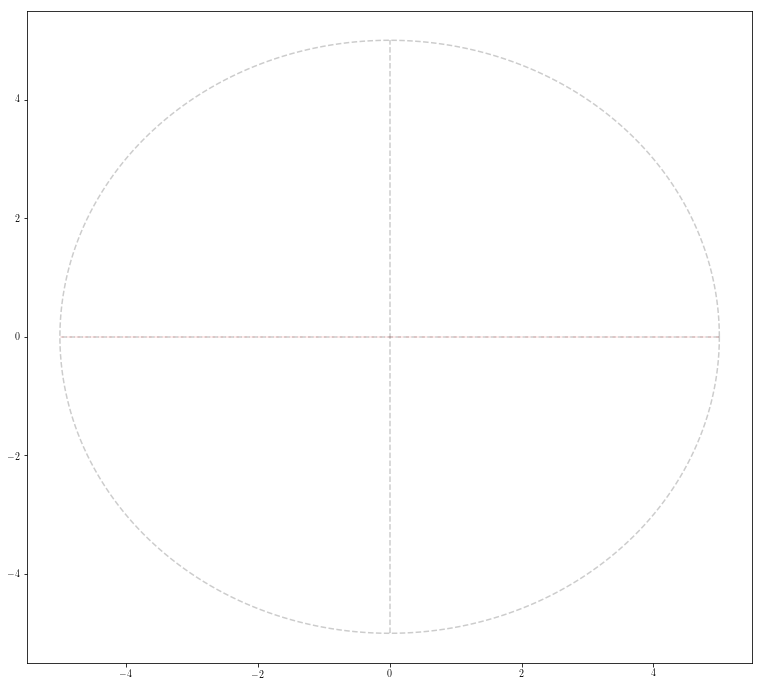

[ 3. -1. -3. -1.  0. -2.]


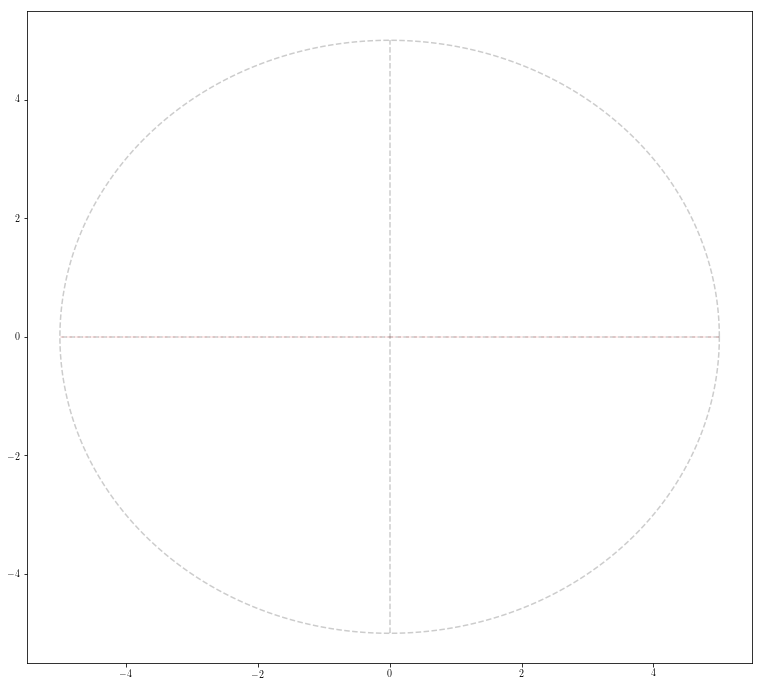

[-3. -2.  3.  1.  0. -1.]


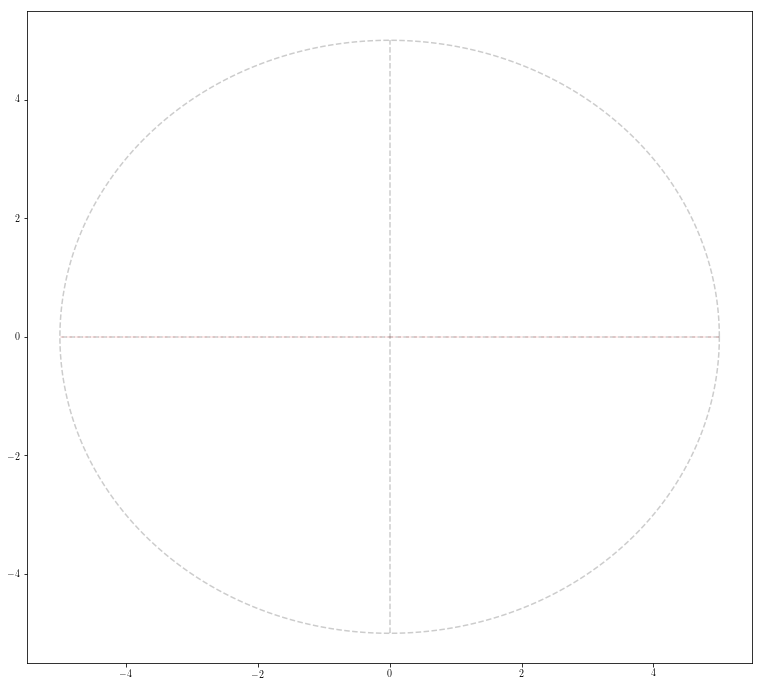

[-3.  1.  3. -2.  0. -1.]


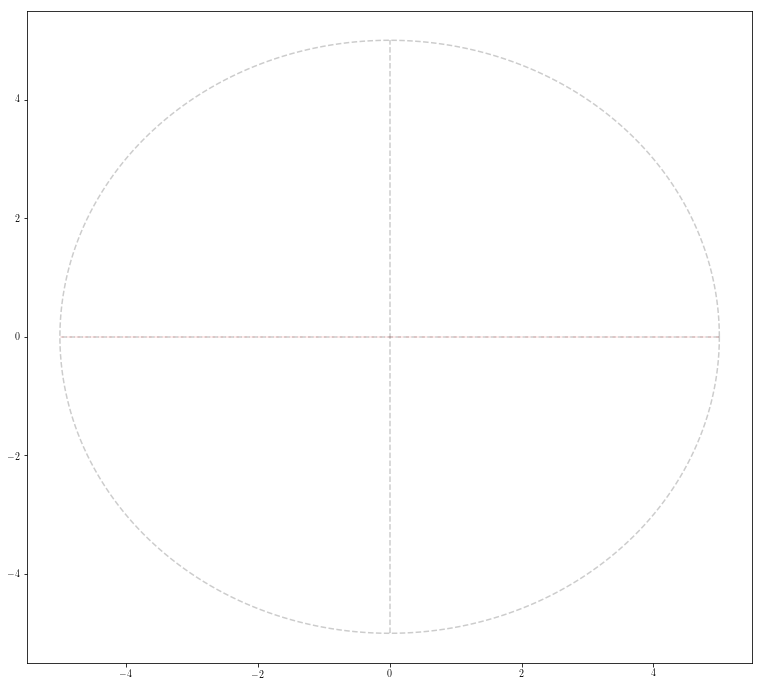

[ 3. -2. -3.  1.  0. -1.]


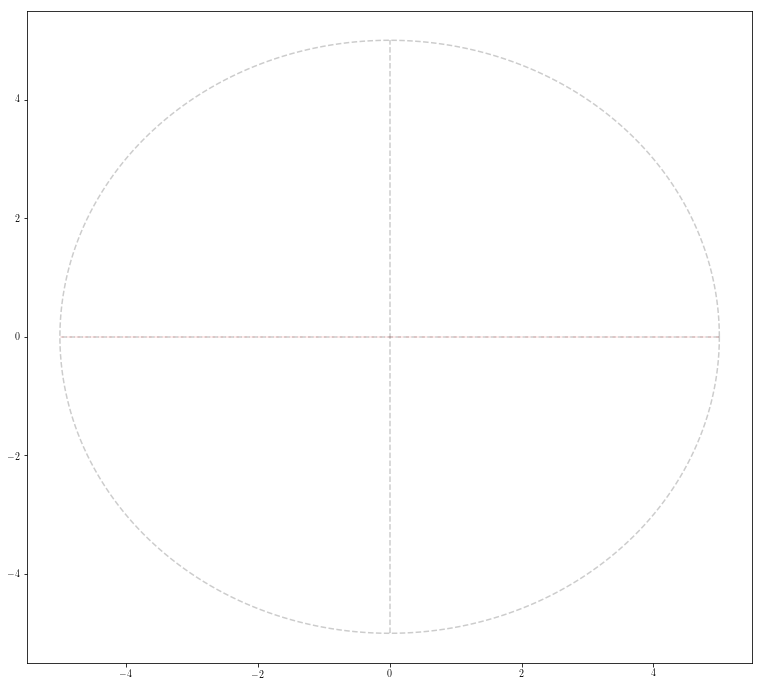

[ 3.  1. -3. -2.  0. -1.]


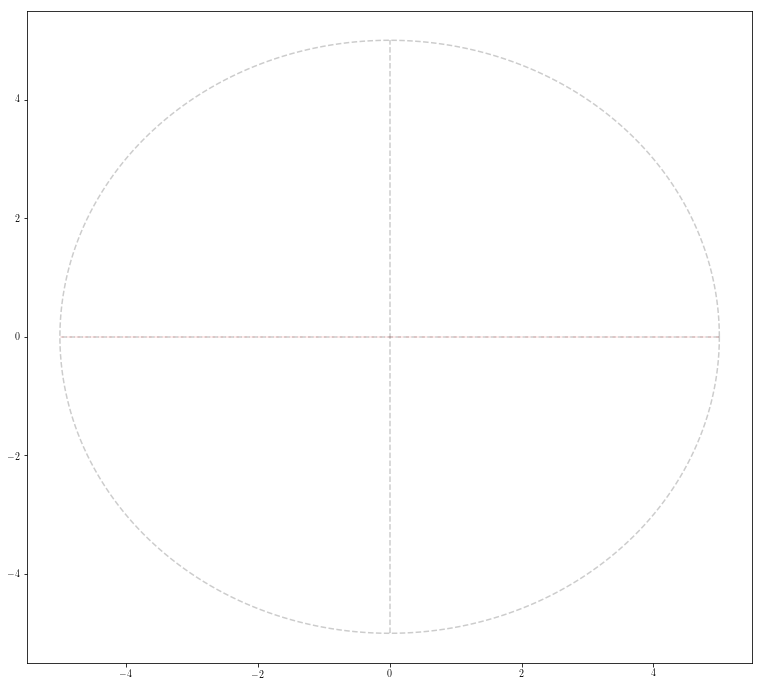

[-3. -1.  3.  2.  0.  1.]


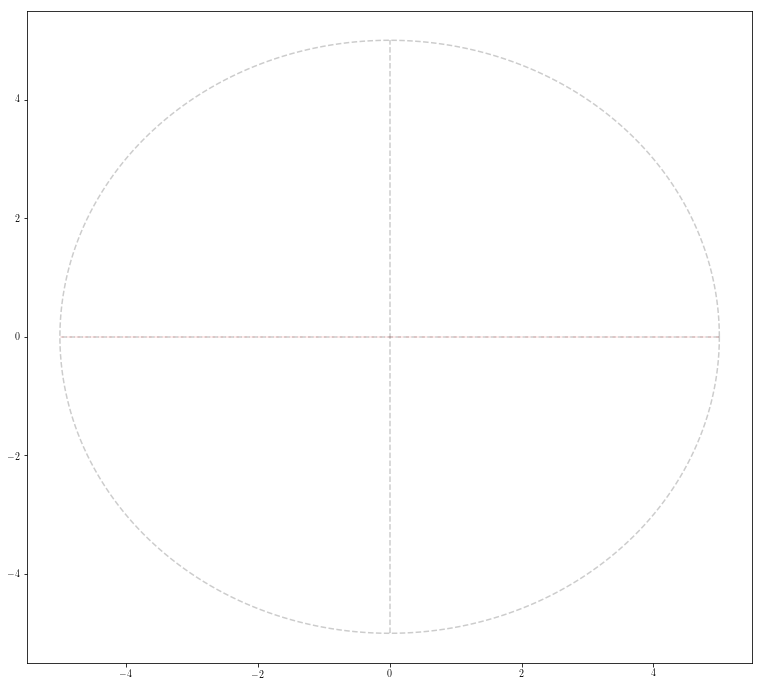

[-3.  2.  3. -1.  0.  1.]


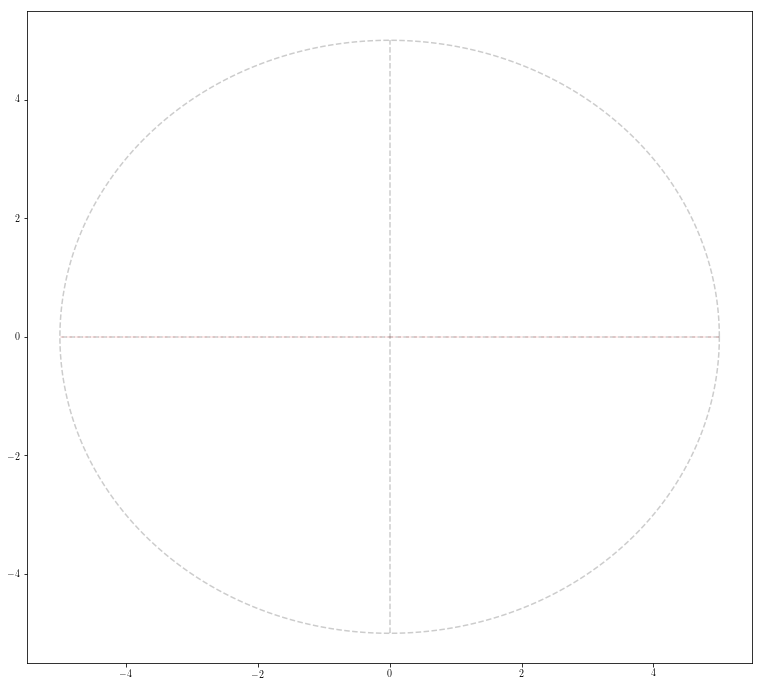

[ 3. -1. -3.  2.  0.  1.]


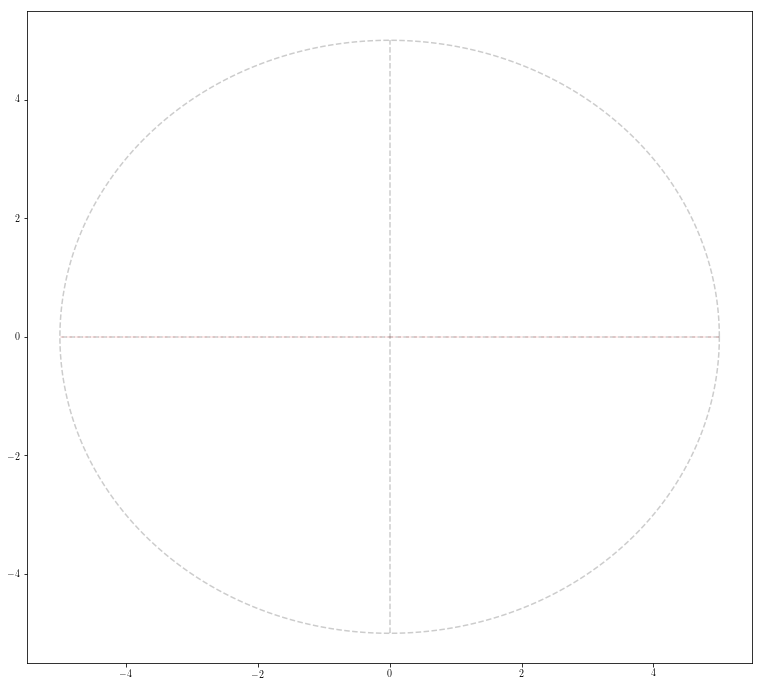

[ 3.  2. -3. -1.  0.  1.]


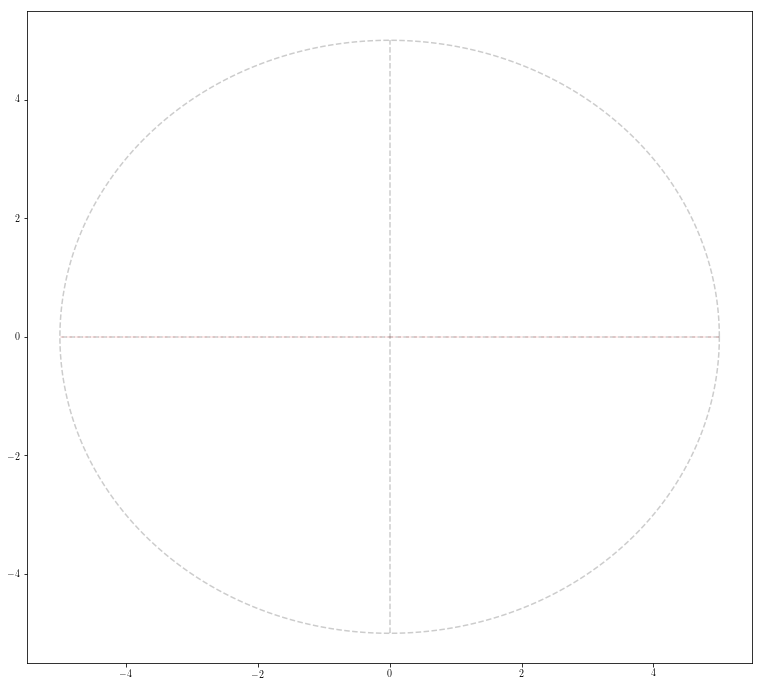

[-3.  1.  3.  1.  0.  2.]


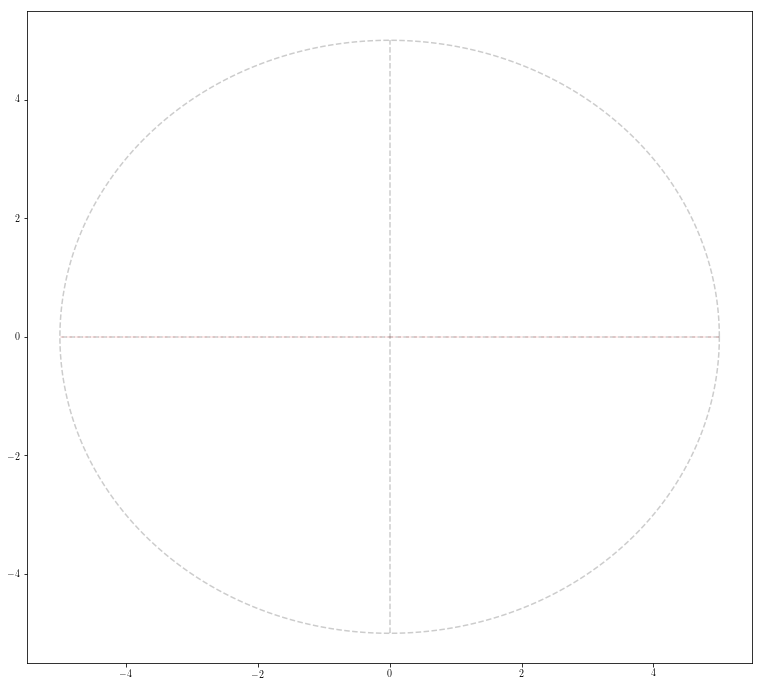

[ 3.  1. -3.  1.  0.  2.]


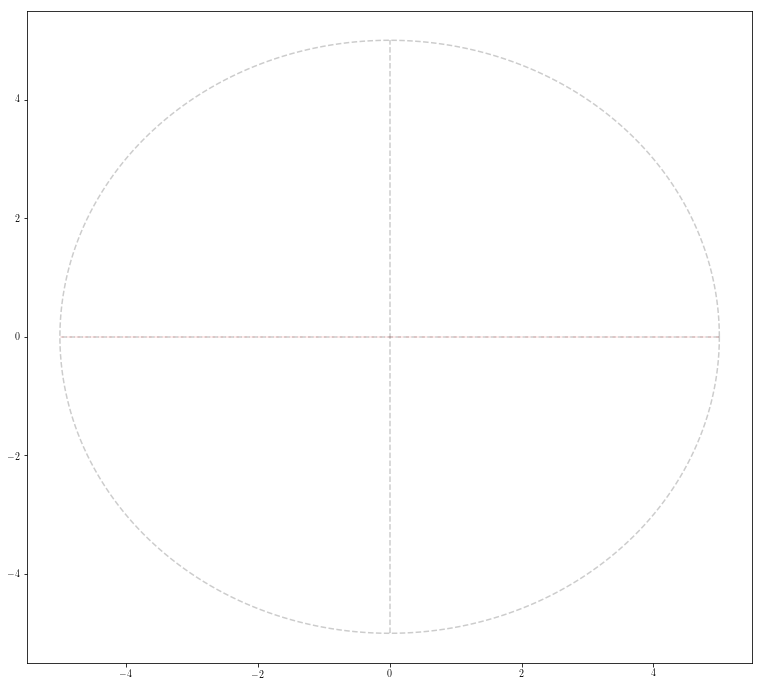

[-3.  1.  3.  2.  0.  3.]


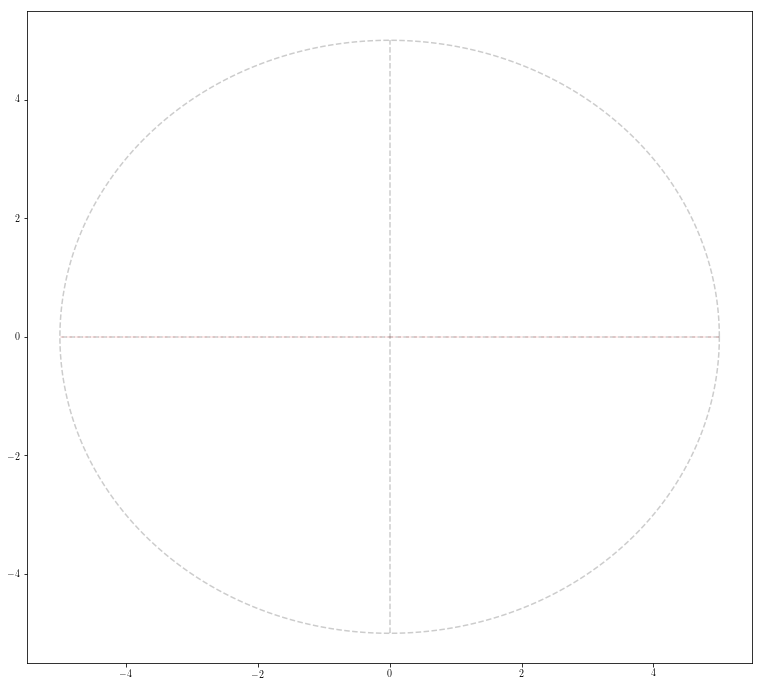

[-3.  2.  3.  1.  0.  3.]


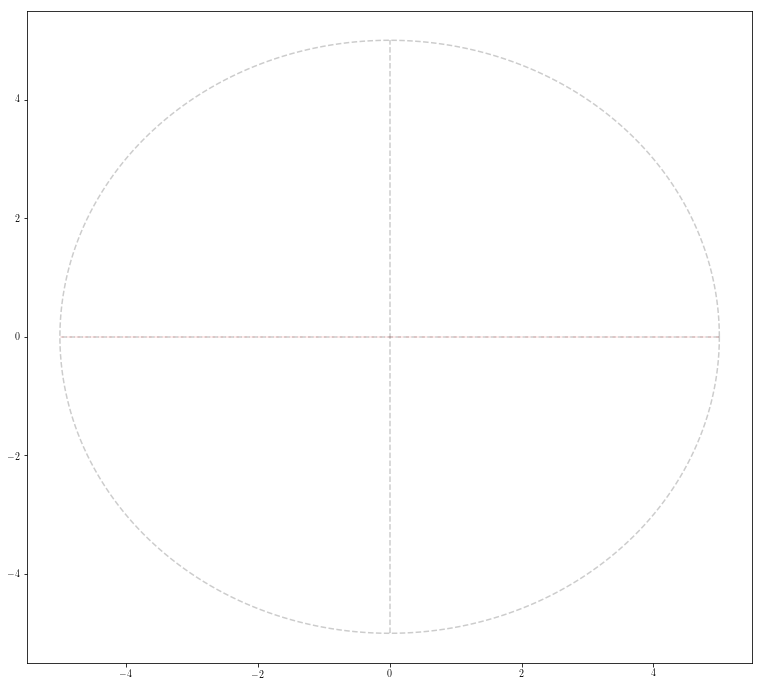

[ 3.  1. -3.  2.  0.  3.]


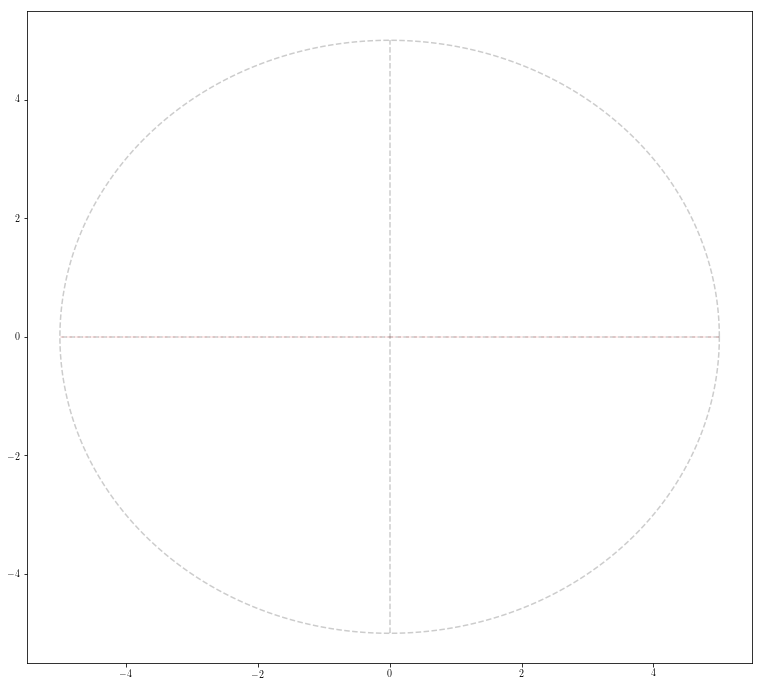

[ 3.  2. -3.  1.  0.  3.]


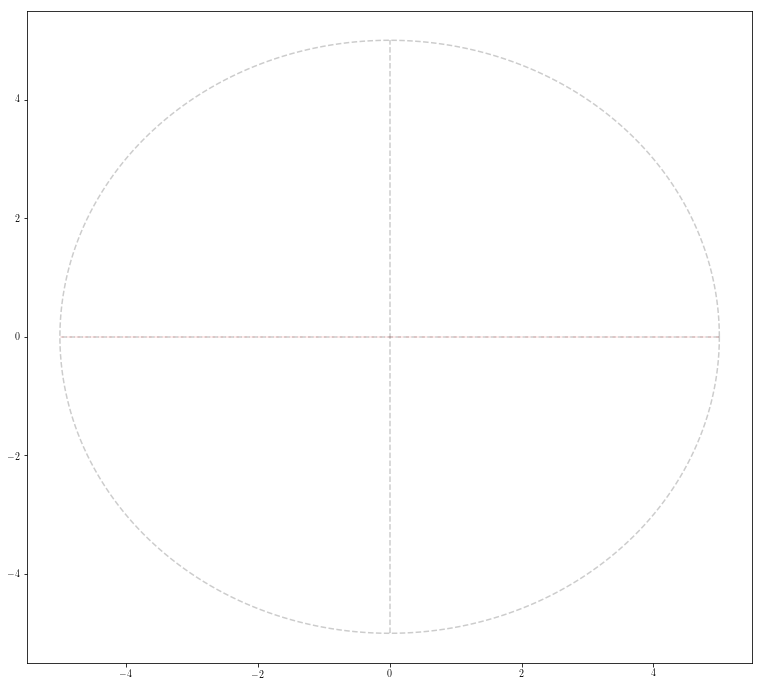

[-3. -2.  4.  0.  1. -2.]


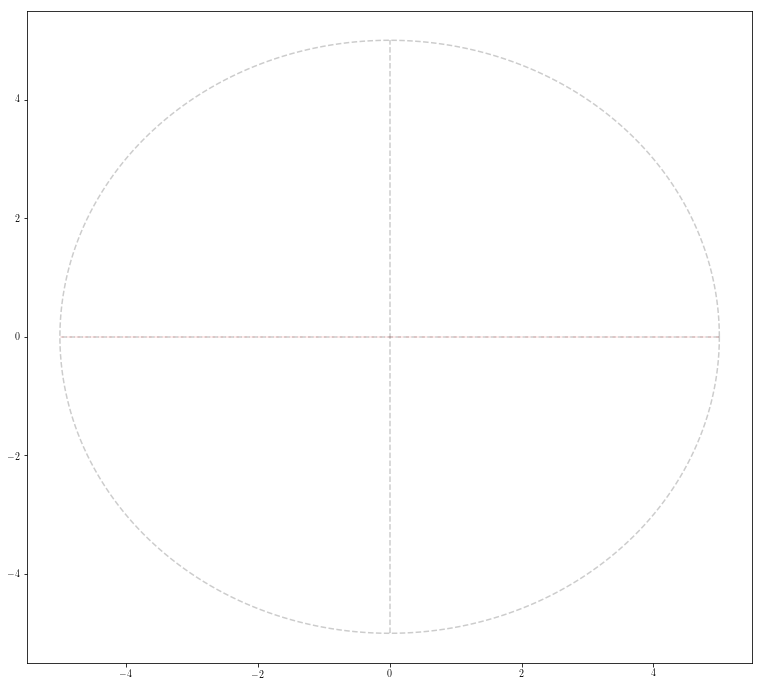

[-2. -3.  3.  1.  1. -2.]


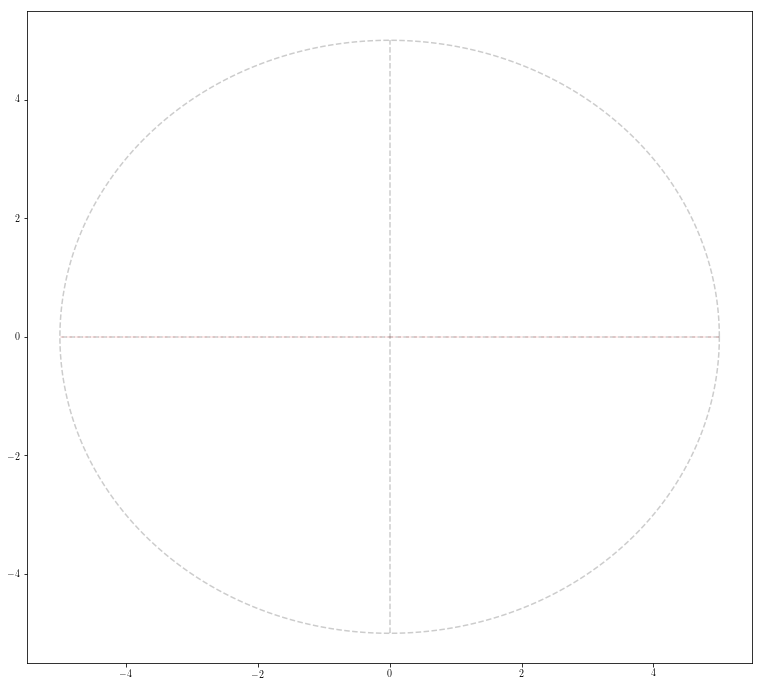

[ 3.  1. -2. -3.  1. -2.]


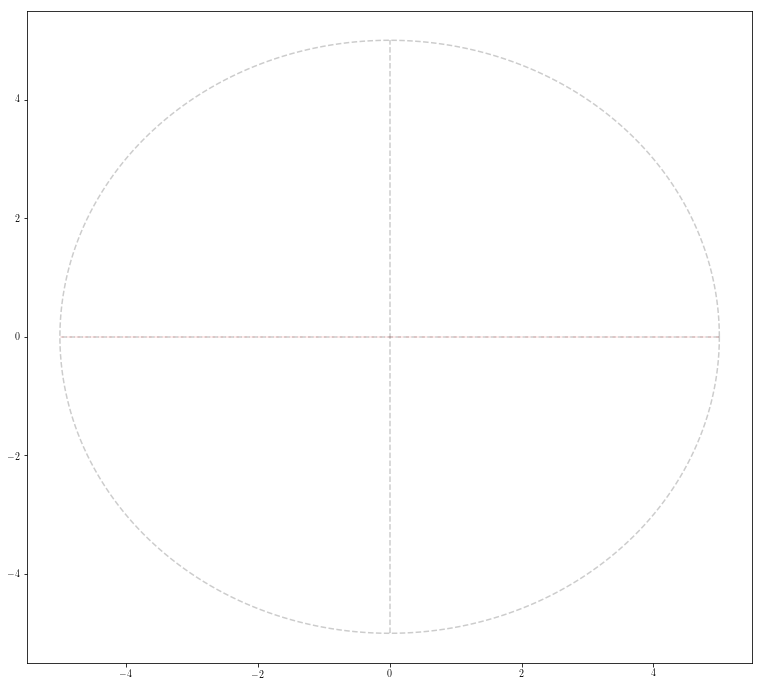

[ 4.  0. -3. -2.  1. -2.]


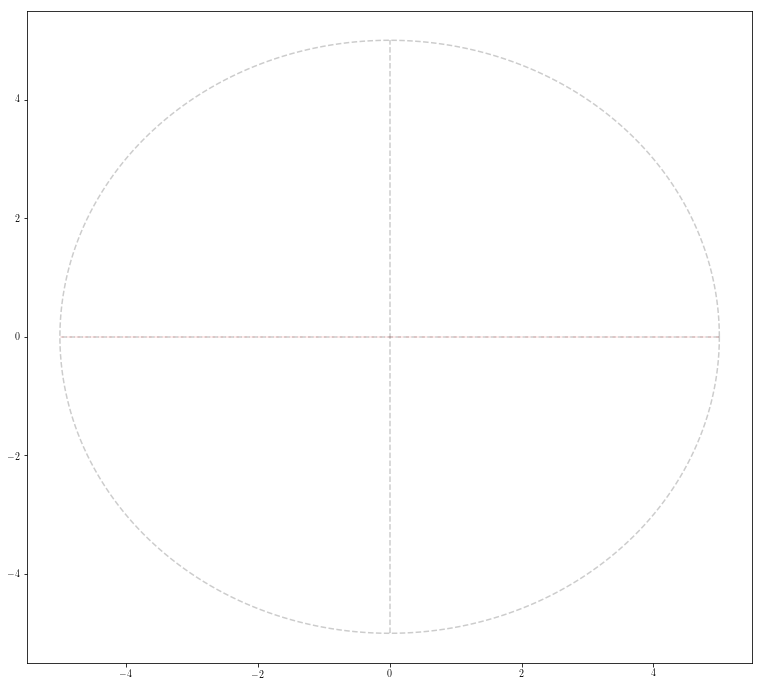

[-3. -1.  4.  0.  1. -1.]


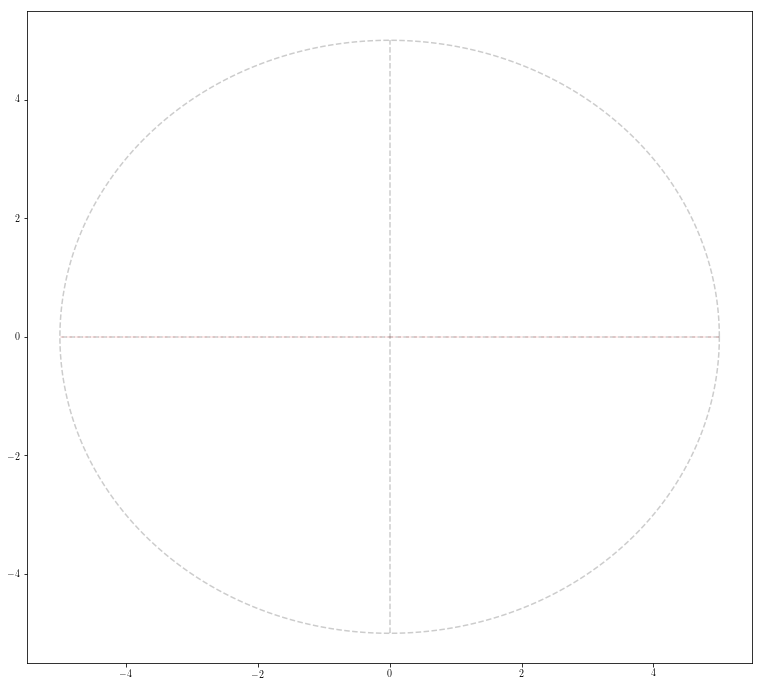

[-2. -3.  3.  2.  1. -1.]


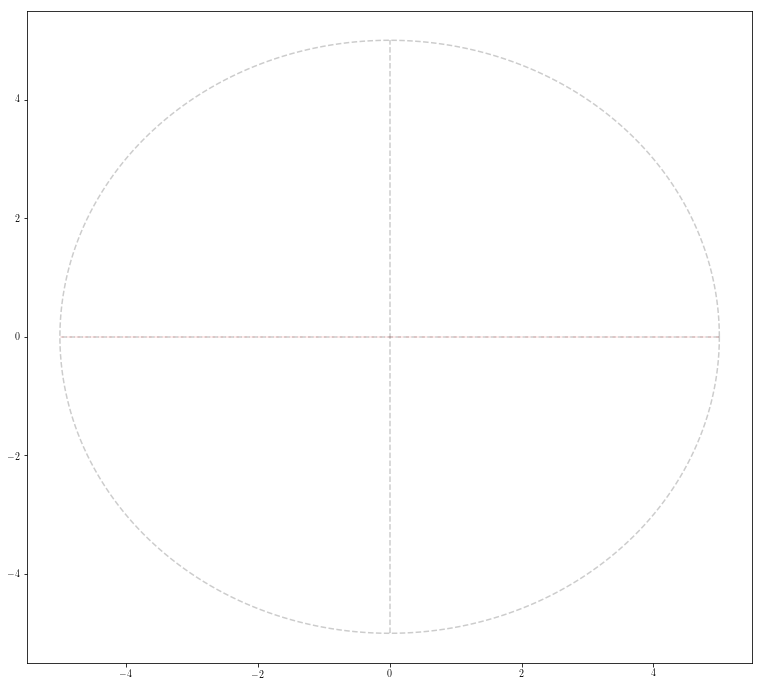

[ 3.  2. -2. -3.  1. -1.]


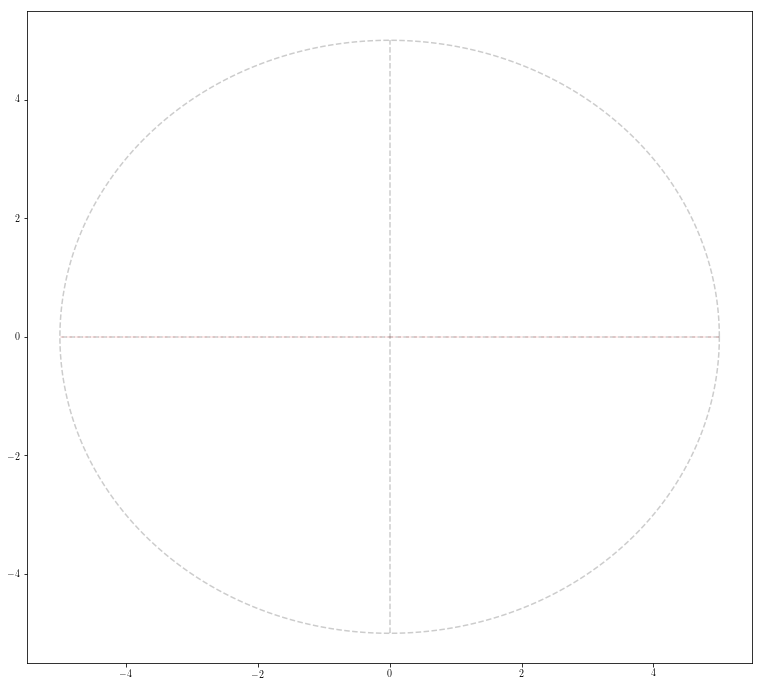

[ 4.  0. -3. -1.  1. -1.]


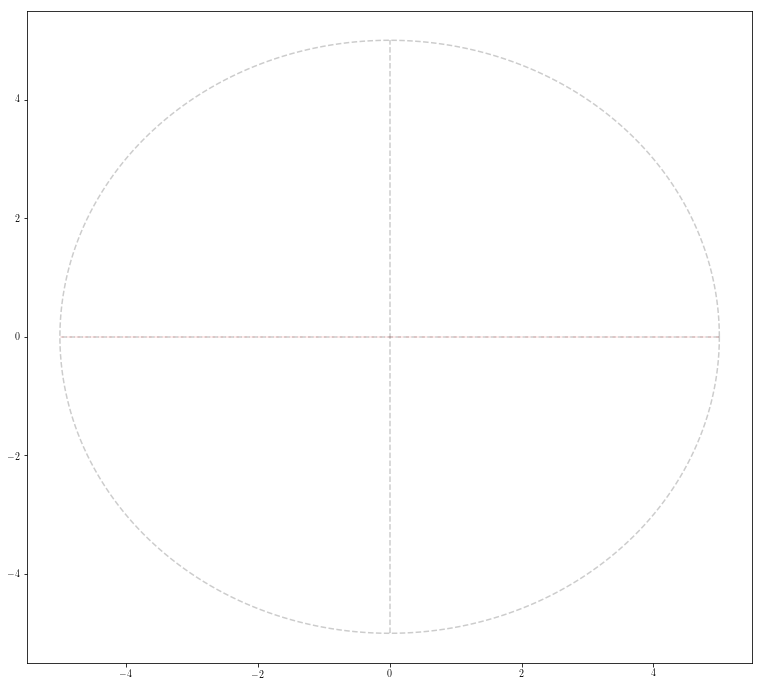

[-1. -3.  2.  3.  1.  0.]


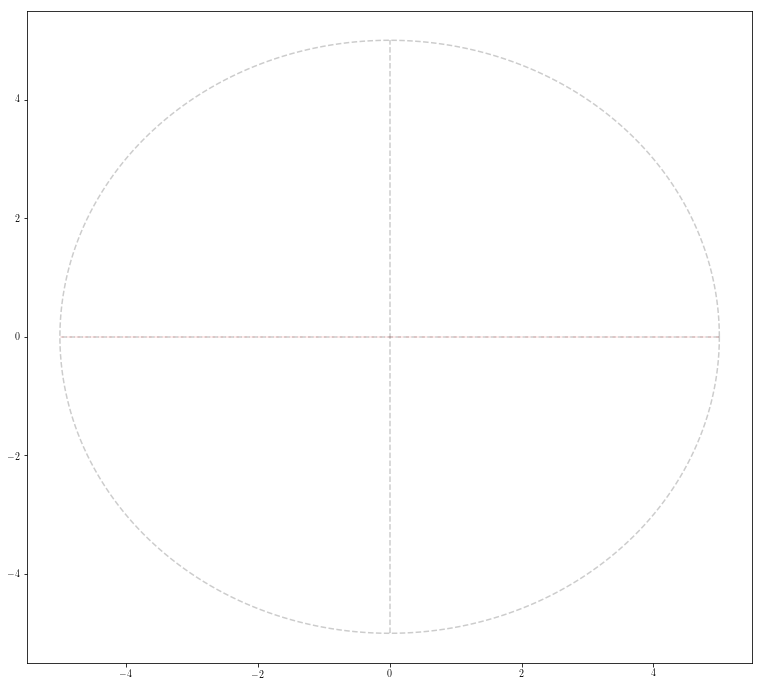

[-1.  3.  2. -3.  1.  0.]


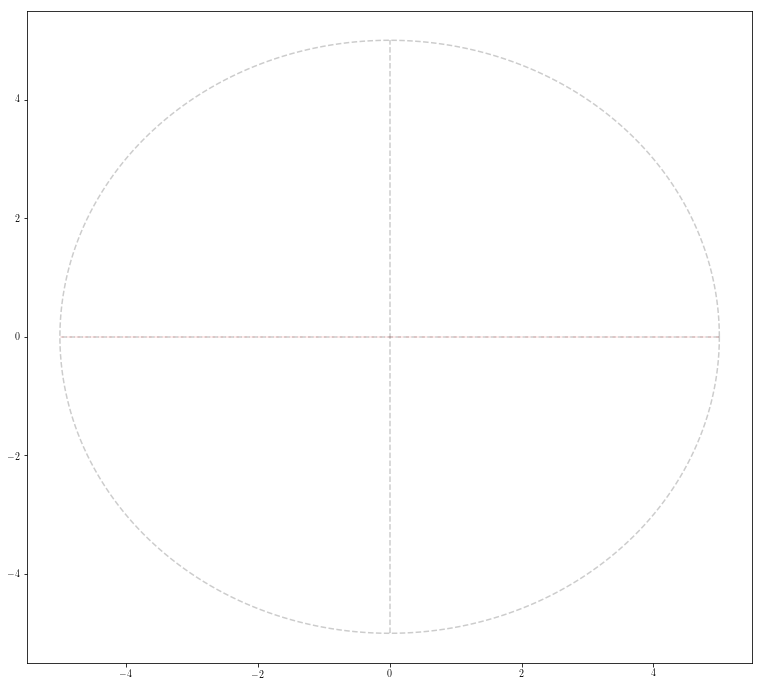

[ 2. -3. -1.  3.  1.  0.]


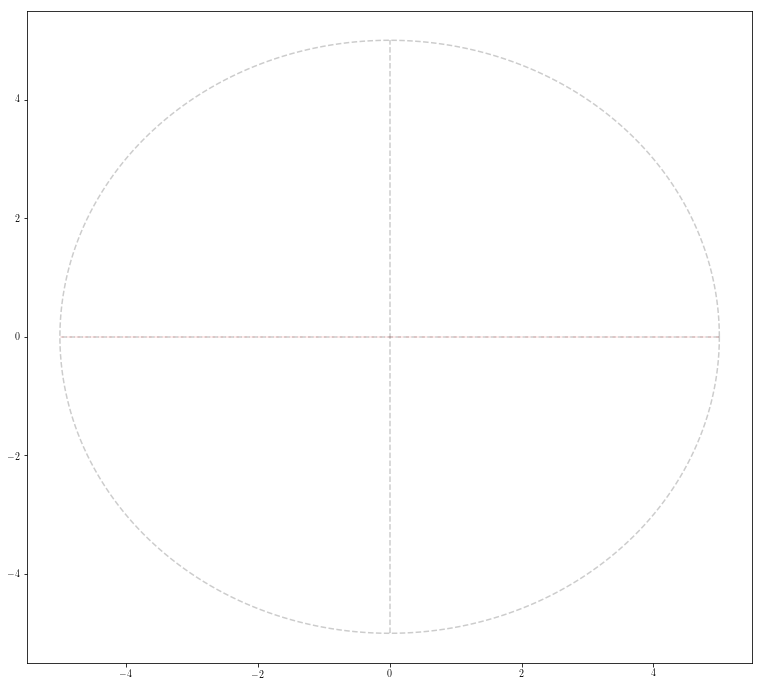

[ 2.  3. -1. -3.  1.  0.]


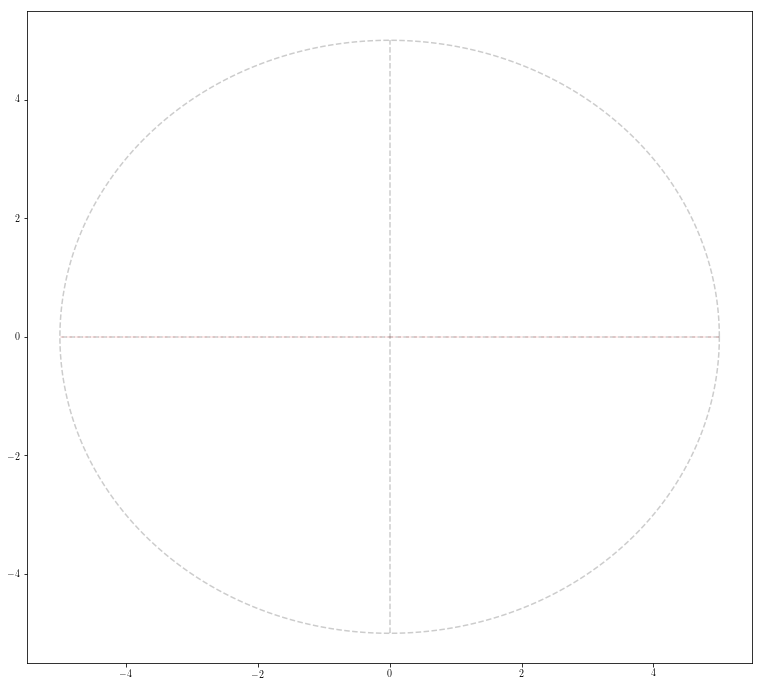

[-3.  1.  4.  0.  1.  1.]


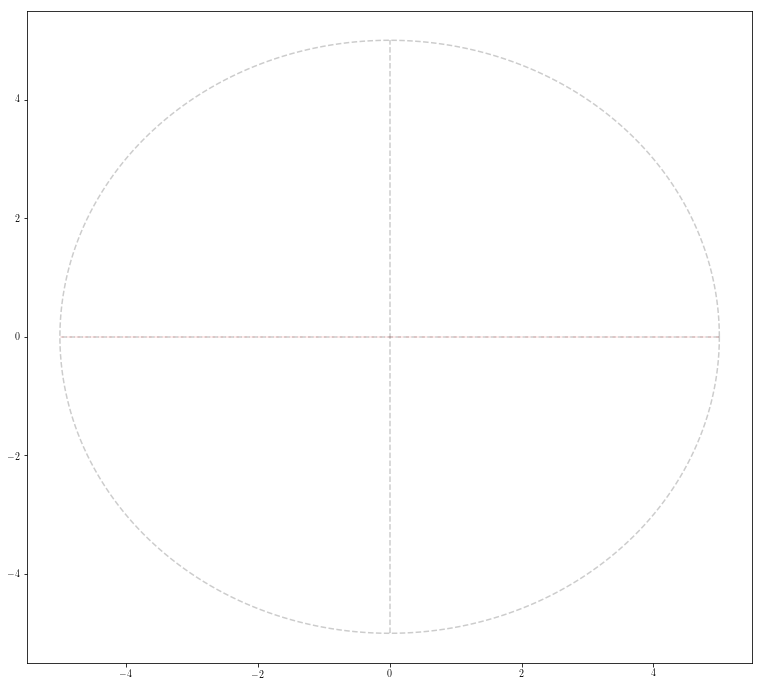

[-2.  3.  3. -2.  1.  1.]


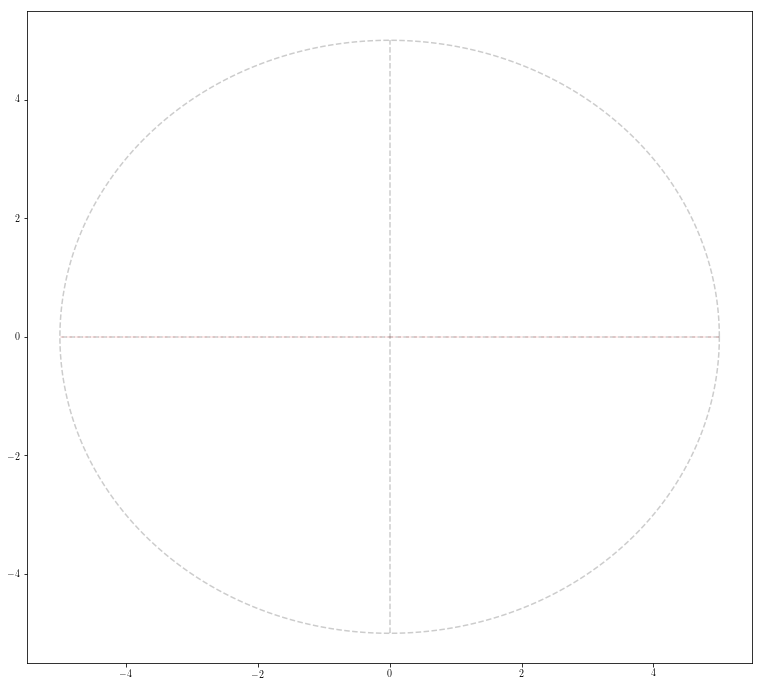

[ 0.  4.  1. -3.  1.  1.]


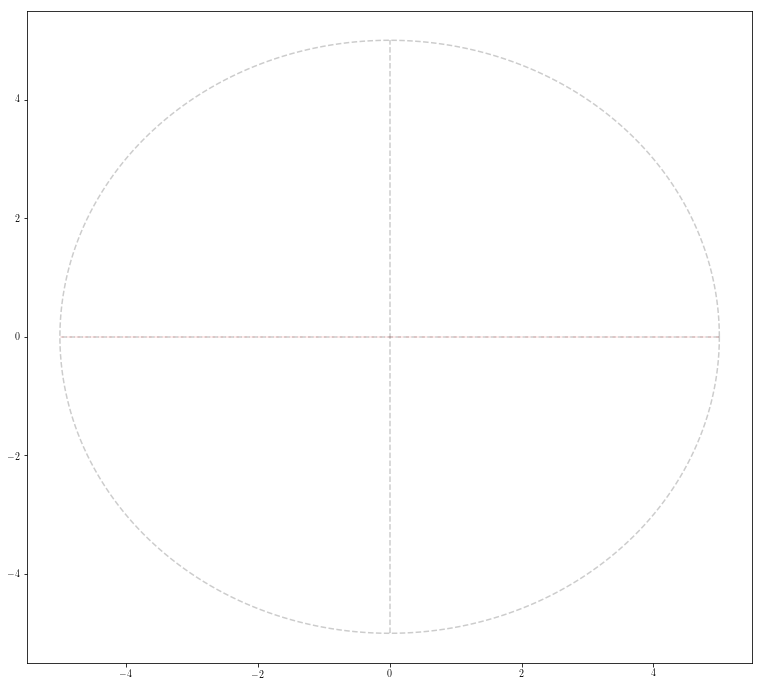

[ 1. -3.  0.  4.  1.  1.]


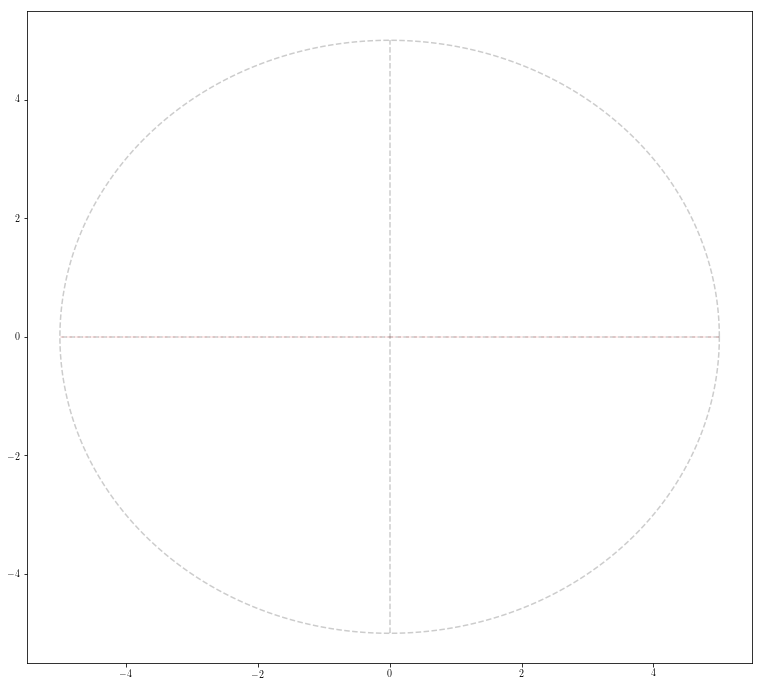

[ 3. -2. -2.  3.  1.  1.]


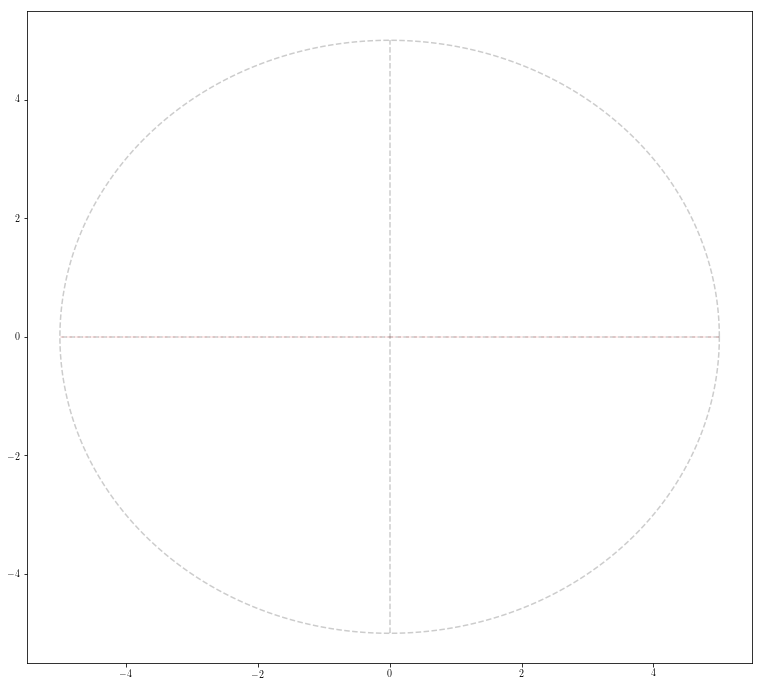

[ 4.  0. -3.  1.  1.  1.]


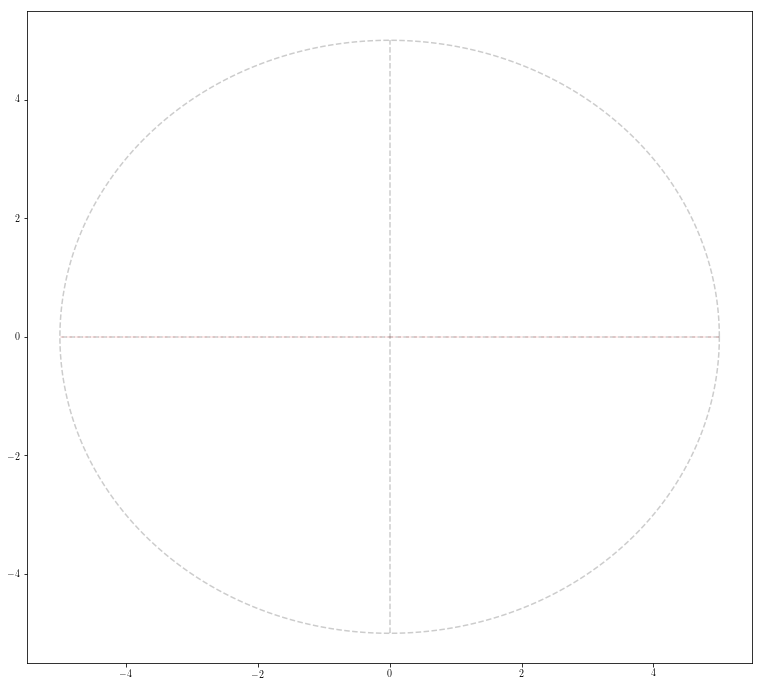

[-3.  2.  4.  0.  1.  2.]


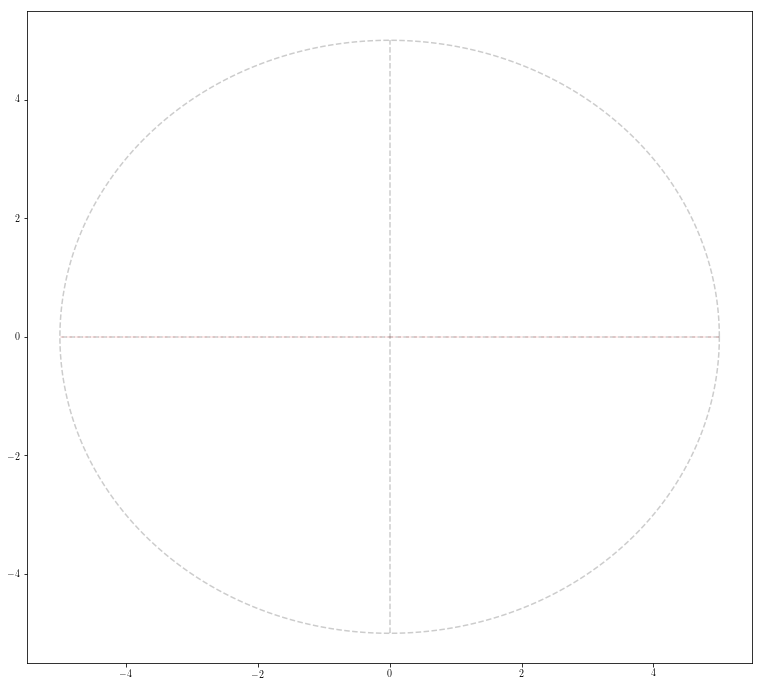

[-2.  3.  3. -1.  1.  2.]


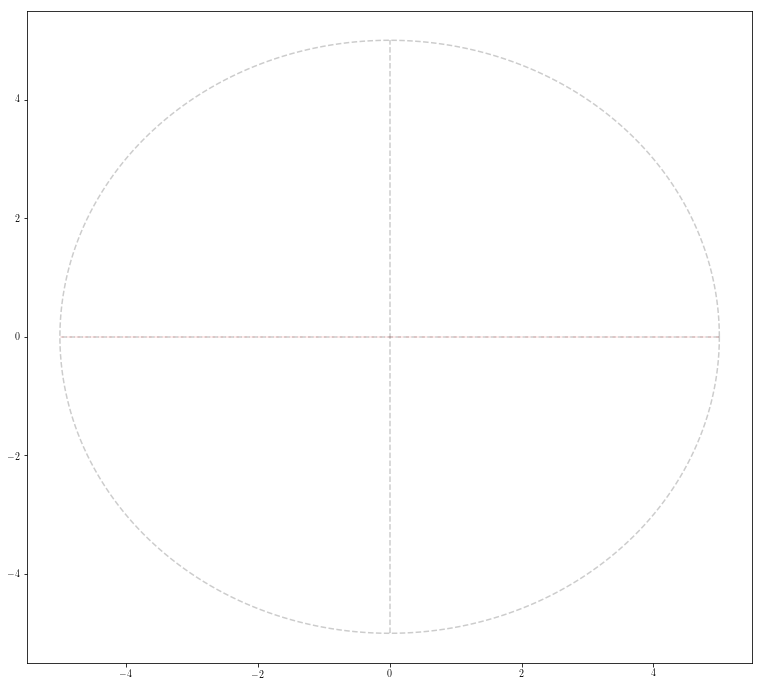

[ 3. -1. -2.  3.  1.  2.]


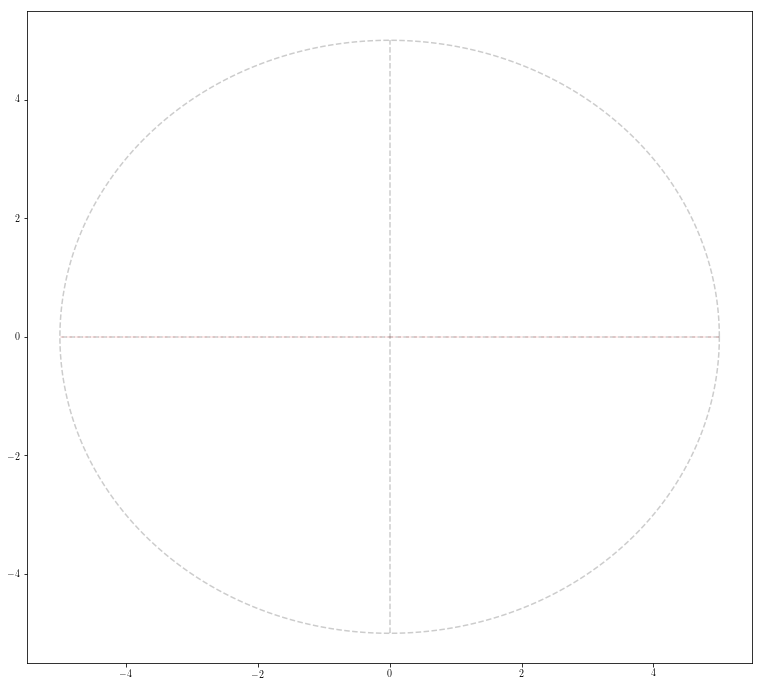

[ 4.  0. -3.  2.  1.  2.]


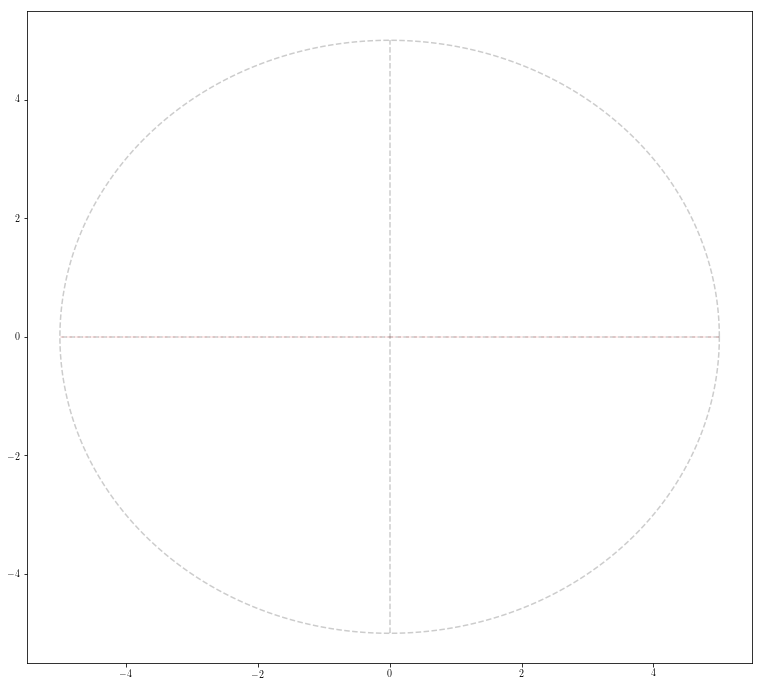

[-1. -3.  3.  1.  2. -2.]


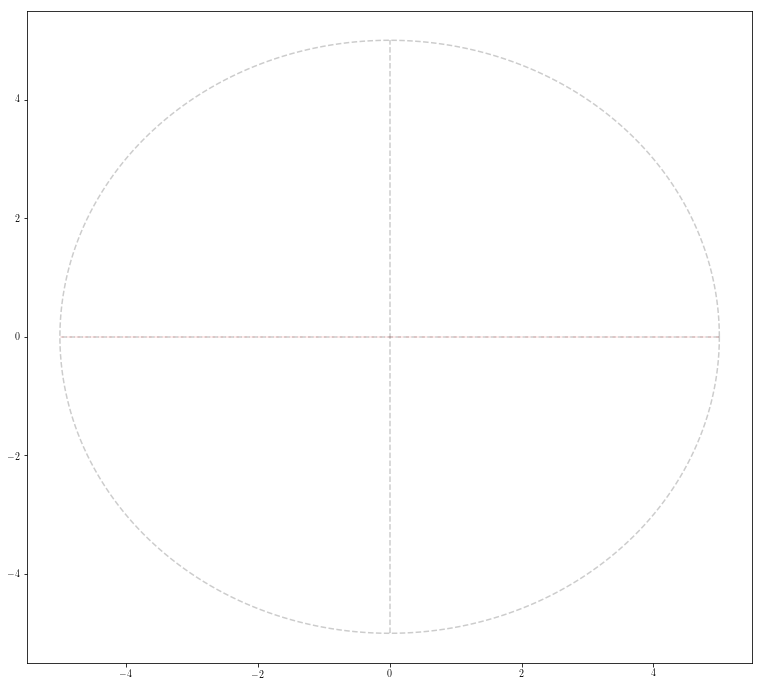

[ 3.  1. -1. -3.  2. -2.]


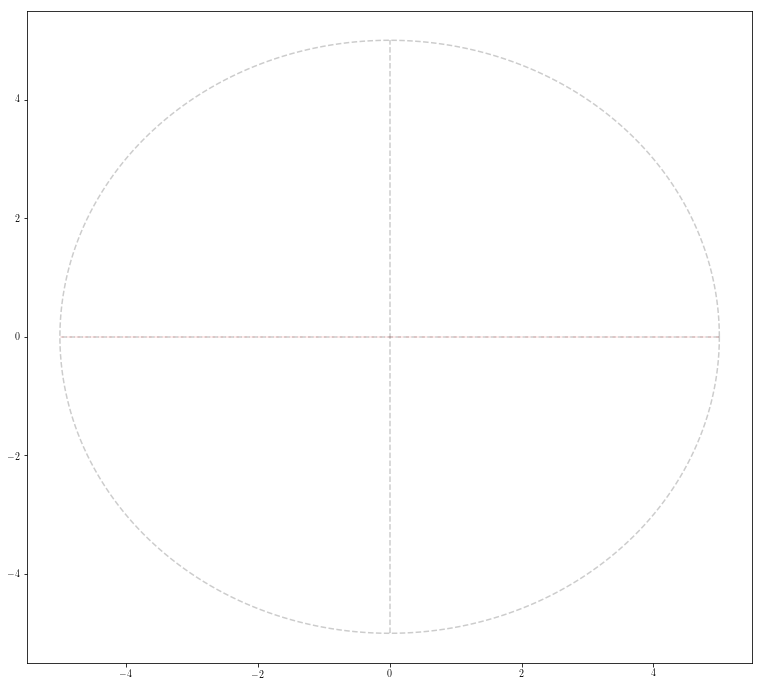

[-1. -3.  3.  2.  2. -1.]


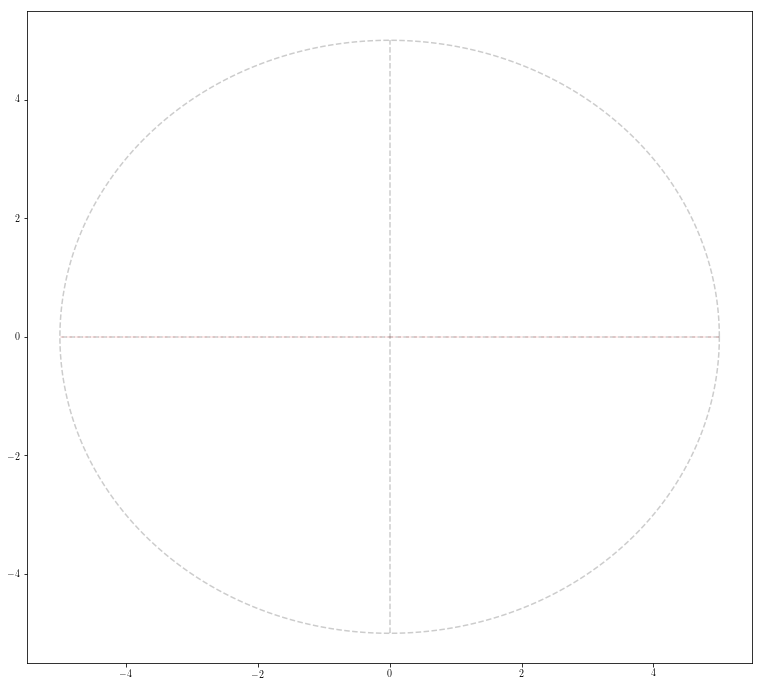

[ 3.  2. -1. -3.  2. -1.]


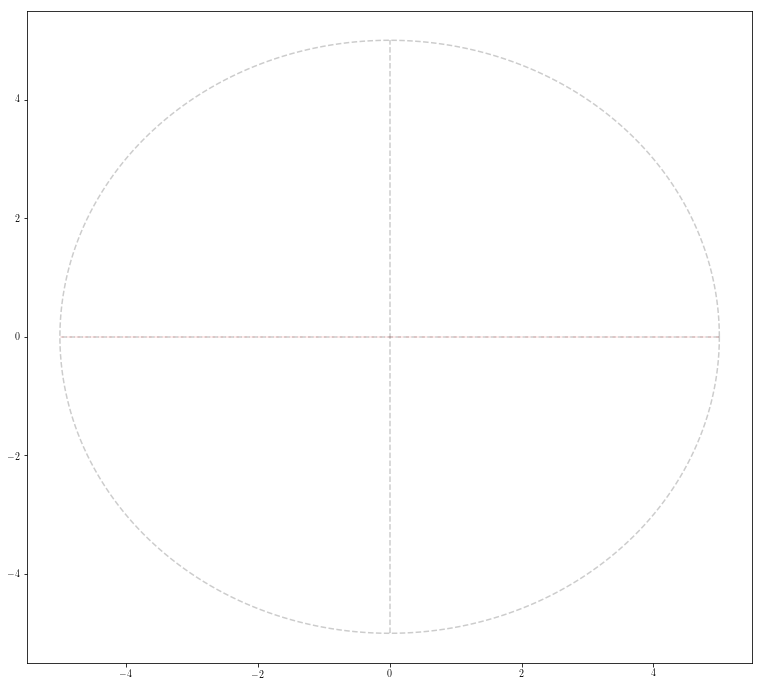

[-1.  3.  3. -2.  2.  1.]


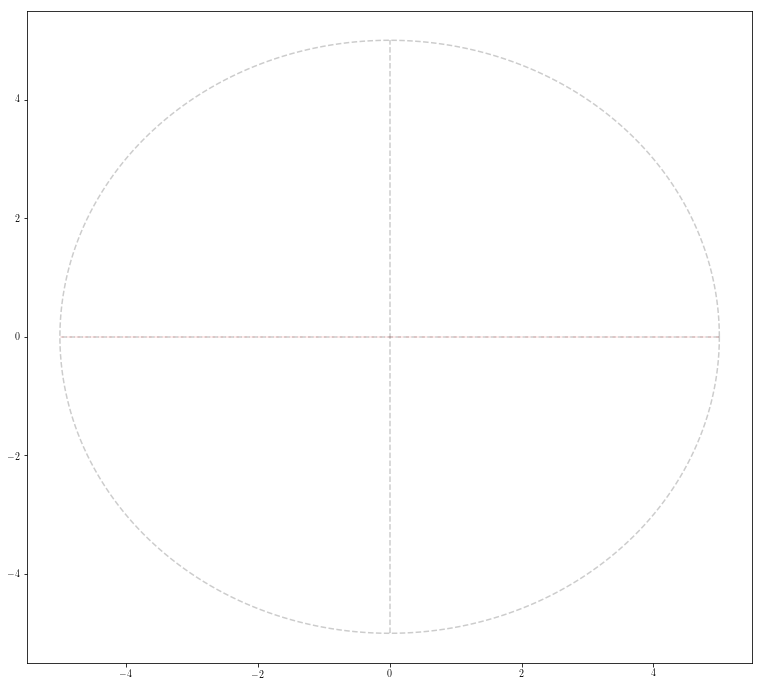

[ 0.  4.  2. -3.  2.  1.]


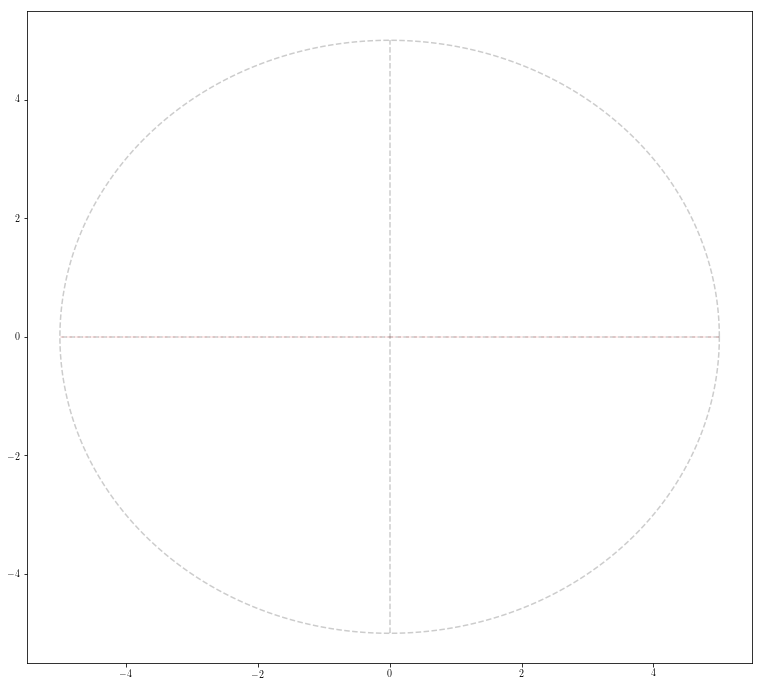

[ 2. -3.  0.  4.  2.  1.]


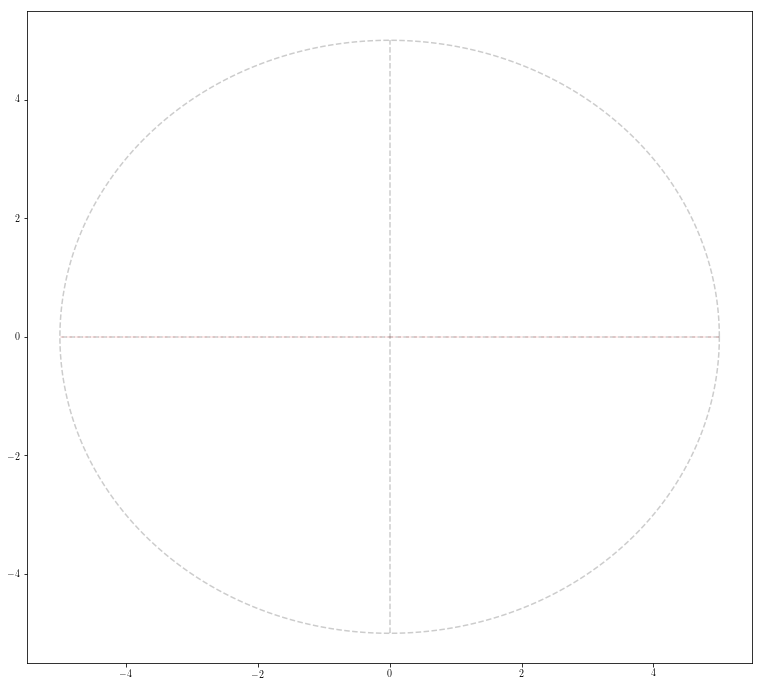

[ 3. -2. -1.  3.  2.  1.]


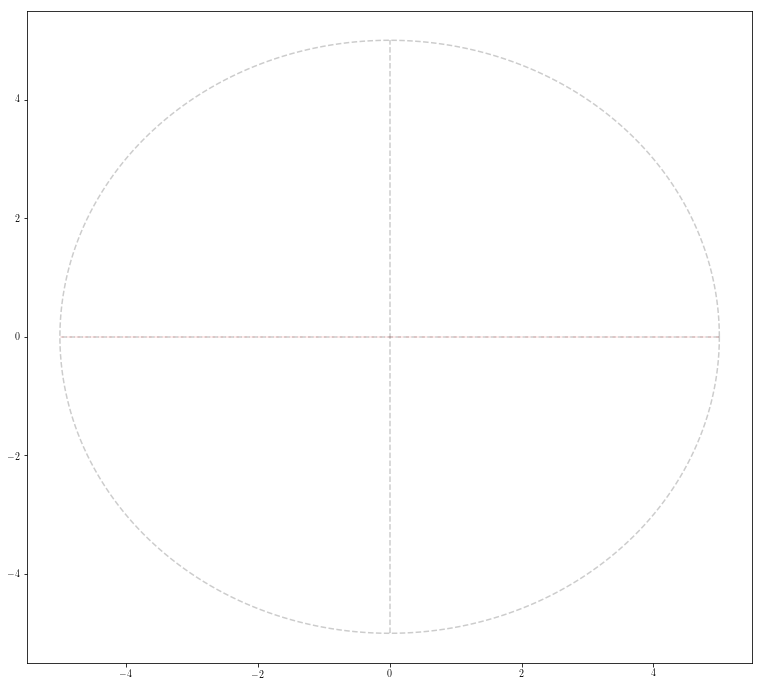

[-1.  3.  3. -1.  2.  2.]


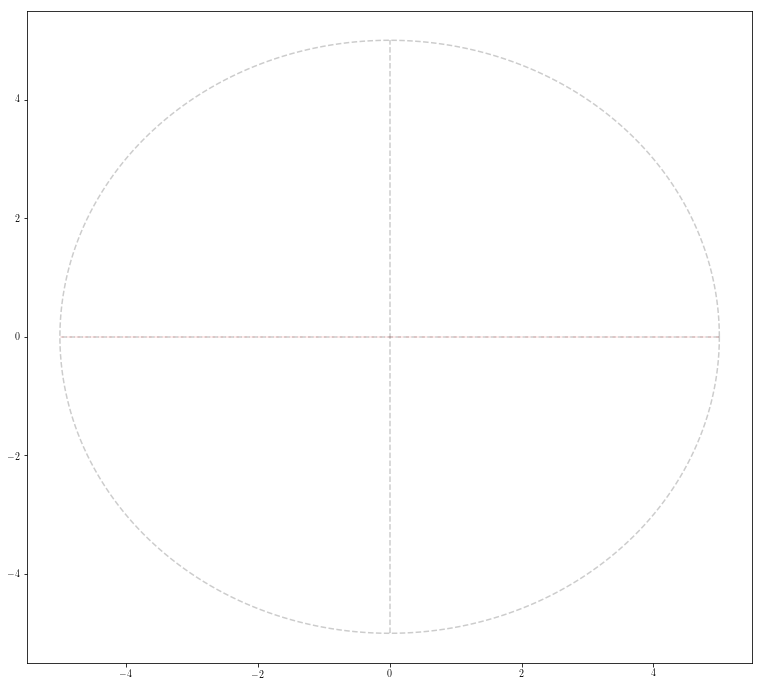

[ 3. -1. -1.  3.  2.  2.]


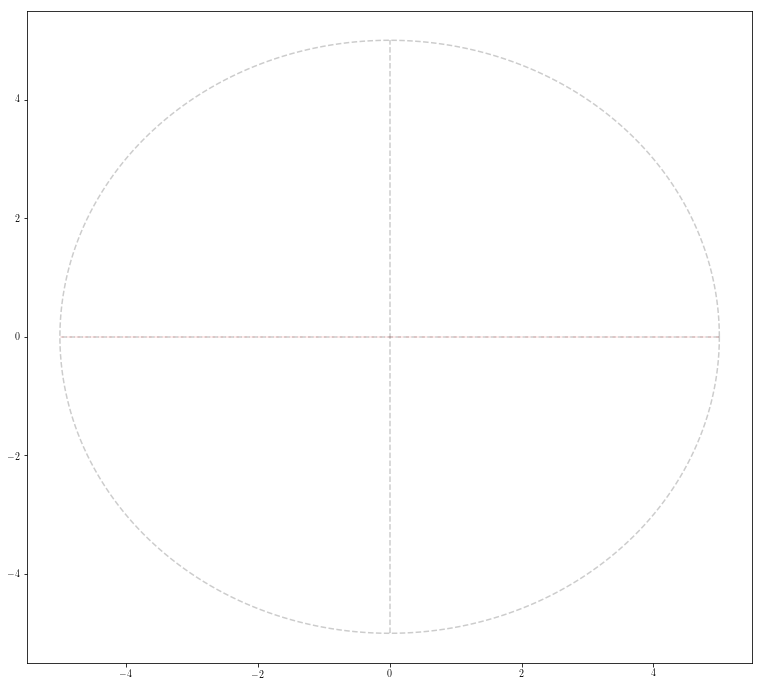

In [19]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)


pos_missing = miss_first_pass


for k_vec in pos_missing:
    print(k_vec)

    plt.figure(figsize = (13, 12))
    plt.plot(x, y, 'k--', alpha = 0.2)
    plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
    plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
    for aa in range(post_data.num_sect):
        ## Plot sectors
        plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
        plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

    ## Print missing 
#     p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#     p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#     p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
#     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
#     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
#     p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
#     p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
#     p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
#     plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
#     plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
#     plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)

#     plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
#     plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
#     plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
#     plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
    plt.show()

In [ ]:
print(pos_missing_indices[1])
print(wv[dsec][1][-1, pos_missing_indices[1][0]])
print(wv[dsec][1][:, pos_missing_indices[1][0]])
print(wv[dsec][1][K3_ANGLE, pos_missing_indices[1][0]])
print(theta[sec])
print(theta[dsec])
# print(np.arctan2(1, 0))
# print(np.arctan2(-1, -0))
# print(np.arctan2(-2, -4))
# print(np.arctan2(-1, -4))
print(kmax**2)

In [101]:
n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

for l in range(post_data.num_k1_sects):
    print("\n\nl = {}".format(l))
    for k_vec in pos_missing[l]:

        plt.figure(figsize = (13, 12))
        plt.plot(x, y, 'k--', alpha = 0.2)
        plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
        plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
        for aa in range(post_data.num_sect):
            ## Plot sectors
            plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.05)
            plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.05)

        ## Print missing 
#         p1, = plt.plot([0, -k_vec[K1_Y]], [0, -k_vec[K1_X]], '.-', alpha = 1)
#         p2, = plt.plot([0, -k_vec[K2_Y]], [0, -k_vec[K2_X]], '.-', alpha = 1)
#         p3, = plt.plot([0, -k_vec[K3_Y]], [0, -k_vec[K3_X]], '.-', alpha = 1)
    #     plt.text(x = -k_vec[K1_Y] + 0.1, y = -k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(-k_vec[K1_Y], -k_vec[K1_X]), fontsize = 22)    
    #     plt.text(x = -k_vec[K2_Y] + 0.1, y = -k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(-k_vec[K2_Y], -k_vec[K2_X]), fontsize = 22)
    #     plt.text(x = -k_vec[K3_Y] + 0.1, y = -k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(-k_vec[K3_Y], -k_vec[K3_X]), fontsize = 22)
        p1, = plt.plot([0, k_vec[K1_Y]], [0, k_vec[K1_X]], ':', alpha = 1, c = p1.get_color(), marker = 'o')
        p2, = plt.plot([0, k_vec[K2_Y]], [0, k_vec[K2_X]], ':', alpha = 1, c = p2.get_color(), marker = 'o')
        p3, = plt.plot([0, k_vec[K3_Y]], [0, k_vec[K3_X]], ':', alpha = 1, c = p3.get_color(), marker = 'o')   
        plt.text(x = k_vec[K1_Y] + 0.1, y = k_vec[K1_X] + 0.1, s = "$k_1 ({}, {})$".format(k_vec[K1_Y], k_vec[K1_X]), fontsize = 22)    
        plt.text(x = k_vec[K2_Y] + 0.1, y = k_vec[K2_X] + 0.01, s = "$k_2 ({}, {})$".format(k_vec[K2_Y], k_vec[K2_X]), fontsize = 22)
        plt.text(x = k_vec[K3_Y] + 0.1, y = k_vec[K3_X] + 0.25, s = "$k_3 ({}, {})$".format(k_vec[K3_Y], k_vec[K3_X]), fontsize = 22)
        
        plt.plot([0, R*np.cos(theta[dsec] - dtheta/2)], [0, R*np.sin(theta[dsec] - dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec] + dtheta/2)], [0, R*np.sin(theta[dsec] + dtheta/2)], '--', alpha = 0.5, color = "r")
        plt.plot([0, R*np.cos(theta[dsec + l] - dtheta/2)], [0, R*np.sin(theta[dsec + l] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + l] + dtheta/2)], [0, R*np.sin(theta[dsec + l] + dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] - dtheta/2)], [0, R*np.sin(theta[dsec + 5] - dtheta/2)], '--', alpha = 0.5, color = "b")
        plt.plot([0, R*np.cos(theta[dsec + 5] + dtheta/2)], [0, R*np.sin(theta[dsec + 5] + dtheta/2)], '--', alpha = 0.5, color = "b")
        print(k_vec)
        plt.show()



l = 0


In [561]:
def check_list(in_list):
    for i in range(num_wave_vec_sec1[0, 0]):
        if in_list in sec_data[:6, i]:
            return True
        else:
            return False

In [562]:
sec_data = wave_vec_data_a0_l0_sec1[:6, :]
true_data = post_data.wave_vec_data_test

n = 0
for i in range(post_data.num_triads_test[0]):
    if check_list(true_data[:, i]) == True:
        continue
    else:
        n+=1
        print(i, true_data[:, i])
#     print(np.isin(sec_data[:6, i], true_data, a))
print(n)

1 [-3. -2. -2.  2. -5.  0.]
2 [-3. -1. -2.  1. -5.  0.]
3 [-3.  0. -2.  0. -5.  0.]
5 [-3.  2. -2. -2. -5.  0.]
6 [-2. -2. -3.  2. -5.  0.]
7 [-2. -1. -3.  1. -5.  0.]
8 [-2.  0. -3.  0. -5.  0.]
10 [-2.  2. -3. -2. -5.  0.]
11 [-1.  0. -4.  0. -5.  0.]
14 [-3. -1. -1. -2. -4. -3.]
15 [-3.  0. -1. -3. -4. -3.]
18 [-2. -1. -2. -2. -4. -3.]
19 [-2.  0. -2. -3. -4. -3.]
22 [-1. -1. -3. -2. -4. -3.]
25 [-3. -2. -1.  0. -4. -2.]
27 [-3.  0. -1. -2. -4. -2.]
28 [-3.  1. -1. -3. -4. -2.]
30 [-2. -2. -2.  0. -4. -2.]
32 [-2.  0. -2. -2. -4. -2.]
33 [-2.  1. -2. -3. -4. -2.]
35 [-1. -2. -3.  0. -4. -2.]
37 [-1.  0. -3. -2. -4. -2.]
38 [ 0. -2. -4.  0. -4. -2.]
40 [-3. -2. -1.  1. -4. -1.]
41 [-3. -1. -1.  0. -4. -1.]
43 [-3.  1. -1. -2. -4. -1.]
44 [-3.  2. -1. -3. -4. -1.]
46 [-2. -2. -2.  1. -4. -1.]
47 [-2. -1. -2.  0. -4. -1.]
49 [-2.  1. -2. -2. -4. -1.]
50 [-2.  2. -2. -3. -4. -1.]
52 [-1. -2. -3.  1. -4. -1.]
53 [-1. -1. -3.  0. -4. -1.]
55 [-1.  1. -3. -2. -4. -1.]
56 [ 0. -1. -4.  0. -

In [563]:
with h5.File('/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5') as f:
    num_wave_vec_sec2 = f["NumWavevectors"]
    wave_vec_data_a0_l0_sec2 = f["WavevectorData_a[0]_l[0]"][:, :]
    wave_vec_data_a0_l1_sec2 = f["WavevectorData_a[0]_l[1]"][:, :]    
    wave_vec_data_a1_l0_sec2 = f["WavevectorData_a[1]_l[0]"][:, :]    
    wave_vec_data_a1_l1_sec2 = f["WavevectorData_a[1]_l[1]"][:, :]  
    
print(wave_vec_data_a0_l0_sec2.shape)
print(wave_vec_data_a0_l1_sec2.shape)
print(wave_vec_data_a1_l0_sec2.shape)
print(wave_vec_data_a1_l1_sec2.shape)

print()
print("First Sec: {}\tSecond Sec: {}\tMatch: {}\tSum: {}\tSum Match: {}".format(wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1], 
                                                                                wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1], 
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] == wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1],
                                                                                wave_vec_data_a0_l0_sec2.shape[1] + wave_vec_data_a0_l1_sec2.shape[1] + wave_vec_data_a1_l0_sec2.shape[1] + wave_vec_data_a1_l1_sec2.shape[1] == num_wave_vec_sec1[0, 0]))
print()
# print(wave_vec_data_a0_l0_sec2[-1, :])


print()
print()
t = np.arange(-np.pi, np.pi + 0.5, 2.0 * np.pi/2)
for i in range(2):
    for j in range(2):
        print(t[i], t[np.mod(i + j, 2)])


OSError: Unable to open file (unable to open file: name = '/home/ecarroll/PhD/2D_Navier_Stokes/Data/PostProcess/PhaseSync/Wavevector_Data_N[16,16]_SECTORS[8]_KFRAC[0.75].h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# for i in range(wave_vec_data_a0_l0_sec1.shape[1]):
#     print(i, np.all(np.isin(wave_vec_data_a0_l0_sec2[:6, i], wave_vec_data_a0_l1_sec2[:6, i])))
joined_list = np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = 1)
combined = np.append(wave_vec_data_a0_l0_sec1[:6, :], joined_list, axis = 1)
np.unique(combined, axis = 0).shape
# print(wave_vec_data_a0_l0_sec1[:6, -i], np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i], np.all(wave_vec_data_a0_l0_sec1[:6, -i] == np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1)[:6, -i]))
# np.all(np.isin(wave_vec_data_a0_l0_sec1, wave_vec_data_a1_l0_sec2))
# print(np.all(np.isin(wave_vec_data_a0_l0_sec1, np.append(wave_vec_data_a0_l0_sec2, wave_vec_data_a0_l1_sec2))))
# print(np.append(wave_vec_data_a0_l0_sec2[:6, :], wave_vec_data_a0_l1_sec2[:6, :], axis = -1))

## Enstorphy Flux Compare: Nonlinear Term vs Simple Sectors

In [9]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

0


In [35]:
print("Test Type 0")
print((np.sum(post_data.enst_flux_per_sec[:, 0, :],axis = -1)  * const_fac_sector * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))

for i in range(1, 5):
    print()
    triad_type = i
    print("Specific Triad Type = {}".format(triad_type))
    print((post_data.enst_flux_per_sec[:, triad_type, theta]) / (post_data.enst_flux_test[:, triad_type]))

print()
print(post_data.enst_flux_per_sec[:, :, :].shape)

Test Type 0
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]

Specific Triad Type = 1
[-2.20635801e+00 -7.64340499e-01 -4.23708973e-01 -1.68297846e-01
  2.52658866e-04  8.95837680e-02  1.48934437e-01  3.08093746e-01
 -3.68714990e-01  1.82007374e+00  7.53569898e-01  4.03971281e-01
 -2.58257637e-01 -4.99111850e-01 -1.15810167e+00  1.07243660e+00
  6.77144736e-01  6.86342306e-01  4.61946585e-01  1.25862854e+00
  2.98996869e-01 -1.44639319e-02 -3.93766596e-01 -1.79373302e-01
  5.97619594e-01  9.52750824e-01  2.06392251e+00 -5.87512849e-02
 -2.11349922e-01 -5.49577948e-01 -1.78780132e+00 -1.32342406e+00
 -1.79852149e-01 -8.25190841e-02 -5.91934509e-01  9.82634932e-01
  2.65484370e+00  1.53977868e+00  1.65999055e-01 -1.29623170e+00
 -5.22848016e-01]

Specific Triad Type = 2
[ 1.65933587e+00  3.67259653e+01 -2.37117656e-02  1.19941844e-01
  1.38707174e-01 -2.29144239e-02 -1.39318570e-01 -1.38763857e-01
 -8.00299192e-

0


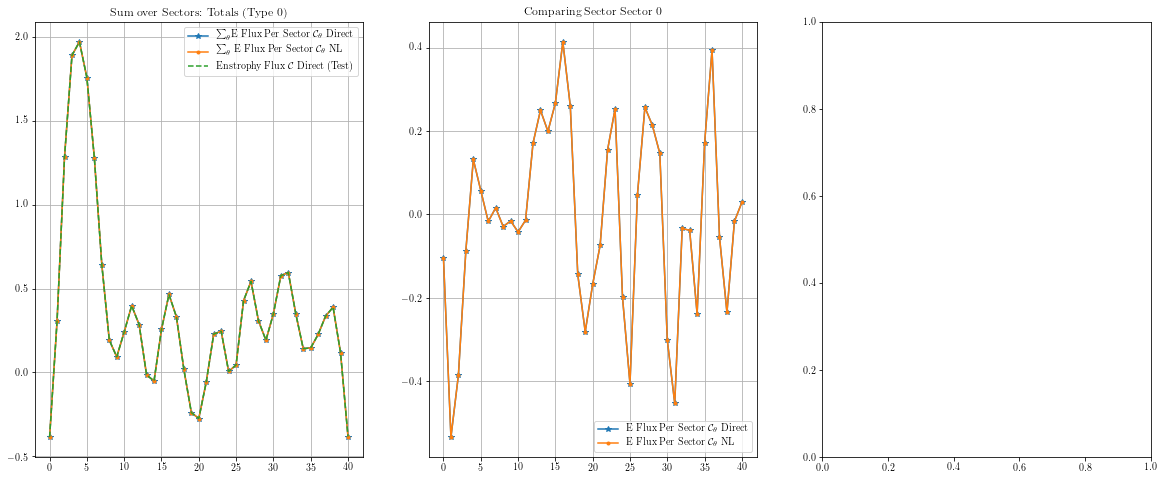

In [37]:
const_fac_sector = 4.0 * np.pi**2 
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

theta = 0 #int(post_data.num_sect // 2)
print(theta)

fig = plt.figure(figsize = (20, 8))
gs  = GridSpec(1, 3)
ax2 = fig.add_subplot(gs[0, 0])
ax2.plot(np.sum(post_data.enst_flux_per_sec[:, 0, :], axis = -1) * const_fac * norm_fac, '*-')
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
ax2.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '--')
ax2.set_title(r"Sum over Sectors: Totals (Type 0)")
ax2.grid()
ax2.legend([r"$\sum_\theta$E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"$\sum_\theta$ E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$ Direct (Test)"])

theta = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac_sector * norm_fac, '*-')
ax1.plot(post_data.enst_flux_C_theta[:, theta] * 2, '.-')
ax1.set_title(r"Comparing Sector Sector {}".format(theta))
ax1.grid()
ax1.legend([r"E Flux Per Sector $\mathcal{C}_\theta$ Direct", r"E Flux Per Sector $\mathcal{C}_\theta$ NL", r"Enstrophy Flux $\mathcal{C}$"])


# ax3 = fig.add_subplot(gs[0, 2])
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 0] * const_fac_sector * norm_fac, '*-')
# ax3.plot(post_data.enst_flux_per_sec[:, 0, 1] * const_fac_sector * norm_fac, '*-')
# ax3.legend([r"Bottom", r"Top"])
# print(post_data.enst_flux_per_sec[:, 0, 0] / post_data.enst_flux_per_sec[:, 0, 1])
plt.show()

#### Triad Types Compare: Sectors vs All

[ 2.18711060e+18  6.85432609e+16 -6.20231337e+18 -1.41566370e+19
 -2.25863715e+19 -2.44612847e+19 -1.23931210e+19 -4.94807186e+18
 -1.91023898e+18 -2.65078745e+18 -2.01999134e+19 -3.34867347e+19
 -7.26144063e+18 -2.01359026e+18 -4.96796118e+17 -3.96382276e+17
 -2.46609284e+18 -5.04874412e+18 -6.37083677e+18 -3.65510103e+18
 -1.10870777e+17  2.90483738e+18  4.64401303e+18  5.21045381e+18
  4.59236445e+18  3.78777544e+18  3.56549904e+18  2.65007451e+18
  1.04773893e+18  5.94428816e+17  2.29700231e+18  5.40968590e+18
  1.16004625e+19 -5.62535370e+18  1.74759168e+17  1.10201616e+17
 -5.30334134e+17 -1.29545945e+18 -1.86260677e+18 -8.45889286e+17
  1.26821578e+18]


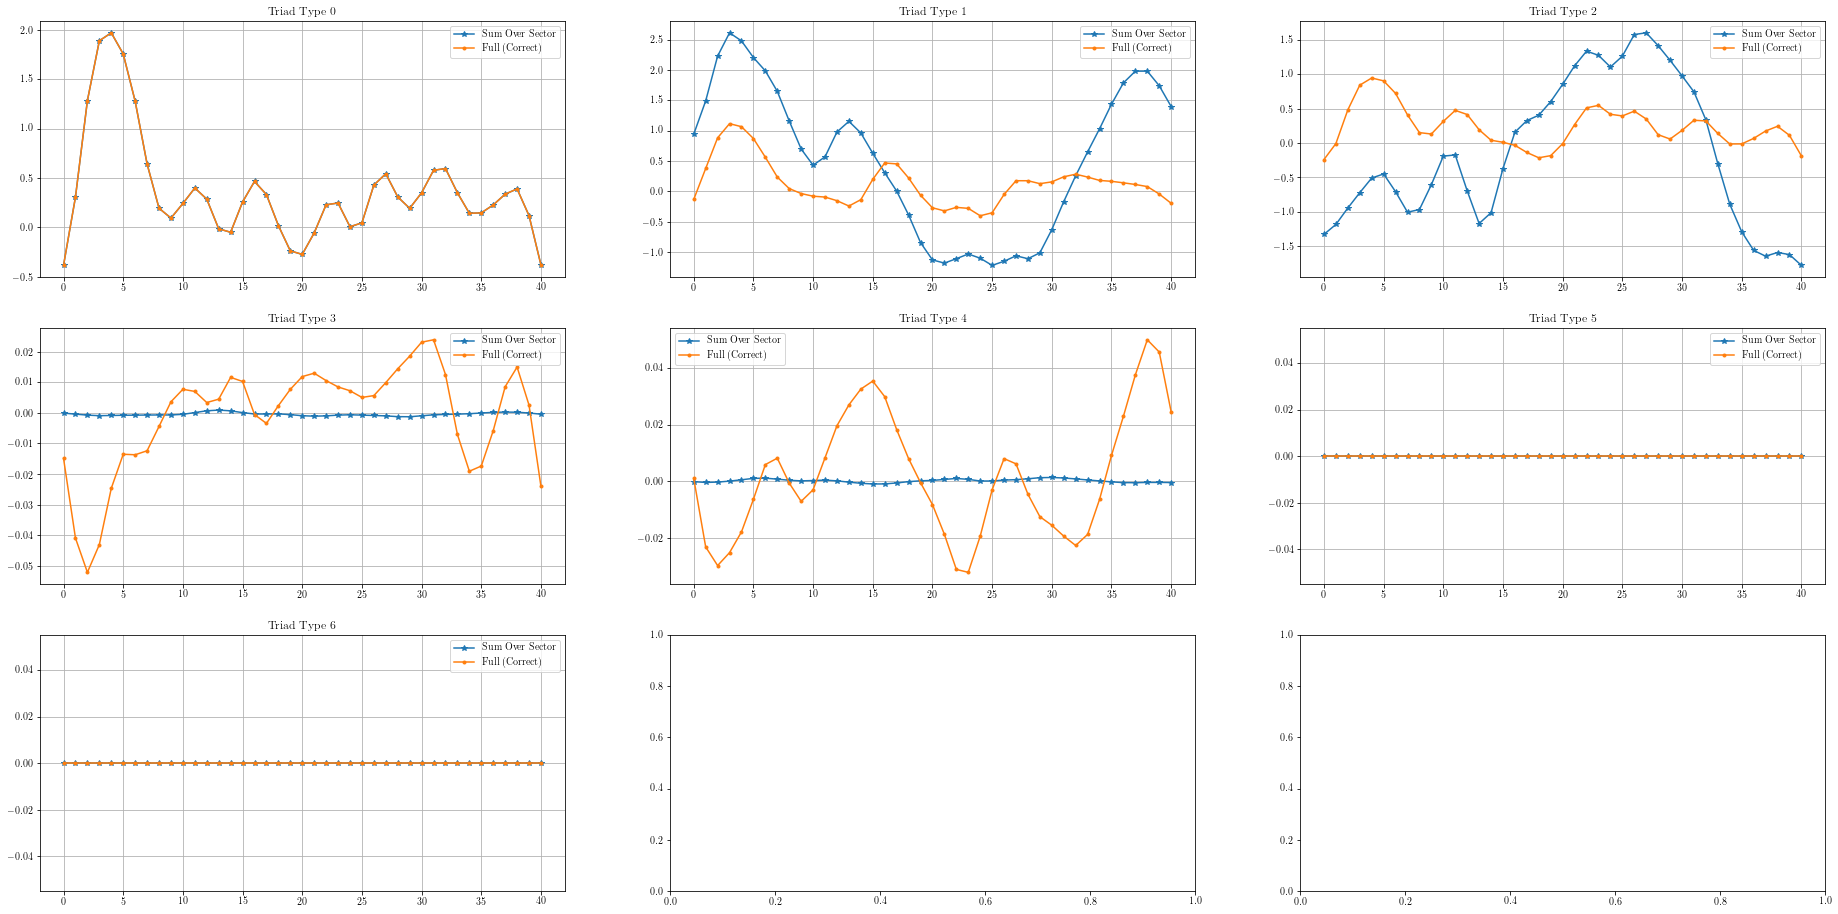

In [38]:
fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(3, 3)
ax1 = []
for i in range(3):
    for j in range(3):
        ax1.append(fig.add_subplot(gs[i, j]))
for i in range(post_data.enst_flux_per_sec.shape[1]):
    ax1[i].plot(np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac, '*-')
    ax1[i].plot(post_data.enst_flux_test[:, i] * const_fac * norm_fac, '.-')
    ax1[i].set_title(r"Triad Type {}".format(i))
#     ax1[i].set_xlim(-1, 20)
    ax1[i].legend([r"Sum Over Sector", r"Full (Correct)"])
    ax1[i].grid()
    if i == 2:
        print(1 / (np.sum(post_data.enst_flux_per_sec[:, i, :], axis = -1) * const_fac * norm_fac / post_data.enst_flux_test[:, i] * const_fac * norm_fac))
plt.show()


#### Compare Individual Sectors: Direct vs NL

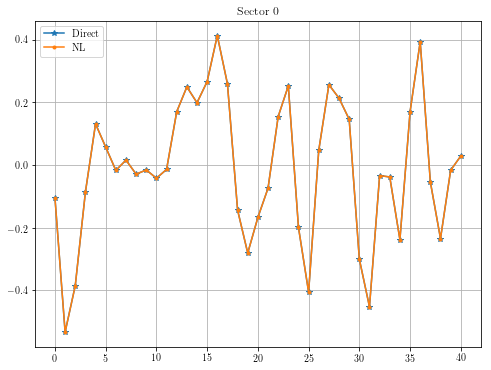

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


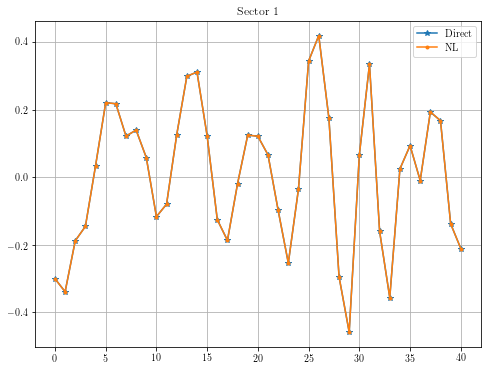

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


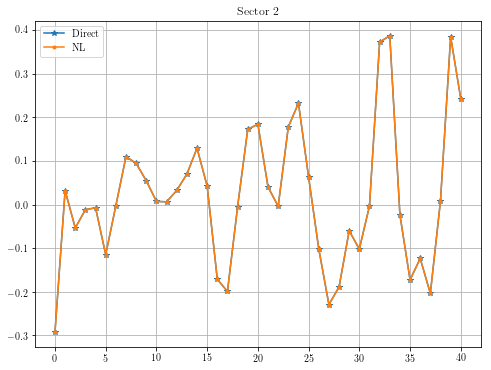

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


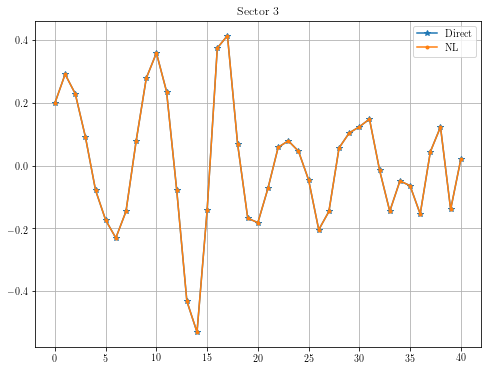

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


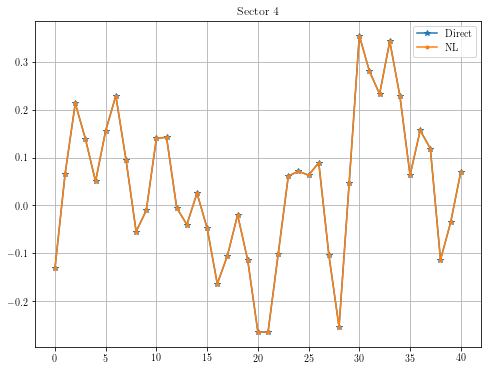

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


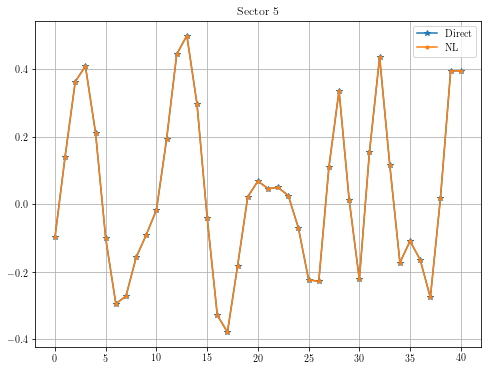

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


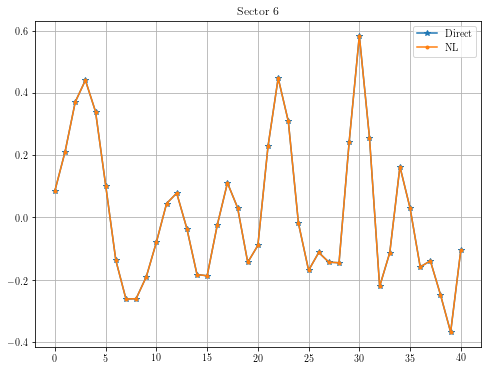

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


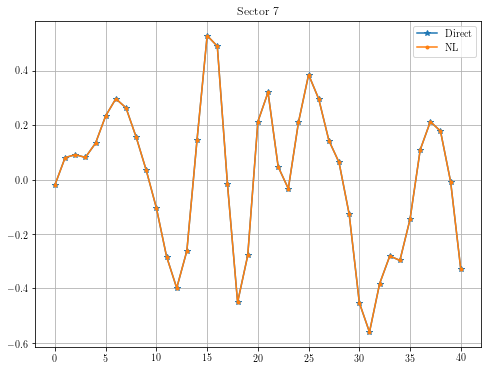

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


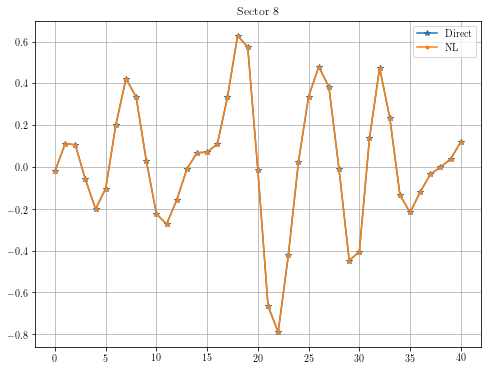

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


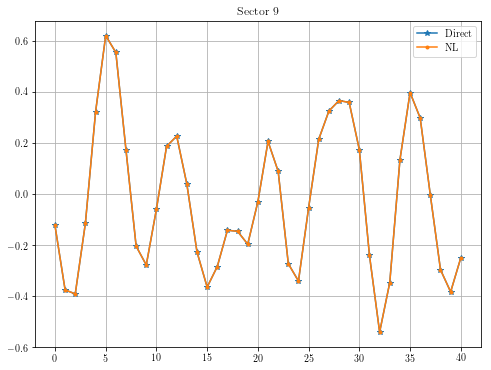

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


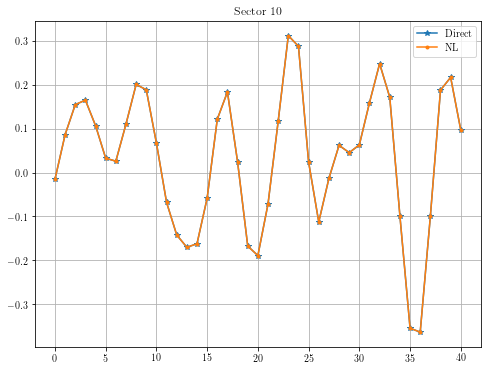

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


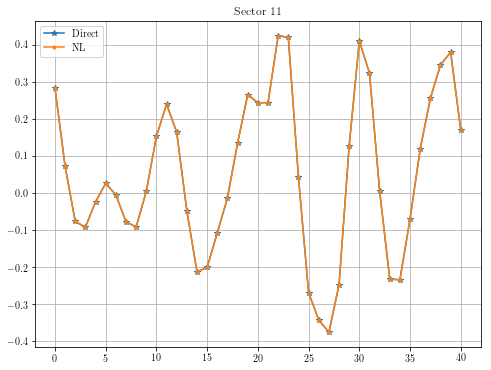

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


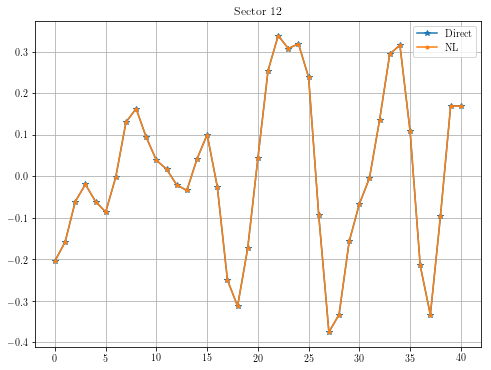

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


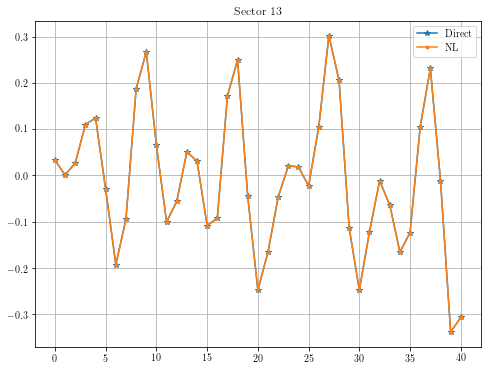

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


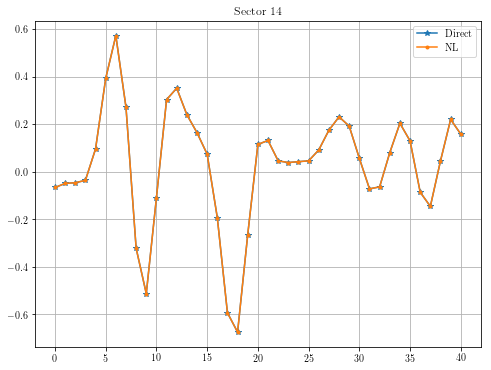

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


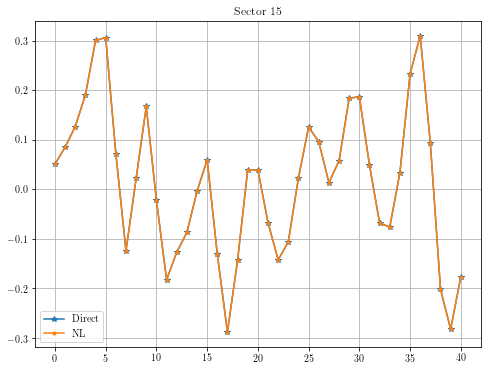

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


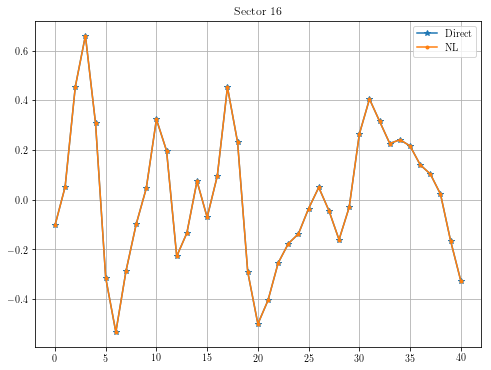

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


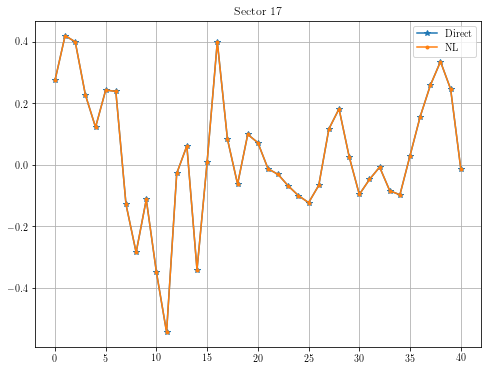

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


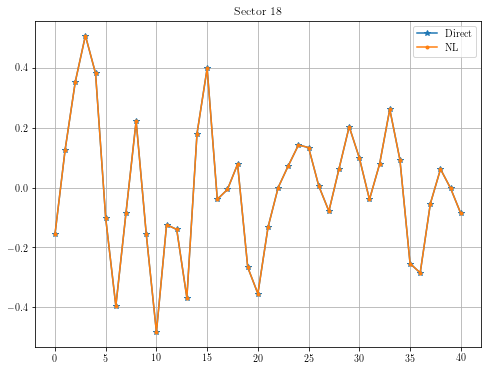

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


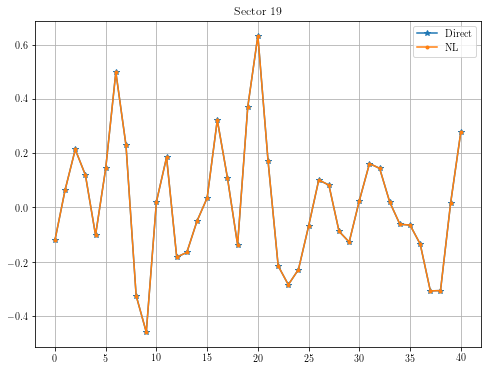

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


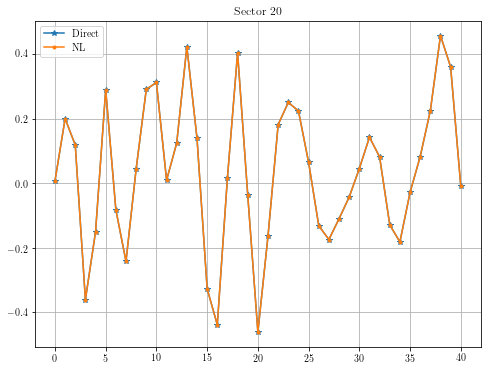

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


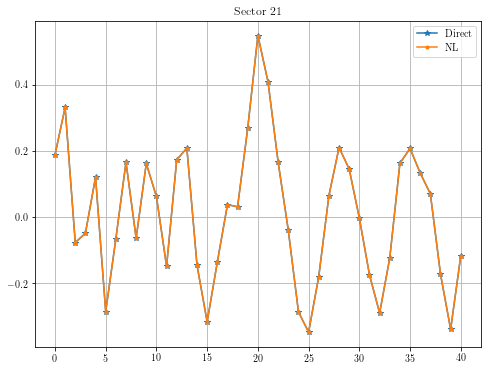

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


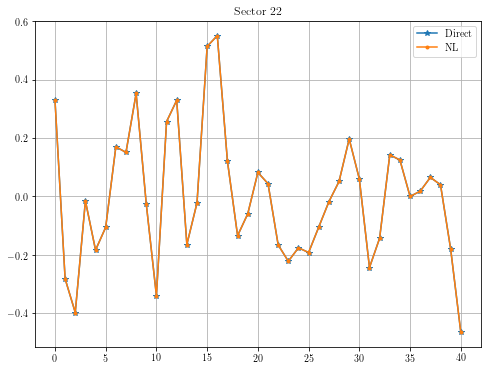

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


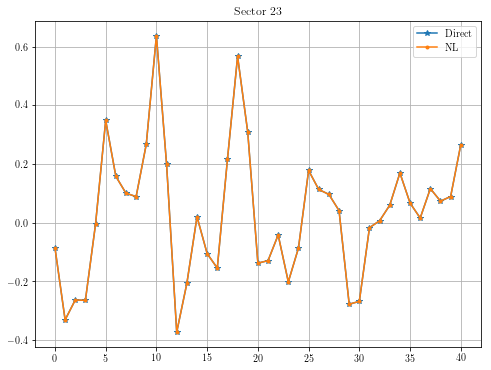

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [40]:
for a in range(post_data.num_sect):
    fig = plt.figure(figsize = (8, 6))
    gs  = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac, '*-')
    ax.plot(post_data.enst_flux_C_theta[:, a] * 2, '.-')
    ax.set_title(r"Sector {}".format(a))
    ax.legend([r"Direct", r"NL"])
    ax.grid()
    plt.show()
    
    print(post_data.enst_flux_per_sec[:, 0, a] * const_fac * norm_fac / post_data.enst_flux_C_theta[:, a])

## Compare Enstorphy Flux Computed From Nonlinear Term and Directly - Ignoring Sectors

In [42]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**3

In [41]:
## Find the constant
print((post_data.enst_flux_test[:, 0] * const_fac * norm_fac) / np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
print()
print(const_fac)
print(norm_fac)
print(1 / (14000 * .29257143))

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]

39.47841760435743
7.275957614183426e-12
0.00024414062380790708


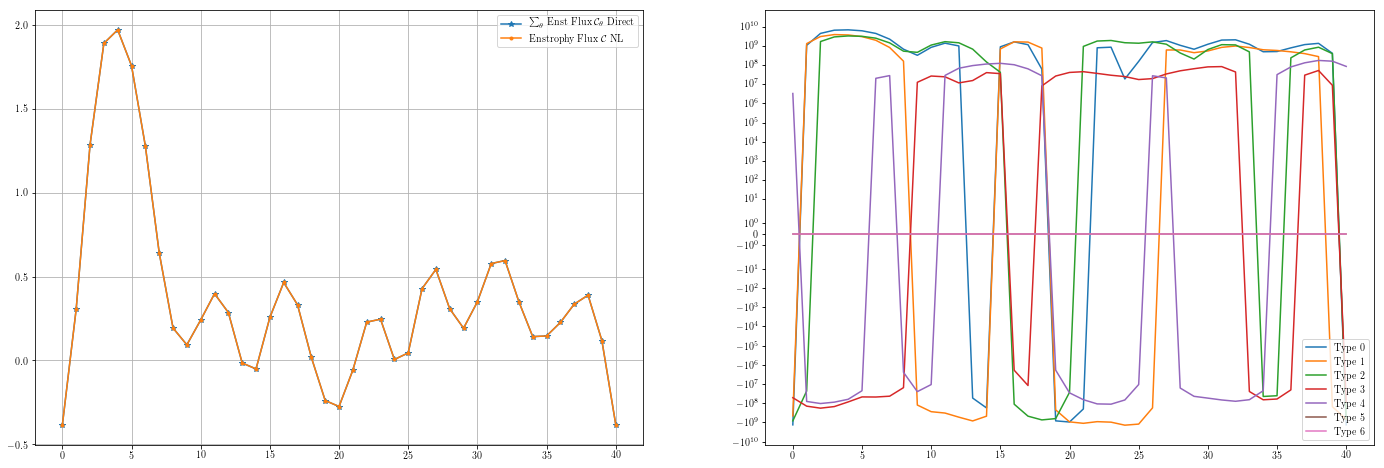

In [43]:
fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_test[:, 0] * const_fac * norm_fac, '*-')
ax1.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1) * 2, '.-')
# ax1.plot(post_data.enst_flux_C[:], '.-')
ax1.grid()
ax1.legend([r"$\sum_\theta$ Enst Flux $\mathcal{C}_\theta$ Direct", r"Enstrophy Flux $\mathcal{C}$ NL", r"Enstrophy Flux $\mathcal{C}$"])

ax2 = fig.add_subplot(gs[0, 1])
for i in range(post_data.triad_R_test.shape[1]):
    ax2.plot(post_data.enst_flux_test[:, i])
# ax2.set_yscale('log')
ax2.legend([r"Type {}".format(i) for i in range(post_data.triad_R_test.shape[1])])
ax2.set_yscale('symlog')
plt.show()

## Compare Both ways of computing Enstrophy Flux in C using Nonlinear term

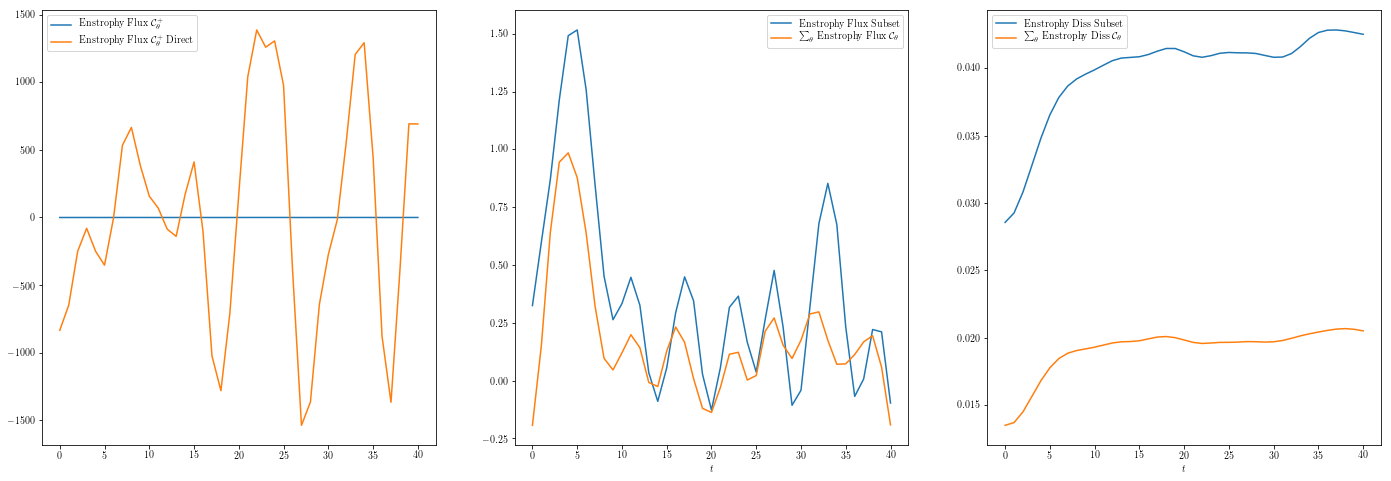

[2.11877325 2.13847755 2.12805324 2.09840003 2.07279027 2.05833303
 2.05238428 2.05403566 2.06032765 2.06583249 2.06870699 2.06987726
 2.07031539 2.07122394 2.07161744 2.06800251 2.06164253 2.06006268
 2.06631221 2.07473639 2.08041092 2.08423529 2.08717402 2.08968288
 2.09382928 2.09652547 2.0932701  2.08913468 2.08777386 2.0833544
 2.07395722 2.06461714 2.06104335 2.06821399 2.08247865 2.09056635
 2.08662935 2.07761973 2.07079486 2.06970493 2.07542031]


In [44]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2
theta = int(post_data.num_sect // 2)

fig = plt.figure(figsize = (24, 8))
gs  = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_C_theta[:, theta])
ax1.plot(post_data.enst_flux_per_sec[:, 0, theta] * const_fac * norm_fac)
ax1.legend([r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$", r"Enstrophy Flux $\mathcal{C}_{\theta}^{+}$ Direct"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enst_flux_C[:])
ax2.plot(np.sum(post_data.enst_flux_C_theta[:, :], axis = -1))
ax2.set_xlabel(r"$t$")
# ax2.set_xlim(-1, 20)
# ax2.set_yscale('log')
ax2.legend([r"Enstrophy Flux Subset", r"$\sum_\theta$ Enstrophy Flux $\mathcal{C}_\theta$", r"Total Enstrophy"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(post_data.enst_diss_C[:])
ax3.plot(np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))
# ax3.set_yscale('log')
# ax3.set_xlim(-1, 5)
ax3.set_xlabel(r"$t$")
ax3.legend([r"Enstrophy Diss Subset", r"$\sum_\theta$ Enstrophy Diss $\mathcal{C}_\theta$", r"Total Enstrophy"])

plt.show()


print(post_data.enst_diss_C[:] / np.sum(post_data.enst_diss_C_theta[:, :], axis = -1))


## NOTE: There is a discrepency between the two methods because the way the spectrum index is computed you take the sqrt and round so some modes
## are included that aren't in C.

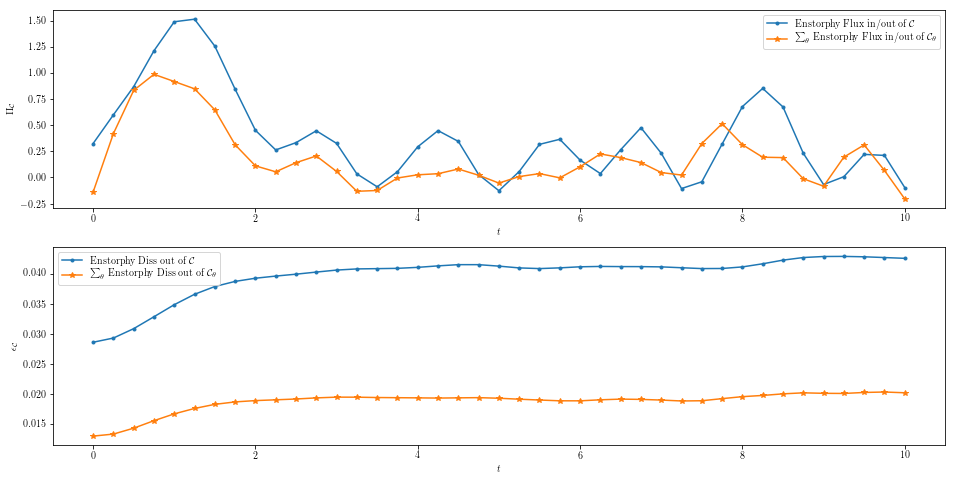

In [45]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(run_data.time, post_data.enst_flux_C[:], '.-')
ax1.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, 1:], axis = 1), '*-')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"Enstorphy Flux in/out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Flux in/out of $\mathcal{C}_\theta$"])
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(run_data.time, post_data.enst_diss_C[:], '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_diss_C_theta[:, 1:], axis = 1), '*-')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\epsilon_{\mathcal{C}}$")
ax2.legend([r"Enstorphy Diss out of $\mathcal{C}$", r"$\sum_{\theta}$ Enstorphy Diss out of $\mathcal{C}_\theta$"])
plt.show()

## Compare Spectra Between Post & Solver 

In [47]:
 t = 50

IndexError: index 50 is out of bounds for axis 0 with size 41

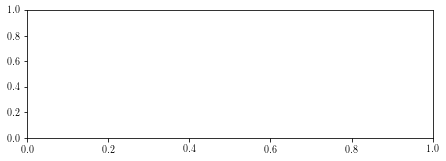

In [48]:
fig = plt.figure(figsize = (16, 8))
gs  = GridSpec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(post_data.enst_flux_spec[t, 1:], '.-')
ax1.plot(spec_data.enst_flux_spectrum[t, 1:], '--')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\Pi(k)$")
ax1.set_xscale('log')
ax1.legend([r"Post Enstorphy Flux Spec", r"Solver Enstorphy Flux Spec"])
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(post_data.enrg_flux_spec[t, 1:], '.-')
ax2.plot(spec_data.enrg_flux_spectrum[t, 1:], '--')
ax2.set_xlabel(r"$k$")
ax2.set_ylabel(r"$\Pi(k)$")
ax2.set_xscale('log')
ax2.legend([r"Post Energy Flux Spec", r"Solver Energy Flux Spec"])
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(post_data.enst_diss_spec[t, 1:], '.-')
ax3.plot(spec_data.enst_diss_spectrum[t, 1:] , '--')
ax3.set_xlabel(r"$k$")
ax3.set_ylabel(r"$\epsilon(k)$")
ax3.set_xscale('log')
ax3.legend([r"Post Enstorphy Diss Spec", r"Solver Enstorphy Diss Spec"])
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(post_data.enrg_diss_spec[t, 1:], '.-')
ax4.plot(spec_data.enrg_diss_spectrum[t, 1:] , '--')
ax4.set_xlabel(r"$k$")
ax4.set_ylabel(r"$\epsilon(k)$")
ax4.set_xscale('log')
ax4.legend([r"Post Energy Diss Spec", r"Solver Energy Diss Spec"])
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(post_data.d_enst_dt_spec[t, 1:], '.-')
ax5.plot(spec_data.d_enst_dt_spectrum[t, 1:] , '--')
ax5.set_xlabel(r"$k$")
ax5.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax5.set_xscale('log')
ax5.legend([r"Post Time Derivative of Enstrophy Spec", r"Solver Time Derivative of Enstrophy Spec"])
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(post_data.d_enrg_dt_spec[t, 1:], '.-')
ax6.plot(spec_data.d_enrg_dt_spectrum[t, 1:] , '--')
ax6.set_xlabel(r"$k$")
ax6.set_ylabel(r"$\frac{d E}{dt}(k)$")
ax6.set_xscale('log')
ax6.legend([r"Post Time Derivative of Energy Spec", r"Solver Time Derivative of Energy Spec"])
plt.show()

## Compare Enstorphy Flux in C_theta - Combing 1D and 2D Contributions

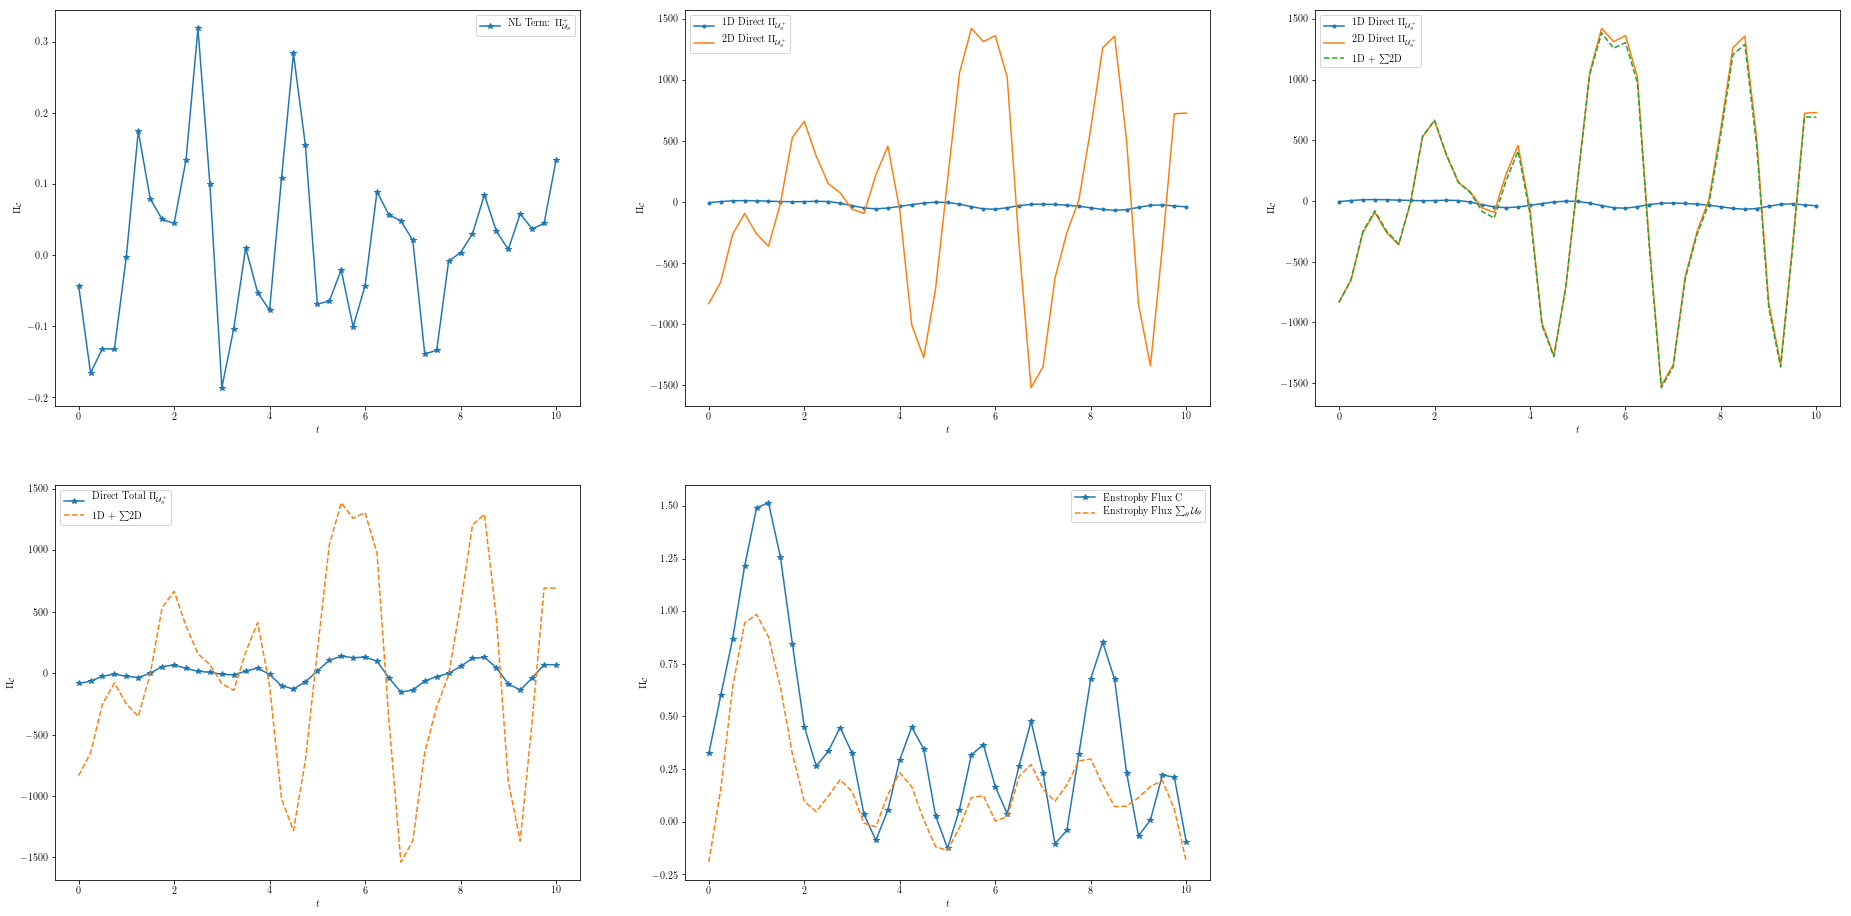

In [49]:
const_fac = 4.0 * np.pi**2 
norm_fac  = 0.5 / (sys_vars.Nx * sys_vars.Ny)**2

theta = int(post_data.num_sect//2)

fig = plt.figure(figsize = (32, 16))
gs  = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, theta],  '.-')
ax1.plot(run_data.time, post_data.enst_flux_C_theta[:, -1], '*-' )
# ax1.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta], '*-') #  * norm_fac * const_fac / 10
# ax1.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
# ax1.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax1.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax1.legend([r"NL Term: $\Pi_{\mathcal{U}_\theta}^{+}$", r"Direct Total $\Pi_{\mathcal{U}_\theta}^{+}$"])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax2.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
# ax2.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax2.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(run_data.time, post_data.enst_flux_per_sec_1d[:, 0, theta] * norm_fac * const_fac, '.-')
ax3.plot(run_data.time, np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) * norm_fac * const_fac)
ax3.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax3.legend([r"1D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"2D Direct $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(run_data.time, post_data.enst_flux_per_sec[:, 0, theta] * norm_fac * const_fac / 10, '*-')
ax4.plot(run_data.time, (np.sum(post_data.enst_flux_per_sec_2d[:, 0, theta, :], axis = -1) + post_data.enst_flux_per_sec_1d[:, 0, theta])* norm_fac * const_fac, '--')
ax4.set_xlabel(r"$t$")
ax4.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax4.legend([r"Direct Total $\Pi_{\mathcal{U}_\theta^{+}}$", r"1D + $\sum$2D"])

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(run_data.time, post_data.enst_flux_C[:], '*-')
ax5.plot(run_data.time, np.sum(post_data.enst_flux_C_theta[:, :], axis = -1), '--')
ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"$\Pi_{\mathcal{C}}$")
ax5.legend([r"Enstrophy Flux C", r"Enstrophy Flux $\sum_\theta \mathcal{U}_\theta$"])
plt.show()

# r"$\Pi_{\mathcal{U}_\theta^{+}}$: Enstorphy Flux in/out of $\mathcal{U}_\theta^{+}$", 

[-0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182   ]
[ 0.          0.          0.          0.          0.          0.
 -0.00088895  0.0109422  -0.00081001 -0.00456419 -0.01642116  0.00076059
 -0.00779385  0.01451505 -0.03074954  0.05871409  0.02116911 -0.05182
 -0.00286549  0.          0.          0.          0.          0.        ]
[ 1.06478046e-02  1.09856502e-02  1.13154840e-02  1.16371252e-02
  1.19503962e-02  1.22551232e-02  1.25511356e-02  1.28382666e-02
  1.31163530e-02  1.33852354e-02  1.36447581e-02  1.38947694e-02
  1.41351216e-02  1.43656707e-02  1.45862772e-02  1.47968053e-02
  1.49971234e-02  1.51871044e-02  1.53666249e-02  1.55355662e-02
  1.56938136e-02  1.58412568e-02  1.59777900e-02  1.61033114e-02
  1.62177240e-02  1.63209349e-02  1.64128559e-02  1.64934032e-02
  1.65624973e-02  1.66200637e-02  1.66660320e-02  1.67003366e-02
  1.67229166e-02  1.67337157e-02  1.67326823e-02  1

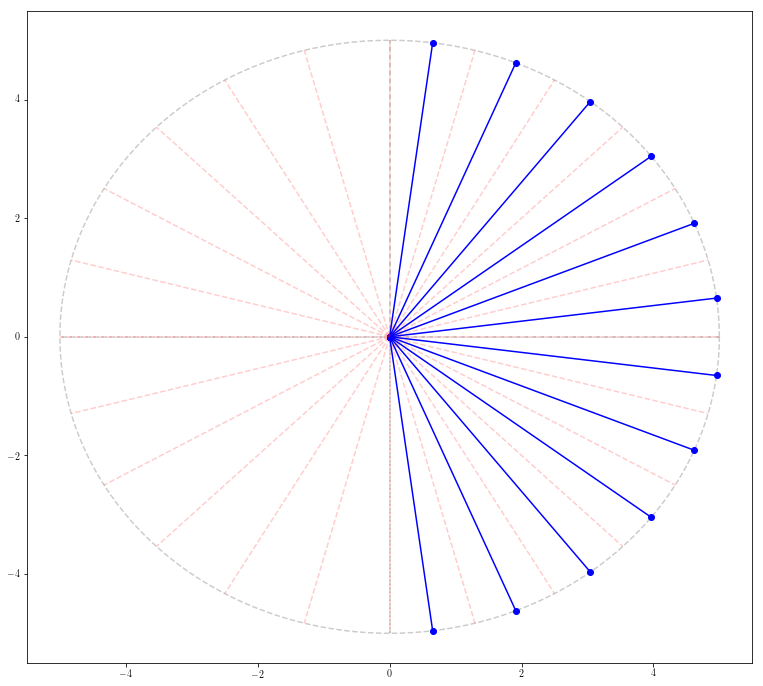

In [396]:
print(post_data.enst_flux_C_theta[-1, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)])
print(post_data.enst_flux_C_theta[-1, :])
print(np.sum(post_data.enst_flux_C_theta[:, int(post_data.num_sect // 4):int(3 * post_data.num_sect // 4)], axis = -1))


n_theta   = post_data.num_sect
dtheta    = 2.0 * np.pi / n_theta
theta     = np.arange(-np.pi, np.pi + dtheta, dtheta)
mid_theta = (theta[1:] + theta[:-1]) * 0.5
theta     = mid_theta[:]
Nx = sys_vars.Nx
Ny = sys_vars.Ny
kx = np.arange(-Nx//2 + 1, Nx//2 + 1, 1)
ky = np.arange(-Ny//2 + 1, Nx//2 + 1, 1)
kmax = Nx//3
kmax_sqr = kmax**2
C_frac = 0.75
kmax_C = int(np.ceil(C_frac * kmax))
kmax_C_sqr = kmax_C ** 2
R = kmax
angle = np.linspace(0.0, 2.0 * np.pi, 256)
x = R * np.cos(angle)
y = R * np.sin(angle)

plt.figure(figsize = (13, 12))
plt.plot(x, y, 'k--', alpha = 0.2)
plt.plot([0, 0], [-R, R], 'k--', alpha = 0.2)
plt.plot([R, -R], [0, 0], 'k--', alpha = 0.2)
for aa in range(post_data.num_sect):
    ## Plot sectors
    plt.plot([0, R*np.cos(theta[aa] - dtheta/2)], [0, R*np.sin(theta[aa] - dtheta/2)], 'r--', alpha = 0.1)
    plt.plot([0, R*np.cos(theta[aa] + dtheta/2)], [0, R*np.sin(theta[aa] + dtheta/2)], 'r--', alpha = 0.1)
#     if post_data.enst_flux_C_theta[-1, aa] != 0.0:
    if aa >= int(post_data.num_sect // 4) and aa < int(3 * post_data.num_sect // 4):
        plt.plot([0, R*np.cos(theta[aa])], [0, R*np.sin(theta[aa])], 'o-', alpha = 1, color = "b")
        

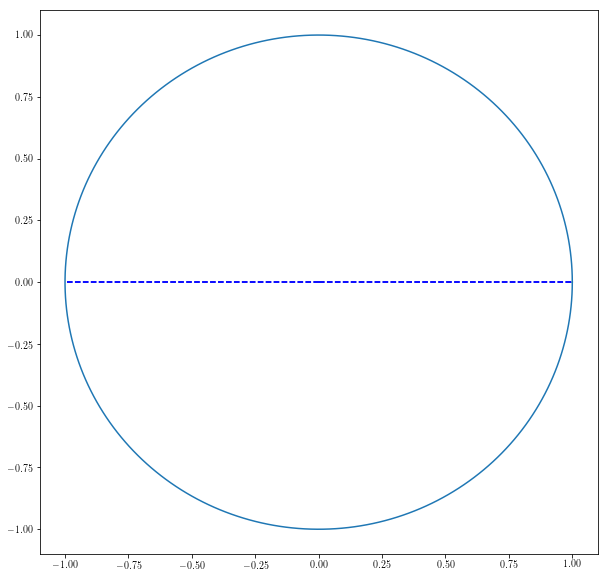

In [274]:
R = 1
angle = np.linspace(0.0, 2.0 * np.pi, 256)

x = R * np.cos(angle)
y = R * np.sin(angle)
dtheta = 2*np.pi/post_data.num_sect
fig = plt.figure(figsize = (10, 10))
plt.plot(x, y)
for i, a in enumerate(post_data.theta):
    plt.plot([0.0, R * np.cos(a - dtheta/2)], [0.0, R * np.sin(a - dtheta/2)], 'b--')
    plt.plot([0.0, R * np.cos(a + dtheta/2)], [0.0, R * np.sin(a + dtheta/2)], 'b--')    

In [38]:
Nx     = sys_vars.Nx
Ny     = sys_vars.Ny
kmax   = post_data.kmax
C_kmax = post_data.kmax_C

for k3_x in range(-Nx//2 + 1, Nx//2 + 1):
    for k3_y in range(-Nx//2 + 1, Nx//2 + 1):
        
        ## Compute polar data for k3
        k3_sqr = k3_x**2 + k3_y**2
        k3_ang = np.arctan2(k3_x, k3_y)
        k3_ang_neg = np.arctan2(-k3_x, -k3_y)
        
        if (k3_sqr > C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)
                    
        elif (k3_sqr <= C_kmax):
            for k1_x in range(-Nx//2 + 1, Nx//2 + 1):
                for k1_y in range(-Nx//2 + 1, Nx//2 + 1):
                    
                    ## Compute polar data for k1
                    k1_sqr = k1_x**2 + k1_y**2
                    k1_ang = np.arctan2(k1_x, k1_y)
                    k1_ang_neg = np.arctan2(-k1_x, -k1_y)
                    
                    ## Compute polar data for k2
                    k2_x   = k3_x - k1_x
                    k2_y   = k3_y - k1_y
                    k2_sqr = k2_x**2 + k2_y**2
                    k2_ang = np.arctan2(k2_x, k2_y)
                    k2_ang_neg = np.arctan2(-k2_x, -k2_y)